## OCOM5300M Artificial Intelligence Project – Experiments

This notebook compares multiple Large Language Model (LLM) strategies—Vanilla, Retrieval-Augmented Generation (RAG), and Cache-Augmented Generation (CAG)—using OpenAI (GPT) and Google Gemini to evaluate sales engineering demo transcripts.

Evaluation is guided primarily by the RAGAS framework, focusing on:

- Faithfulness  
- Context Precision (Compare human evaluation)
- Semantic_similarity


Additional metrics are evaluated using custom logic:

- Consistency  
- Latency  
- Score dif (Compare human evaluation)
- Cost (estimated via token tracking)


The notebook includes the following model variants:

1. Vanilla GPT (no retrieval)  
2. GPT with naive RAG approach  
3. GPT with advanced RAG retrieval  
4. Vanilla Gemini (no retrieval)  
5. Gemini with advanced RAG retrieval  
6. Gemini with CAG approach

Additional variants and analyses may be added in later cells.

In [5]:
#Imports
import json
import os
import pandas as pd
from datetime import datetime
from time import time, sleep
from openai import OpenAI  
from dotenv import load_dotenv
from chromadb import PersistentClient
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction
from ragas import evaluate
from ragas.metrics import Faithfulness, ContextPrecision, SemanticSimilarity
from ragas.run_config import RunConfig
import ragas._analytics
from datasets import Dataset
import numpy as np
import matplotlib.pyplot as plt
import umap




Load files, prep enrionment and load global variables

In [6]:
#Load transcript
transcript_path = "../data/source/calls_samples/anonymized call 01.txt"
transcript_name = os.path.basename(transcript_path)

# Load transcript
with open(transcript_path, "r") as f:
    transcript = f.read()

In [7]:
#Setup Open AI Env
load_dotenv()
openai_client = OpenAI(api_key=os.getenv("OPENAI_API_KEY")) 


os.environ["CHROMA_OPENAI_API_KEY"] = os.environ["OPENAI_API_KEY"]
CHROMA_DIR = "../data/processed/chroma_store"
chroma_client = PersistentClient(path=CHROMA_DIR)

#Reconnect to existing collection
embedding_function = OpenAIEmbeddingFunction(model_name="text-embedding-3-small")
six_habits_collection = chroma_client.get_collection(
    name="six_habits",
    embedding_function=embedding_function
)

In [8]:
#Extract participants
llm_temperature = 0 #less randon results. Maybe better higher for production, but to compare results we are using 0
llm_top_p=1 #less randon results. Maybe better higher for production, but to compare results we are using 1
def extract_se_from_transcript(transcript: str, model="gpt-3.5-turbo"):
    prompt = (
        "You are analyzing a sales demo transcript.\n\n"
        "Identify the participant who acts as the Sales Engineer (SE). "
        "Only one person should be labeled as SE. If more than one person seems like an SE, "
        "choose the one who speaks most often.\n\n"
        "Return only the name or identifier of the SE. Do not include any explanation.\n\n"
        f"Transcript:\n{transcript}"
    )

    response = openai_client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=llm_temperature,
        top_p = llm_top_p
    )

    return response.choices[0].message.content.strip()
    
se_name = extract_se_from_transcript(transcript)
print("Identified SE:", se_name)

Identified SE: Luiz


In [9]:
#load configurations
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DEFAULT_CONFIG_PATH = os.path.join(BASE_DIR, "data", "config", "acme_config.json")

def load_config(config_path: str = DEFAULT_CONFIG_PATH):
    with open(config_path, "r") as f:
        config = json.load(f)
    return config
    
config = load_config()

# Common variables
metric_list = config["metrics"]
framework = config["coaching_frameworks"][0]
framework_name = framework["name"]
framework_keys = framework["scoring_framework_keys"]
framework_context = framework["context"]
model_name = config["settings"].get("model", "gpt-3.5-turbo")
scoring_guide = config["settings"].get("scoring_guide")
scoring_keys = framework.get("scoring_framework_keys", [])
max_book_chunks = config["settings"].get("max_book_chunks", 3)


#Debug Mode

debug_mode = 1

In [10]:
print("metric_list: ", metric_list)

metric_list:  [{'id': 'metric01', 'name': 'clarity', 'description': 'How clearly the message was communicated to the customer.', 'weight': 0.25}, {'id': 'metric02', 'name': 'engagement', 'description': 'Level of interaction and active listening with the customer.', 'weight': 0.2}, {'id': 'metric03', 'name': 'relevance', 'description': "How well the content matched the customer's needs and context.", 'weight': 0.3}, {'id': 'metric04', 'name': 'structure', 'description': 'Logical flow and organization of the demo or conversation.', 'weight': 0.15}, {'id': 'metric05', 'name': 'confidence', 'description': 'Speaker’s professionalism, tone, and delivery confidence.', 'weight': 0.1}]


In [11]:
# Load human evaluation
HUMAN_EVAL_PATH = os.path.join(BASE_DIR, "data", "source", "human_evaluation", "humaneval01.json")

def load_human_evaluation(eval_path: str = HUMAN_EVAL_PATH):
    with open(eval_path, "r", encoding="utf-8") as f:
        eval_data = json.load(f)
    print(f"Loaded human evaluation from: {eval_path}")
    return eval_data

# Load it
human_eval = load_human_evaluation()

#Get overall score
# Calculate average of all metric scores (ignore transcript_name)
overall_human_score = round(
    sum(v["score"] for k, v in human_eval.items() if k != "transcript_name") / 
    (len(human_eval) - 1),
    2
)
print("human_eval: ",human_eval)
print("\nHuman Overall Score:", overall_human_score)


Loaded human evaluation from: /Users/lei/Library/CloudStorage/OneDrive-Personal/01 - Documentos/Z - Estudo/01 - LEEDS/10 - Project/data/source/human_evaluation/humaneval01.json
human_eval:  {'transcript_name': 'anonymized call 01.txt', 'clarity': {'score': 4, 'explanation': 'The message was communicated clearly to the customer, but there were a few instances where more concise explanations could have been provided.'}, 'engagement': {'score': 4, 'explanation': 'There was good interaction and active listening with the customer, but there were moments where more engagement could have been demonstrated.'}, 'relevance': {'score': 5, 'explanation': "The content of the demo was highly relevant to the customer's needs and context, addressing specific questions and concerns effectively."}, 'structure': {'score': 4, 'explanation': 'The demo had a logical flow and organization overall, but there were moments where the structure could have been improved for better clarity.'}, 'confidence': {'score

In [12]:
# Define the evaluation log structure

#All testes
model_variants = ["GPT Vanilla", "GPT Naive RAG", "GPT Advanced RAG", "Gemini Advanced RAG","Gemini CAG"]
output_types = ["explanation", "feedback"]
transcripts = ["anonymized call 01.txt"]

rows = []

for model_variant in model_variants:
    for output_type in output_types:
        for transcript_name in transcripts:
            rows.append({
                "model_variant": model_variant,
                "model_name": model_name,
                "output_type": output_type,
                "transcript_name": transcript_name,
                "context_precision": None, # RAGAS evaluation
                "faithfulness": None, # RAGAS evaluation
                "semantic_similarity": None, # RAGAS evaluation
                "score_diff": None, # Difference of model scoring and human expert scoring  
                "consistency": None, # How much score change among multple runs
                "latency": None, # Seconds it took to evaluate
                "input_tokens": None, #count of input tokens
                "cached_input_tokens": None, #count of cached input tokens 
                "input_token_price_M": None, #Price per input token
                "cached_input_token_price_M": None, #Price per cached input token
                "output_tokens": None, #count of output tokens
                "output_token_price_M": None, #Price per output token                
                "cost_usd": None # Approximate API usage cost
            })

eval_log = pd.DataFrame(rows)

eval_log

,model_variant,model_name,output_type,transcript_name,context_precision,faithfulness,semantic_similarity,score_diff,consistency,latency,input_tokens,cached_input_tokens,input_token_price_M,cached_input_token_price_M,output_tokens,output_token_price_M,cost_usd
0,GPT Vanilla,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
1,GPT Vanilla,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
2,GPT Naive RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
3,GPT Naive RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
4,GPT Advanced RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
5,GPT Advanced RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
6,Gemini Advanced RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
7,Gemini Advanced RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
8,Gemini CAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
9,Gemini CAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None


### 1 Open AI

#### 1.1 GPT Vanilla

Here we are not embedning the content of the evaluation/coaching Framework.

In [13]:
#Set log key
model_variant = "GPT Vanilla"

In [14]:
# GPT Vanilla scoring prompt for Jupyter Notebook (no RAG, no enrichment)

def build_scoring_prompt_gpt_vanilla(transcript, metric_list, se_name):
    prompt = (
        f"You are a sales engineering coach evaluating a demo transcript.\n"
        f"The main Sales Engineer in this conversation is: {se_name}.\n"
        "Evaluate the demo transcript focusing on the performance of the Sales Engineer.\n"
        "Consider the full conversation and how others interacted with them,\n"
        "but base your scores only on how effectively this person demonstrated best practices.\n\n"
    )

    prompt += "Evaluate based on these criteria:\n"
    for metric in metric_list:
        prompt += f"- {metric['name']}: {metric['description']}\n"

    # Add strictness note if available
    strictness_note = config.get("settings", {}).get("scoring_guide", {}).get("strictness_note")
    if strictness_note:
        prompt += "\n" + strictness_note.strip() + "\n"

    prompt += ("\nFor each metric, include:\n"
               "- score (1 to 5)\n"
               "- explanation\n")

    prompt += "\nTranscript:\n" + transcript.strip() + "\n"
    prompt += "\nYour response MUST be a single, valid JSON object and nothing else. like:\n"
    prompt += '''{
        "clarity": {
            "score": 4,
            "explanation": "..."
        },
        ...
    }'''
    return prompt

# Call GPT and parse JSON

def call_gpt_vanilla(prompt, model="gpt-3.5-turbo", parse_json=True):

    print("Calling GPT with model:", model)

    response = openai_client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=llm_temperature,
        top_p = llm_top_p
    )
    reply = response.choices[0].message.content
    
    #Return token usage
    usage = response.usage 


    if not parse_json:
        return reply.strip(), usage

    try:
        return json.loads(reply), usage
    except json.JSONDecodeError:
        print("GPT returned invalid JSON:\n", reply)
        return None, usage



# Wrapper to run everything in the notebook without framework, context, or book chunks
def score_transcript_gpt_vanilla(transcript, se_name, metric_list, model="gpt-3.5-turbo"):
    prompt = build_scoring_prompt_gpt_vanilla(transcript, metric_list, se_name)
    results, usage = call_gpt_vanilla(prompt, model=model)
    return results, usage




#### 1.1.1 Vanilla Basic Evaluation

Here we are keeping track of latency, socre diff, score consistency and cost


In [15]:
#Get standard deviation for consitency
# Run scoring multiple times to measure consistency
num_runs = 5
scores = []
score_diffs = []
latencies = []
# Usage tracking
input_tokens_list = []
output_tokens_list = []
total_tokens_list = []

for i in range(num_runs):
    print(f"\nRun {i+1}/{num_runs}")

    start_time = time()
    vanilla_results, usage = score_transcript_gpt_vanilla(transcript, se_name, metric_list, model=model_name)
    end_time = time()

    #Track latency
    latency = round(end_time - start_time, 2)
    latencies.append(latency)


    # Track token usage
    input_tokens = usage.prompt_tokens
    output_tokens = usage.completion_tokens
    total_tokens = usage.total_tokens

    input_tokens_list.append(input_tokens)
    output_tokens_list.append(output_tokens)
    total_tokens_list.append(total_tokens)

    # Track overall score
    metric_scores = [v["score"] for v in vanilla_results.values()]
    overall_score = sum(metric_scores) / len(metric_scores)
    scores.append(overall_score)

    # Score diff vs human
    score_diff = abs(overall_score - overall_human_score)
    score_diffs.append(score_diff)

# Calculate consistency as standard deviation of scores
consistency_std = round(np.std(scores), 4)

# Calculate average latency
vanilla_latency_seconds = round(np.mean(latencies), 2)

# Calculate average usage
vanilla_input_tokens = round(np.mean(input_tokens_list), 2)
vanilla_output_tokens = round(np.mean(output_tokens_list), 2)
vanilla_total_tokens = round(np.mean(total_tokens_list), 2)

# Score diff average
avg_score_diff = round(np.mean(score_diffs), 4)

# Output results
print(f"\nOverall scores: {scores}")
print(f"Consistency (std deviation): {consistency_std}")
print(f"Average latency: {vanilla_latency_seconds}")
print(f"Avg input tokens: {vanilla_input_tokens}")
print(f"Avg output tokens: {vanilla_output_tokens}")
print(f"Avg total tokens: {vanilla_total_tokens}")
print(f"Average score diff vs human: {avg_score_diff}")




Run 1/5
Calling GPT with model: gpt-3.5-turbo

Run 2/5
Calling GPT with model: gpt-3.5-turbo

Run 3/5
Calling GPT with model: gpt-3.5-turbo

Run 4/5
Calling GPT with model: gpt-3.5-turbo

Run 5/5
Calling GPT with model: gpt-3.5-turbo

Overall scores: [4.0, 3.8, 4.0, 3.8, 3.8]
Consistency (std deviation): 0.098
Average latency: 5.46
Avg input tokens: 10171.0
Avg output tokens: 318.4
Avg total tokens: 10489.4
Average score diff vs human: 0.32


In [16]:
vanilla_results

{'clarity': {'score': 4,
  'explanation': 'Luiz effectively communicated the features and capabilities of the platform, providing detailed explanations and examples. However, at times, the conversation veered into technical details that may have been overwhelming for the customer.'},
 'engagement': {'score': 3,
  'explanation': "Luiz encouraged interaction by inviting questions and feedback, but there were moments where the customer seemed to dominate the conversation. More active listening and engagement with the customer's specific needs could have improved this score."},
 'relevance': {'score': 4,
  'explanation': "Luiz demonstrated a good understanding of the customer's context and needs, tailoring the demo to address specific concerns such as integration, reporting, and flexibility. However, there were instances where the discussion went beyond the customer's immediate requirements."},
 'structure': {'score': 4,
  'explanation': "The demo had a logical flow, starting with an overv

In [17]:
#Token price USD
#https://openai.com/api/pricing/
#gpt-3.5-turbo
input_token_price_M = 0.5
output_token_price_M = 1.5

#Update latency for explanation
vanilla_cost_usd = (vanilla_input_tokens*input_token_price_M/1000000)+(vanilla_output_tokens*output_token_price_M/1000000)


eval_log.loc[
    (eval_log["model_variant"] == model_variant) &
    (eval_log["output_type"] == "explanation") &
    (eval_log["transcript_name"] == transcript_name),
    ["latency", "consistency", "score_diff","input_tokens", "output_tokens","input_token_price_M","output_token_price_M","cost_usd"]
] = [
    round(vanilla_latency_seconds, 2),
    round(consistency_std, 4),
    avg_score_diff,
    round(vanilla_input_tokens, 2),
    round(vanilla_output_tokens, 2),
    input_token_price_M,
    output_token_price_M,
    vanilla_cost_usd
]


In [18]:
eval_log

,model_variant,model_name,output_type,transcript_name,context_precision,faithfulness,semantic_similarity,score_diff,consistency,latency,input_tokens,cached_input_tokens,input_token_price_M,cached_input_token_price_M,output_tokens,output_token_price_M,cost_usd
0,GPT Vanilla,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,0.32,0.098,5.46,10171.0,None,0.5,None,318.4,1.5,0.005563
1,GPT Vanilla,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
2,GPT Naive RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
3,GPT Naive RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
4,GPT Advanced RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
5,GPT Advanced RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
6,Gemini Advanced RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
7,Gemini Advanced RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
8,Gemini CAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
9,Gemini CAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None


In [19]:
#check vanilla results
for metric, data in vanilla_results.items():
    print(f"\n{metric.upper()}")
    print(f"Score: {data['score']}")
    print(f"Explanation: {data['explanation']}")


CLARITY
Score: 4
Explanation: Luiz effectively communicated the features and capabilities of the platform, providing detailed explanations and examples. However, at times, the conversation veered into technical details that may have been overwhelming for the customer.

ENGAGEMENT
Score: 3
Explanation: Luiz encouraged interaction by inviting questions and feedback, but there were moments where the customer seemed to dominate the conversation. More active listening and engagement with the customer's specific needs could have improved this score.

RELEVANCE
Score: 4
Explanation: Luiz demonstrated a good understanding of the customer's context and needs, tailoring the demo to address specific concerns such as integration, reporting, and flexibility. However, there were instances where the discussion went beyond the customer's immediate requirements.

STRUCTURE
Score: 4
Explanation: The demo had a logical flow, starting with an overview of the platform and then delving into different modul

In [20]:
#generating coachin output
def build_metric_coaching_prompts_gpt_vanilla (explanations):
    prompts = {}

    for metric, data in explanations.items():
        score = data.get("score", "")
        explanation = data.get("explanation", "").strip()

        prompt = (
            "You are a sales engineering coach helping improve coaching feedback.\n\n"
            "Here is a current explanation or evaluation summary for the metric:\n"
            f"{explanation}\n\n"
            "Now, extend and enrich the feedback. Add a paragraph (100–150 words) that:\n"
            "- Elaborates on the key coaching points\n"
            "- Highlights what the Sales Engineer did well\n"
            "- Offers practical advice or encouragement to improve\n\n"
            "Only append the new enriched paragraph. Do not repeat the original text."
        )

        prompts[metric] = prompt

    return prompts


In [21]:
coaching_outputs = {}

# Usage tracking lists
input_tokens_list = []
output_tokens_list = []
total_tokens_list = []

# Get Vanilla latency
vanilla_latency_seconds = 0
start_time = time()
print("\nvanilla_latency_seconds: ", vanilla_latency_seconds) 

coaching_prompts = build_metric_coaching_prompts_gpt_vanilla(vanilla_results)

for metric, prompt in coaching_prompts.items():
    enriched, usage = call_gpt_vanilla(prompt, model=model_name, parse_json=False)
    coaching_outputs[metric] = enriched

    # Track usage
    input_tokens_list.append(usage.prompt_tokens)
    output_tokens_list.append(usage.completion_tokens)
    total_tokens_list.append(usage.total_tokens)

end_time = time()
vanilla_latency_seconds = round(end_time - start_time, 2)
print("\nvanilla_latency_seconds: ", vanilla_latency_seconds)

# Averages
vanilla_input_tokens = round(np.mean(input_tokens_list), 2)
vanilla_output_tokens = round(np.mean(output_tokens_list), 2)
vanilla_total_tokens = round(np.mean(total_tokens_list), 2)


# Print results
print(f"Avg prompt tokens: {vanilla_input_tokens}")
print(f"Avg completion tokens: {vanilla_output_tokens}")
print(f"Avg total tokens: {vanilla_total_tokens}")





vanilla_latency_seconds:  0
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo

vanilla_latency_seconds:  10.79
Avg prompt tokens: 133.4
Avg completion tokens: 153.6
Avg total tokens: 287.0


In [22]:
coaching_outputs

{'clarity': "Luiz demonstrated a strong understanding of the platform's features and capabilities, showcasing his technical expertise effectively. His detailed explanations and examples were valuable in helping the customer understand the product better. Moving forward, it would be beneficial for Luiz to strike a balance between providing technical details and keeping the conversation at a level that is easily digestible for the customer. Encouraging him to gauge the customer's level of technical knowledge and adjust his explanations accordingly will help ensure that the customer remains engaged and does not feel overwhelmed. Additionally, incorporating more real-world use cases and benefits into his explanations can help make the information more relatable and impactful for the customer. Overall, Luiz is on the right track, and with some adjustments, he can further enhance his communication skills and provide even more value to customers during sales conversations.",
 'engagement': "L

In [23]:
#Update latency for explanation
vanilla_cost_usd = (vanilla_input_tokens*input_token_price_M/1000000)+(vanilla_output_tokens*output_token_price_M/1000000)

#Update latency and cost for feedback
eval_log.loc[
    (eval_log["model_variant"] == model_variant) &
    (eval_log["output_type"] == "feedback") &
    (eval_log["transcript_name"] == transcript_name),
    ["latency", "input_tokens", "output_tokens", "input_token_price_M", "output_token_price_M", "cost_usd"]
] = [
    round(vanilla_latency_seconds, 2),
    round(vanilla_input_tokens, 2),
    round(vanilla_output_tokens, 2),
    input_token_price_M,
    output_token_price_M,
    round(vanilla_cost_usd, 6)
]


In [24]:
eval_log

,model_variant,model_name,output_type,transcript_name,context_precision,faithfulness,semantic_similarity,score_diff,consistency,latency,input_tokens,cached_input_tokens,input_token_price_M,cached_input_token_price_M,output_tokens,output_token_price_M,cost_usd
0,GPT Vanilla,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,0.32,0.098,5.46,10171.0,None,0.5,None,318.4,1.5,0.005563
1,GPT Vanilla,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,10.79,133.4,None,0.5,None,153.6,1.5,0.000297
2,GPT Naive RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
3,GPT Naive RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
4,GPT Advanced RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
5,GPT Advanced RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
6,Gemini Advanced RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
7,Gemini Advanced RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
8,Gemini CAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
9,Gemini CAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None


In [25]:
for metric, coaching in coaching_outputs.items():
    print(f"{'-'*60}")
    print(f"-Metric: {metric.upper()}")
    print(f"{'-'*60}")
    print(coaching.strip())


------------------------------------------------------------
-Metric: CLARITY
------------------------------------------------------------
Luiz demonstrated a strong understanding of the platform's features and capabilities, showcasing his technical expertise effectively. His detailed explanations and examples were valuable in helping the customer understand the product better. Moving forward, it would be beneficial for Luiz to strike a balance between providing technical details and keeping the conversation at a level that is easily digestible for the customer. Encouraging him to gauge the customer's level of technical knowledge and adjust his explanations accordingly will help ensure that the customer remains engaged and does not feel overwhelmed. Additionally, incorporating more real-world use cases and benefits into his explanations can help make the information more relatable and impactful for the customer. Overall, Luiz is on the right track, and with some adjustments, he can fur

In [26]:
#combining dicts
combined_outputs = {
    metric: {
        "explanation": vanilla_results[metric]["explanation"],
        "feedback": coaching_outputs[metric]
    }
    for metric in vanilla_results.keys()
}

In [27]:
combined_outputs

{'clarity': {'explanation': 'Luiz effectively communicated the features and capabilities of the platform, providing detailed explanations and examples. However, at times, the conversation veered into technical details that may have been overwhelming for the customer.',
  'feedback': "Luiz demonstrated a strong understanding of the platform's features and capabilities, showcasing his technical expertise effectively. His detailed explanations and examples were valuable in helping the customer understand the product better. Moving forward, it would be beneficial for Luiz to strike a balance between providing technical details and keeping the conversation at a level that is easily digestible for the customer. Encouraging him to gauge the customer's level of technical knowledge and adjust his explanations accordingly will help ensure that the customer remains engaged and does not feel overwhelmed. Additionally, incorporating more real-world use cases and benefits into his explanations can h

#### 1.1.2 Vanilla RAGAS Evaluation

**Faithfulness, Context Precision and Semantic Similarity**
 
For the Vanilla model, Faithfulness Context precision and Semantic Similarity will be evaluated by comparing its outputs with chunks from the book and human evaluation. This is intentionally designed to demonstrate how poorly the model might perform on these two metrics, since it did not have access to the book/context when generating its responses.
To give it the best possible chance to perform, we will first generate the output, then retrieve the top-k book chunks that are most similar to that output.

In [28]:
def retrieve_vanilla_chunks_for_outputs(
    metric_output: dict,
    collection,
    model=model_name,
    top_k=3
):
    """
    For each metric, generate a refined query for explanation and feedback using GPT,
    then retrieve top-k chunks from ChromaDB for each.
    """
    enriched_output = {}

    for metric, outputs in metric_output.items():
        enriched_output[metric] = {
            "explanation": outputs.get("explanation", "").strip(),
            "feedback": outputs.get("feedback", "").strip(),
            "explanation_chunks": [],
            "feedback_chunks": []
        }

        # --- Explanation ---
        explanation = enriched_output[metric]["explanation"]
        if explanation:
            prompt_expl = (
                f"You are helping retrieve relevant coaching content based on a demo explanation.\n"
                f"Here is the explanation for '{metric}':\n{explanation}\n\n"
                f"Write a short, clear search query suitable for retrieving relevant content from a sales coaching book."
            )
            response_expl = openai_client.chat.completions.create(
                model=model,
                messages=[{"role": "user", "content": prompt_expl}],
                temperature=llm_temperature,
                top_p = llm_top_p
            )
            query_expl = response_expl.choices[0].message.content.strip()

            result_expl = collection.query(query_texts=[query_expl], n_results=top_k)
            enriched_output[metric]["explanation_chunks"] = result_expl["documents"][0]

        # --- Feedback ---
        feedback = enriched_output[metric]["feedback"]
        if feedback:
            prompt_feed = (
                f"You are helping retrieve relevant coaching advice based on a demo feedback comment.\n"
                f"Here is the feedback for '{metric}':\n{feedback}\n\n"
                f"Write a short, clear search query suitable for retrieving improvement tips from a coaching book."
            )
            response_feed = openai_client.chat.completions.create(
                model=model,
                messages=[{"role": "user", "content": prompt_feed}],
                temperature=llm_temperature,
                top_p = llm_top_p
            )
            query_feed = response_feed.choices[0].message.content.strip()

            result_feed = collection.query(query_texts=[query_feed], n_results=top_k)
            enriched_output[metric]["feedback_chunks"] = result_feed["documents"][0]

    return enriched_output


In [29]:
vanilla_results_and_chunks = retrieve_vanilla_chunks_for_outputs(
    metric_output=combined_outputs,
    collection=six_habits_collection,
    model="gpt-3.5-turbo",
    top_k=3
)

In [30]:
vanilla_results_and_chunks

{'clarity': {'explanation': 'Luiz effectively communicated the features and capabilities of the platform, providing detailed explanations and examples. However, at times, the conversation veered into technical details that may have been overwhelming for the customer.',
  'feedback': "Luiz demonstrated a strong understanding of the platform's features and capabilities, showcasing his technical expertise effectively. His detailed explanations and examples were valuable in helping the customer understand the product better. Moving forward, it would be beneficial for Luiz to strike a balance between providing technical details and keeping the conversation at a level that is easily digestible for the customer. Encouraging him to gauge the customer's level of technical knowledge and adjust his explanations accordingly will help ensure that the customer remains engaged and does not feel overwhelmed. Additionally, incorporating more real-world use cases and benefits into his explanations can h

Now we start RAGAS Faithfulness and ContextPrecision evaluation

In [31]:
#Data privacy concern, disable RAGAS telemetry
def no_track(*args, **kwargs):
    pass

ragas._analytics.track = no_track

def evaluate_with_ragas(
    results_and_chunks,
    model_variant,
    transcript_name,
    eval_log,
    human_eval=None,
    full_context_override=None,
    max_workers=16
):
    """
    Based on a dict with all explanation, chunks and feedback, use RAGAS to evaluate Faithfulness, ContextPrecision and SemanticSimilarity
    """
    # Set debug mode
    debug_evaluate_with_ragas = 1
    
    output_types = ["feedback", "explanation"]
    metrics = [Faithfulness(), ContextPrecision(), SemanticSimilarity()]

    for output_type in output_types:
        records = []

        for metric_name, data in results_and_chunks.items():
            output_text = data.get(output_type)

            #Afapt to work with override context
            if full_context_override:
                contexts = [full_context_override]
            else:
                contexts = data.get(f"{output_type}_chunks", [])


            raw_output = data.get(output_type)

            # Normalize output_text in case it's a tuple like (text, usage_data)
            if isinstance(raw_output, tuple):
                output_text = raw_output[0]
            else:
                output_text = raw_output


            # Choose reference
            if output_type == "explanation" and human_eval and metric_name in human_eval:
                reference = human_eval[metric_name]["explanation"]
            else:
                reference = output_text  # fallback for feedback or missing human eval

            if isinstance(output_text, str) and contexts:
                if output_type == "explanation":
                    question = f"Why was the {metric_name} score given?"
                elif output_type == "feedback":
                    question = f"What feedback was given on {metric_name}?"
                else:
                    question = f"What {output_type} was given for {metric_name}?"

                records.append({
                    "question": question,
                    "contexts": contexts,
                    "answer": output_text,
                    "reference": reference
                })

        # Debugging inside the output_type loop, after building records 
        if debug_evaluate_with_ragas == 1 and records:
            print(f"\n--- Debugging first '{output_type}' record for model '{model_variant}' ---")
            first_record = records[0]
            print(f"Question: {first_record['question']}\n")
            print(f"Answer: {first_record['answer']}\n")
            
            # Conditionally print the context based on the model type
            if full_context_override:
                # CAG Model Debug Output
                print("Context: Full Book Content")
                full_text = first_record['contexts'][0]
                preview = full_text[:300]
                print(f"  (Showing first 300 chars): {preview}{'...' if len(full_text) > 300 else ''}")
            else:
                # RAG Model Debug Output
                print("Contexts (Chunks):")
                for i, contexts in enumerate(first_record['contexts'], start=1):
                    preview = contexts[:300]
                    print(f"  Chunk {i}: {preview}{'...' if len(contexts) > 300 else ''}")

        
        if not records:
            print(f"No records for {output_type}")
            continue

        #prepare to run evaluate from RAGAS
        ragas_dataset = Dataset.from_list(records)
        config = RunConfig(max_workers=max_workers)
        max_retries = 3
        results = None # Initialize results to None

        
        for attempt in range(max_retries):
            try:
                print(f"\nRunning RAGAS evaluation for '{output_type}' (Attempt {attempt + 1}/{max_retries})...")
                results = evaluate(
                    dataset=ragas_dataset,
                    metrics=metrics,
                    run_config=config
                )
                print("...Evaluation successful.")
                break  # Exit the loop on success
            except Exception as e:
                print(f"  Attempt {attempt + 1} failed with error: {e}")
                if attempt + 1 < max_retries:
                    wait_time = (attempt + 1) * 5 # Wait longer each time
                    print(f"  Waiting for {wait_time} seconds before retrying...")
                    time.sleep(wait_time)
                else:
                    print("  Max retries reached. Skipping this evaluation.")
                    results = {} # Ensure results is an empty dict on final failure

        if not results:
             continue

        # Extract scores
        faithfulness_scores = results["faithfulness"]
        context_precision_scores = results["context_precision"]
        semantic_similarity_scores = results["semantic_similarity"]

        avg_faithfulness = sum(faithfulness_scores) / len(faithfulness_scores)
        avg_context_precision = sum(context_precision_scores) / len(context_precision_scores)
        avg_semantic_similarity = (
            sum(semantic_similarity_scores) / len(semantic_similarity_scores)
            if output_type == "explanation" else None
        )

        # Update eval_log
        key_mask = (
            (eval_log["model_variant"] == model_variant) &
            (eval_log["output_type"] == output_type) &
            (eval_log["transcript_name"] == transcript_name)
        )

        eval_log.loc[key_mask, "faithfulness"] = round(avg_faithfulness, 4)
        eval_log.loc[key_mask, "context_precision"] = round(avg_context_precision, 4)
        eval_log.loc[key_mask, "semantic_similarity"] = (
            round(avg_semantic_similarity, 4) if avg_semantic_similarity is not None else None
        )

        # Debug print
        print(f"\n{output_type.capitalize()} scores:")
        print(f"  Faithfulness avg: {avg_faithfulness:.4f}")
        print(f"  Context precision avg: {avg_context_precision:.4f}")
        if output_type == "explanation":
            print(f"  Semantic similarity avg: {avg_semantic_similarity:.4f}")


In [32]:
#Get RAGAS results for CAG model
evaluate_with_ragas(
    results_and_chunks=vanilla_results_and_chunks,
    model_variant=model_variant,
    transcript_name=transcript_name,
    eval_log=eval_log,
    human_eval=human_eval  
)


--- Debugging first 'feedback' record for model 'GPT Vanilla' ---
Question: What feedback was given on clarity?

Answer: Luiz demonstrated a strong understanding of the platform's features and capabilities, showcasing his technical expertise effectively. His detailed explanations and examples were valuable in helping the customer understand the product better. Moving forward, it would be beneficial for Luiz to strike a balance between providing technical details and keeping the conversation at a level that is easily digestible for the customer. Encouraging him to gauge the customer's level of technical knowledge and adjust his explanations accordingly will help ensure that the customer remains engaged and does not feel overwhelmed. Additionally, incorporating more real-world use cases and benefits into his explanations can help make the information more relatable and impactful for the customer. Overall, Luiz is on the right track, and with some adjustments, he can further enhance his 

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

...Evaluation successful.

Feedback scores:
  Faithfulness avg: 0.3394
  Context precision avg: 0.5167

--- Debugging first 'explanation' record for model 'GPT Vanilla' ---
Question: Why was the clarity score given?

Answer: Luiz effectively communicated the features and capabilities of the platform, providing detailed explanations and examples. However, at times, the conversation veered into technical details that may have been overwhelming for the customer.

Contexts (Chunks):
  Chunk 1: Don't Assume They Understand Your Terminology Please Slow Down A Confused Mind Always Says NO Know Your "Ah-Ha" Moments Be Yourself Habit #5 - Perform (part 2) Getting the Technical Win How to Answer Questions All Questions Are Not Created Equally Crafting Your Responses The Power of Saying NO Seek ...
  Chunk 2: The last few principles we have discussed: being cautious not to overexplain, avoiding terminology our customers may not understand and slowing ourselves down, are presented with one very sp

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

...Evaluation successful.

Explanation scores:
  Faithfulness avg: 0.1300
  Context precision avg: 0.2167
  Semantic similarity avg: 0.8963


In [33]:
eval_log

,model_variant,model_name,output_type,transcript_name,context_precision,faithfulness,semantic_similarity,score_diff,consistency,latency,input_tokens,cached_input_tokens,input_token_price_M,cached_input_token_price_M,output_tokens,output_token_price_M,cost_usd
0,GPT Vanilla,gpt-3.5-turbo,explanation,anonymized call 01.txt,0.2167,0.13,0.8963,0.32,0.098,5.46,10171.0,None,0.5,None,318.4,1.5,0.005563
1,GPT Vanilla,gpt-3.5-turbo,feedback,anonymized call 01.txt,0.5167,0.3394,None,None,None,10.79,133.4,None,0.5,None,153.6,1.5,0.000297
2,GPT Naive RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
3,GPT Naive RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
4,GPT Advanced RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
5,GPT Advanced RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
6,Gemini Advanced RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
7,Gemini Advanced RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
8,Gemini CAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
9,Gemini CAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None


#### 1.2 GPT Naive RAG

Here we are embedning the content of the evaluation/coaching Framework. But we are using a naive approach to retrieve the context from the book.

In [34]:
#Set log key
model_variant = "GPT Naive RAG"

In [35]:
# === GPT Prompt Builder (No quotes or reasons) ===
def build_scoring_prompt_naive(transcript, metric_list, chunks, framework_key, se_name, framework_context, scoring_guide=None):
    prompt = (
        f"You are a sales engineering coach evaluating a demo transcript.\n"
        f"The evaluation is based on the framework: {framework_context}.\n"
        f"The main Sales Engineer in this conversation is: {se_name}.\n"
        f"Evaluate the demo transcript focusing on the performance of {se_name}. "
        "Consider the full conversation and how others interacted with them, "
        "but base your scores only on how effectively this person demonstrated the best practices.\n\n"
    )

    prompt += "Reference best practices:\n"
    for i, chunk in enumerate(chunks):
        prompt += f"[{i+1}] {chunk.strip()}\n"

    prompt += "\nTranscript:\n" + transcript.strip() + "\n\n"

    prompt += "Evaluate based on these criteria:\n"
    for metric in metric_list:
        prompt += f"- {metric['name']}: {metric['description']}\n"

    if scoring_guide:
        prompt += "\nScoring guide (1–5 scale):\n"
        for line in scoring_guide.get("scale", []):
            prompt += f"- {line}\n"
        note = scoring_guide.get("strictness_note", "")
        if note:
            prompt += "\n" + note.strip() + "\n"

    prompt += "\nFor each metric, include:\n- score (1 to 5)\n- explanation\n"
    prompt += "\nYour response MUST be a single, valid JSON object and nothing else. like:\n"
    prompt += '''{
        "clarity": {
            "score": 4,
            "explanation": "..."
        },
        ...
    }'''
    return prompt


# === GPT caller ===
def call_gpt(prompt, model="gpt-3.5-turbo", parse_json=True):
    print("Calling GPT with model:", model)
    response = openai_client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=llm_temperature,
        top_p = llm_top_p
    )
    reply = response.choices[0].message.content

    #get usage in a compatible way of gemini output
    usage = {
            "new_input_tokens": response.usage.prompt_tokens,
            "cached_input_tokens": 0, # GPT RAG has no concept of a cache
            "output_tokens": response.usage.completion_tokens
        }
    
    
    if not parse_json:
        return reply.strip(), usage
    try:
        return json.loads(reply), usage
    except json.JSONDecodeError:
        print("GPT returned invalid JSON:\n", reply)
        return None, usage

#summarize all explanations for a metric
def summarize_metric_explanations(metric_name, explanation_list, chunk_list, model=model_name):
    combined_expl = "\n\n".join(explanation_list).strip()
    combined_chunks = "\n\n".join(f"- {chunk.strip()}" for chunk in chunk_list)

    #Summary V1 - Low in both Context precision and Faithfulness
    """
    prompt = (
        f"You are a sales engineering coach.\n\n"
        f"The following are observations about the Sales Engineer’s performance for the metric: {metric_name}.\n\n"
        f"{combined_expl}\n\n"
        "Based on the above:\n"
        "Write a short, clear summary paragraph. Highlighting the best thing the Sales Engineer did overall.\n"
        "Also mention one key area where they can improve.\n"
        "Write it as if you're a coach giving supportive feedback. Keep it concise, about 3–4 sentences."
    )
    """
    #Summary V2 - #Low Context precision
    """
    prompt = (
        f"You are a sales engineering coach.\n\n"
        f"The following are observations about the Sales Engineer’s performance for the metric: {metric_name}.\n\n"
        f"{combined_expl}\n\n"
        "Based only on the content above:\n"
        "Write a concise summary paragraph (~3–4 sentences):\n"
        "- Highlight the most consistent strengths the Sales Engineer demonstrated.\n"
        "- Mention one key area for improvement.\n"
        "- Use only the information provided above. Do not introduce new ideas or general coaching points.\n"
        "- Your response must stay strictly grounded in the text.\n"
    )
    """
    #Summary V3 - #Low Faithfulness
    """
    prompt = (
        f"You are a sales engineering coach.\n\n"
        f"The following are grounded observations from coaching content related to the metric: {metric_name}.\n\n"
        f"{combined_expl}\n\n"
        "Summarize this into a short paragraph (~3–4 sentences). Only rephrase what is explicitly stated above.\n"
        "Do NOT add advice or suggestions unless clearly mentioned. Do NOT include generic coaching ideas.\n"
        "Stay strictly factual and grounded in the provided text."
    )
    """
    # Summary V4 - Balanced?
    prompt = (
        f"You are a sales engineering coach.\n\n"
        f"The following are grounded observations for the metric: {metric_name}:\n"
        f"{combined_expl}\n\n"
        f"These observations are based on the following coaching content from a book:\n"
        f"{combined_chunks}\n\n"
        "Summarize the explanation into a short paragraph (3–4 sentences).\n"
        "Only use points clearly present in the observations or the book chunks.\n"
        "Do not introduce new ideas or coaching advice. Keep it factual, grounded, and clear."
    )

   # Add to support gemini advanced rag version too
    if 'gemini' in model.lower():
        # This assumes global 'gemini_model' is the base model, not a cached one
        summary, usage = call_gemini(prompt=prompt, parse_json=False)
    else:
        summary, usage = call_gpt(prompt=prompt, model=model_name, parse_json=False)

    return summary.strip(), usage


def score_transcript_naive(transcript, collections, model):
    """
    Naive RAG scoring: returns a dict with average scores, summarized explanations, and used chunks.
    Also tracks total token usage (prompt and completion).
    Assumes global vars: metric_list, scoring_keys, framework_context, se_name, scoring_guide, max_book_chunks.
    """
    score_buckets = {}              
    explanation_buckets = {}        
    chunk_buckets = {}         
    query_tracking = {}

    total_prompt_tokens = 0
    total_completion_tokens = 0

    for key in scoring_keys:
        print(f"Scoring with best practices for: {key}")
        query_texts = f"Best practices for {key}"
        chunks = collections.query(
            query_texts= [query_texts],
            n_results=max_book_chunks,
            where={"framework_key": key}
        )["documents"][0]

        #Track query and chunks
        query_tracking[key] = {
        "query": query_texts,
        "chunks": chunks
        }

        prompt = build_scoring_prompt_naive(
            transcript=transcript,
            metric_list=metric_list,
            chunks=chunks,
            framework_key=key,
            se_name=se_name,
            framework_context=framework_context,
            scoring_guide=scoring_guide
        )

        score_data, usage = call_gpt(prompt, model=model)

        if not score_data:
            continue

        total_prompt_tokens += usage.get("new_input_tokens", 0)
        total_completion_tokens += usage.get("output_tokens", 0)

        for metric in metric_list:
            m_name = metric["name"]
            if m_name in score_data:
                score = score_data[m_name]["score"]
                explanation = score_data[m_name]["explanation"]

                score_buckets.setdefault(m_name, []).append(score)
                explanation_buckets.setdefault(m_name, []).append(explanation.strip())
                chunk_buckets.setdefault(m_name, set())

                for chunk in chunks:
                    chunk_buckets[m_name].add(chunk.strip())

    final_output = {}
    for m_name in score_buckets:
        avg_score = round(sum(score_buckets[m_name]) / len(score_buckets[m_name]), 2)


        summarized_expl, summary_usage = summarize_metric_explanations(
            metric_name=m_name,
            explanation_list=explanation_buckets[m_name],
            chunk_list=chunk_buckets[m_name],
            model=model
        )

        total_prompt_tokens += summary_usage.get("new_input_tokens", 0)
        total_completion_tokens += summary_usage.get("output_tokens", 0)

        final_output[m_name] = {
            "score": avg_score,
            "explanation": summarized_expl,
            "explanation_chunks": list(chunk_buckets[m_name])  # convert set to list
        }

    # Also return usage
    usage_summary = {
        "prompt_tokens": total_prompt_tokens,
        "completion_tokens": total_completion_tokens,
        "total_tokens": total_prompt_tokens + total_completion_tokens
    }

    return final_output, usage_summary, query_tracking






In [36]:
naive_rag_results, naive_usage, naive_query_tracking = score_transcript_naive(transcript, six_habits_collection, model=model_name)


Scoring with best practices for: HABIT #1 - PARTNER
Calling GPT with model: gpt-3.5-turbo
Scoring with best practices for: HABIT #2 - PROBE
Calling GPT with model: gpt-3.5-turbo
Scoring with best practices for: HABIT #5 – PERFORM (PART 1)
Calling GPT with model: gpt-3.5-turbo
Scoring with best practices for: HABIT #5 – PERFORM (PART 2)
Calling GPT with model: gpt-3.5-turbo
Scoring with best practices for: HABIT #6 – PERFECT
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo


In [37]:
naive_rag_results

{'clarity': {'score': 4.0,
  'explanation': 'Luiz effectively communicated the features and capabilities of the platform to the customer, ensuring the message was clear and easy to understand. He demonstrated a strong partnership with the sales counterpart by clarifying roles and responsibilities, following a process, and engaging in technical discovery calls. By consistently striving to perfect his demo performance, Luiz increased his chances of achieving the technical win and delivering successful outcomes for customers.',
  'explanation_chunks': ['So, what are we to do? How do we adopt and develop Habit #1 to PARTNER with our sales counterparts? There are three things we need to do, a) get your mindset right, b) clarify roles and responsibilities, and c) follow a process. Sales is a Team Sport The first thing we need to do to develop this habit is to change our mindset. Sales is a team sport . It is not an individual sport. Yes, you are going to be looked at for individual performan

In [38]:
naive_query_tracking

{'HABIT #1 - PARTNER': {'query': 'Best practices for HABIT #1 - PARTNER',
  'chunks': ['So, what are we to do? How do we adopt and develop Habit #1 to PARTNER with our sales counterparts? There are three things we need to do, a) get your mindset right, b) clarify roles and responsibilities, and c) follow a process. Sales is a Team Sport The first thing we need to do to develop this habit is to change our mindset. Sales is a team sport . It is not an individual sport. Yes, you are going to be looked at for individual performance. You will very likely not have a team of people reporting to you. However, you need to think of yourself as part of a team, particularly those of you who sell enterprise software, or complex technical solutions. The more complex the technology or broad the solution, the more likely you will find yourself working with multiple sales reps. You might even find yourself working with multiple sales engineers--each with a different expertise or specialty. Like any tea

#### 1.2.1 Naive RAG Basic Evaluation

Here we are keeping track of latency, socre diff, score consistency and cost


In [39]:
# Get latency, cost and standard deviation for consistency - NAIVE RAG - Score & Explanations
num_runs = 5
scores = []
latencies = []

# Track token usage
input_tokens_list = []
output_tokens_list = []

# Score diff tracking
score_diffs = []

for i in range(num_runs):
    print(f"\nRun {i+1}/{num_runs}")

    start_time = time()
    naive_rag_results, naive_usage, naive_query_tracking = score_transcript_naive(transcript, six_habits_collection, model=model_name)
    end_time = time()

    latency = round(end_time - start_time, 2)
    latencies.append(latency)

    # Track usage
    input_tokens_list.append(naive_usage["prompt_tokens"])
    output_tokens_list.append(naive_usage["completion_tokens"])

    # Extract scores from model and compute overall
    metric_scores = []
    run_score_diff = []

    for metric in naive_rag_results:
        model_score = naive_rag_results[metric].get("score")
        human_score = human_eval.get(metric, {}).get("score")

        if model_score is not None:
            metric_scores.append(model_score)

        if model_score is not None and human_score is not None:
            diff = abs(model_score - human_score)
            run_score_diff.append(diff)

    # After loop, get average
    if run_score_diff:
        avg_score_diff = round(sum(run_score_diff) / len(run_score_diff), 4)
    else:
        avg_score_diff = None

    # Store results
    if metric_scores:
        scores.append(sum(metric_scores) / len(metric_scores))

    if run_score_diff:
        score_diffs.append(sum(run_score_diff) / len(run_score_diff))

# Final metrics
consistency_std = round(np.std(scores), 4)
latency_seconds = round(np.mean(latencies), 2)
avg_input_tokens = round(np.mean(input_tokens_list), 2)
avg_output_tokens = round(np.mean(output_tokens_list), 2)
avg_score_diff = round(np.mean(score_diffs), 4) if score_diffs else None

# Output
print(f"\nOverall scores: {scores}")
print(f"Consistency (std deviation): {consistency_std}")
print(f"Average latency: {latency_seconds}")
print(f"Avg input tokens: {avg_input_tokens}")
print(f"Avg output tokens: {avg_output_tokens}")
print(f"Avg score_diff vs. human: {avg_score_diff}")


Run 1/5
Scoring with best practices for: HABIT #1 - PARTNER
Calling GPT with model: gpt-3.5-turbo
Scoring with best practices for: HABIT #2 - PROBE
Calling GPT with model: gpt-3.5-turbo
Scoring with best practices for: HABIT #5 – PERFORM (PART 1)
Calling GPT with model: gpt-3.5-turbo
Scoring with best practices for: HABIT #5 – PERFORM (PART 2)
Calling GPT with model: gpt-3.5-turbo
Scoring with best practices for: HABIT #6 – PERFECT
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo

Run 2/5
Scoring with best practices for: HABIT #1 - PARTNER
Calling GPT with model: gpt-3.5-turbo
Scoring with best practices for: HABIT #2 - PROBE
Calling GPT with model: gpt-3.5-turbo
Scoring with best practices for: HABIT #5 – PERFORM (PART 1)
Calling GPT with model: gpt-3.5-turbo
Scoring with best practices for: HABIT #5 – PERFO

In [40]:
naive_rag_results

{'clarity': {'score': 4.0,
  'explanation': 'The message was communicated clearly to the customer, but there were instances where the explanation could have been more concise. It is important to clarify roles and responsibilities with sales counterparts to ensure effective partnership. Additionally, seeking feedback along the way and consistently striving to perfect the sales demonstration are key habits for success in sales engineering.',
  'explanation_chunks': ['So, what are we to do? How do we adopt and develop Habit #1 to PARTNER with our sales counterparts? There are three things we need to do, a) get your mindset right, b) clarify roles and responsibilities, and c) follow a process. Sales is a Team Sport The first thing we need to do to develop this habit is to change our mindset. Sales is a team sport . It is not an individual sport. Yes, you are going to be looked at for individual performance. You will very likely not have a team of people reporting to you. However, you need 

In [41]:
naive_query_tracking

{'HABIT #1 - PARTNER': {'query': 'Best practices for HABIT #1 - PARTNER',
  'chunks': ['So, what are we to do? How do we adopt and develop Habit #1 to PARTNER with our sales counterparts? There are three things we need to do, a) get your mindset right, b) clarify roles and responsibilities, and c) follow a process. Sales is a Team Sport The first thing we need to do to develop this habit is to change our mindset. Sales is a team sport . It is not an individual sport. Yes, you are going to be looked at for individual performance. You will very likely not have a team of people reporting to you. However, you need to think of yourself as part of a team, particularly those of you who sell enterprise software, or complex technical solutions. The more complex the technology or broad the solution, the more likely you will find yourself working with multiple sales reps. You might even find yourself working with multiple sales engineers--each with a different expertise or specialty. Like any tea

In [42]:
# Update evaluation log with latency, consistency, token usage, and estimated cost

naive_cost_usd = (avg_input_tokens*input_token_price_M/1000000)+(avg_output_tokens*output_token_price_M/1000000)

eval_log.loc[
    (eval_log["model_variant"] == model_variant) &
    (eval_log["output_type"] == "explanation") &
    (eval_log["transcript_name"] == transcript_name),
    ["score_diff","latency", "consistency", "input_tokens", "output_tokens", "input_token_price_M", "output_token_price_M", "cost_usd"]
] = [
    avg_score_diff,
    round(latency_seconds, 2),
    round(consistency_std, 4),
    round(avg_input_tokens, 2),
    round(avg_output_tokens, 2),
    input_token_price_M,
    output_token_price_M,
    naive_cost_usd
]


In [43]:
eval_log

,model_variant,model_name,output_type,transcript_name,context_precision,faithfulness,semantic_similarity,score_diff,consistency,latency,input_tokens,cached_input_tokens,input_token_price_M,cached_input_token_price_M,output_tokens,output_token_price_M,cost_usd
0,GPT Vanilla,gpt-3.5-turbo,explanation,anonymized call 01.txt,0.2167,0.13,0.8963,0.32,0.098,5.46,10171.0,None,0.5,None,318.4,1.5,0.005563
1,GPT Vanilla,gpt-3.5-turbo,feedback,anonymized call 01.txt,0.5167,0.3394,None,None,None,10.79,133.4,None,0.5,None,153.6,1.5,0.000297
2,GPT Naive RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,0.176,0.1572,22.59,71237.4,None,0.5,None,1556.4,1.5,0.037953
3,GPT Naive RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
4,GPT Advanced RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
5,GPT Advanced RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
6,Gemini Advanced RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
7,Gemini Advanced RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
8,Gemini CAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
9,Gemini CAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None


In [44]:
#Create prompts for each metric feedback
def build_metric_coaching_prompts_rag(explanations, collection, framework_name, max_chunks=3):
    print("Enriching the following metrics:", list(explanations.keys()))

    coaching_prompts = {}
    feedback_chunks_used = {}

    for metric, data in explanations.items():
        base_expl = data.get("explanation", "").strip()

        # Retrieve relevant book content (no filter, just similarity)
        chunk_results = collection.query(
            query_texts=[base_expl],
            n_results=max_chunks
        )
        book_chunks = chunk_results["documents"][0]

        # Save raw chunks used
        feedback_chunks_used[metric] = book_chunks

        # Format retrieved chunks
        chunk_block = "".join([f"[{i+1}] {chunk.strip()}\n" for i, chunk in enumerate(book_chunks)])

        # Build enrichment prompt
        prompt = (
            "You are a sales engineering coach helping improve coaching feedback.\n\n"
            "Here is a current explanation or feedback:\n"
            f"{base_expl}\n\n"
            'Use the following best practices from the book "The Six Habits of Highly Effective Sales Engineers":\n'
            f"{chunk_block}\n"
            "Now, extend and enrich the feedback. Add a paragraph (100–150 words) that:\n"
            "- Elaborates on the key coaching points\n"
            "- Connects to specific habits or principles\n"
            "- Offers practical advice or encouragement\n\n"
            "Only append the new enriched paragraph. Do not repeat the original text."
        )

        coaching_prompts[metric] = prompt

    return coaching_prompts, feedback_chunks_used


In [45]:
coaching_prompts, feedback_chunks_used = build_metric_coaching_prompts_rag(
    naive_rag_results,
    six_habits_collection,
    framework_name,
    max_book_chunks
)

coaching_outputs = {}

for metric, prompt in coaching_prompts.items():
    enriched, usage = call_gpt(prompt, model=model_name, parse_json=False)
    enriched = enriched.strip()
    coaching_outputs[metric] = {
        "feedback": enriched,
        "feedback_chunks": feedback_chunks_used.get(metric, [])
    }


Enriching the following metrics: ['clarity', 'engagement', 'relevance', 'structure', 'confidence']
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo


In [46]:
coaching_outputs

{'clarity': {'feedback': 'To further enhance your sales engineering skills, it is crucial to remember the importance of constantly seeking feedback and striving for improvement. By following the principles outlined in "The Six Habits of Highly Effective Sales Engineers," such as partnering effectively with your sales counterpart, probing into customer requests, and perfecting your demo through constant practice and refinement, you can elevate your performance to new heights. Remember that sales is a collaborative effort, and by maintaining a positive and professional demeanor at all times, you can build strong relationships with customers and colleagues alike. Embrace the mindset of continuous learning and growth, and you will undoubtedly see success in your sales engineering career.',
  'feedback_chunks': ['So, there you have it - the six habits of highly effective sales engineers. If you want to become highly successful in this profession. Become highly sought after as the expert in 

In [47]:
#latency and cost - NAIVE RAG - feedback
coaching_outputs = {}
total_usage = {"prompt_tokens": 0, "completion_tokens": 0, "total_tokens": 0}


#Get Naive latency
latency_seconds = 0
start_time = time()
print("\nlatency_seconds: ", latency_seconds) 

#coaching_prompts = build_metric_coaching_prompts_rag(naive_rag_results, six_habits_collection, framework_name, model_name, max_book_chunks)
coaching_prompts, feedback_chunks_map =  build_metric_coaching_prompts_rag(naive_rag_results, six_habits_collection, framework_name, max_book_chunks)


for metric, prompt in coaching_prompts.items():
    enriched, usage = call_gpt(prompt, model=model_name, parse_json=False)

    # Track usage
    total_usage["prompt_tokens"] += usage.get("new_input_tokens", 0)
    total_usage["completion_tokens"] += usage.get("output_tokens", 0)
    total_usage["total_tokens"] += usage.get("new_input_tokens", 0)+usage.get("output_tokens", 0)

    
    coaching_outputs[metric] = {
        "text": enriched,
        "feedback_chunks": feedback_chunks_map[metric]
    }



end_time = time()
latency_seconds = round(end_time - start_time, 2)
print("\nlatency_seconds: ", latency_seconds) 


#Update latency for feedback
eval_log.loc[
    (eval_log["model_variant"] == model_variant) &
    (eval_log["output_type"] == "feedback") &
    (eval_log["transcript_name"] == transcript_name),
    "latency"
] = round(latency_seconds, 2)


for metric, coaching in coaching_outputs.items():
    print(f"{'-'*60}")
    print(f"-Metric: {metric.upper()}")
    print(f"{'-'*60}")
    print(coaching["text"].strip())

    



latency_seconds:  0
Enriching the following metrics: ['clarity', 'engagement', 'relevance', 'structure', 'confidence']
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo

latency_seconds:  9.98
------------------------------------------------------------
-Metric: CLARITY
------------------------------------------------------------
To further enhance your sales engineering skills, it is crucial to remember the importance of constantly seeking feedback and striving for improvement. By following the principles outlined in "The Six Habits of Highly Effective Sales Engineers," such as partnering effectively with your sales counterpart, probing into customer requests, and perfecting your demo through constant practice and refinement, you can elevate your performance to new heights. Remember that sales is a collaborative effort, and by maintaining a posit

In [48]:
# Update evaluation log with latency, token usage, and estimated cost

naive_cost_usd = (total_usage['prompt_tokens']*input_token_price_M/1000000)+(total_usage['completion_tokens']*output_token_price_M/1000000)

eval_log.loc[
    (eval_log["model_variant"] == model_variant) &
    (eval_log["output_type"] == "feedback") &
    (eval_log["transcript_name"] == transcript_name),
    ["latency", "input_tokens", "output_tokens", "input_token_price_M", "output_token_price_M","cost_usd"]
] = [
    round(latency_seconds, 2),
    total_usage['prompt_tokens'],
    total_usage['completion_tokens'],
    input_token_price_M,
    output_token_price_M,
    naive_cost_usd
]

In [49]:
eval_log

,model_variant,model_name,output_type,transcript_name,context_precision,faithfulness,semantic_similarity,score_diff,consistency,latency,input_tokens,cached_input_tokens,input_token_price_M,cached_input_token_price_M,output_tokens,output_token_price_M,cost_usd
0,GPT Vanilla,gpt-3.5-turbo,explanation,anonymized call 01.txt,0.2167,0.13,0.8963,0.32,0.098,5.46,10171.0,None,0.5,None,318.4,1.5,0.005563
1,GPT Vanilla,gpt-3.5-turbo,feedback,anonymized call 01.txt,0.5167,0.3394,None,None,None,10.79,133.4,None,0.5,None,153.6,1.5,0.000297
2,GPT Naive RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,0.176,0.1572,22.59,71237.4,None,0.5,None,1556.4,1.5,0.037953
3,GPT Naive RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,9.98,5102,None,0.5,None,713,1.5,0.00362
4,GPT Advanced RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
5,GPT Advanced RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
6,Gemini Advanced RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
7,Gemini Advanced RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
8,Gemini CAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
9,Gemini CAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None


In [50]:
combined_outputs = {
    metric: {
        "score": naive_rag_results[metric]["score"],
        "explanation": naive_rag_results[metric]["explanation"],
        "explanation_chunks": naive_rag_results[metric].get("explanation_chunks", []),
        "feedback": coaching_outputs[metric]["text"],
        "feedback_chunks": coaching_outputs[metric].get("feedback_chunks", [])
    }
    for metric in naive_rag_results.keys()
}


In [51]:
combined_outputs

{'clarity': {'score': 4.0,
  'explanation': 'The message was communicated clearly to the customer, but there were instances where the explanation could have been more concise. It is important to clarify roles and responsibilities with sales counterparts to ensure effective partnership. Additionally, seeking feedback along the way and consistently striving to perfect the sales demonstration are key habits for success in sales engineering.',
  'explanation_chunks': ['So, what are we to do? How do we adopt and develop Habit #1 to PARTNER with our sales counterparts? There are three things we need to do, a) get your mindset right, b) clarify roles and responsibilities, and c) follow a process. Sales is a Team Sport The first thing we need to do to develop this habit is to change our mindset. Sales is a team sport . It is not an individual sport. Yes, you are going to be looked at for individual performance. You will very likely not have a team of people reporting to you. However, you need 

#### 1.2.2 Naive RAG - RAGAS Evaluation

**Faithfulness, Context Precision and Semantic Similarity**
 
For the Naive RAG model, Faithfulness Context precision and Semantic Similarity will be evaluated by comparing its outputs and used chunks from the book and human evaluation to compare. In theory, it should perform better than the Vanilla version.


In [52]:
#Get RAGAS results for Naive RAG model
evaluate_with_ragas(
    results_and_chunks=combined_outputs,
    model_variant=model_variant,
    transcript_name=transcript_name,
    eval_log=eval_log,
    human_eval=human_eval  
)


--- Debugging first 'feedback' record for model 'GPT Naive RAG' ---
Question: What feedback was given on clarity?

Answer: To further enhance your sales engineering skills, it is crucial to remember the importance of constantly seeking feedback and striving for improvement. By following the principles outlined in "The Six Habits of Highly Effective Sales Engineers," such as partnering effectively with your sales counterpart, probing into customer requests, and perfecting your demo through constant practice and refinement, you can elevate your performance to new heights. Remember that sales is a collaborative effort, and by maintaining a positive and professional demeanor at all times, you can build strong relationships with customers and colleagues alike. Embrace the mindset of continuous learning and growth, and you will undoubtedly see success in your sales engineering career. Keep pushing yourself to excel and never stop refining your skills to achieve your goals.

Contexts (Chunks

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

...Evaluation successful.

Feedback scores:
  Faithfulness avg: 0.7296
  Context precision avg: 0.5333

--- Debugging first 'explanation' record for model 'GPT Naive RAG' ---
Question: Why was the clarity score given?

Answer: The message was communicated clearly to the customer, but there were instances where the explanation could have been more concise. It is important to clarify roles and responsibilities with sales counterparts to ensure effective partnership. Additionally, seeking feedback along the way and consistently striving to perfect the sales demonstration are key habits for success in sales engineering.

Contexts (Chunks):
  Chunk 1: So, what are we to do? How do we adopt and develop Habit #1 to PARTNER with our sales counterparts? There are three things we need to do, a) get your mindset right, b) clarify roles and responsibilities, and c) follow a process. Sales is a Team Sport The first thing we need to do to develop this hab...
  Chunk 2: Now that we have discussed wha

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

...Evaluation successful.

Explanation scores:
  Faithfulness avg: 0.8222
  Context precision avg: 0.0463
  Semantic similarity avg: 0.8577


In [53]:
eval_log

,model_variant,model_name,output_type,transcript_name,context_precision,faithfulness,semantic_similarity,score_diff,consistency,latency,input_tokens,cached_input_tokens,input_token_price_M,cached_input_token_price_M,output_tokens,output_token_price_M,cost_usd
0,GPT Vanilla,gpt-3.5-turbo,explanation,anonymized call 01.txt,0.2167,0.13,0.8963,0.32,0.098,5.46,10171.0,None,0.5,None,318.4,1.5,0.005563
1,GPT Vanilla,gpt-3.5-turbo,feedback,anonymized call 01.txt,0.5167,0.3394,None,None,None,10.79,133.4,None,0.5,None,153.6,1.5,0.000297
2,GPT Naive RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,0.0463,0.8222,0.8577,0.176,0.1572,22.59,71237.4,None,0.5,None,1556.4,1.5,0.037953
3,GPT Naive RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,0.5333,0.7296,None,None,None,9.98,5102,None,0.5,None,713,1.5,0.00362
4,GPT Advanced RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
5,GPT Advanced RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
6,Gemini Advanced RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
7,Gemini Advanced RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
8,Gemini CAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
9,Gemini CAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None


#### 1.3 GPT Advanced RAG

In this version, we continue embedding the evaluation and coaching framework, but apply a more advanced retrieval strategy. Instead of relying on naive queries, we enhance the quality of retrieved chunks by refining the search prompts and improving the semantic relevance of context. This aims to provide more targeted and faithful support for generating explanation and feedback outputs.

In [54]:
#Set log key
model_variant = "GPT Advanced RAG"

In [55]:
# Improving retrieve query using LLM

def get_optimized_query_dynamic(competency_name, transcript, model=model_name):
    """
    Uses GPT or Gemini to dynamically generate a semantic search query tailored to the metric and transcript.
    """
    prompt = f"""
    You are helping retrieve the best content from a coaching book to evaluate a sales engineering demo.

    The goal is to support evaluation for this competency:
    Competency: "{competency_name}"

    Below is an excerpt from the transcript being evaluated:
    ---
    {transcript[:1000]}
    ---

    Based on the metric and the transcript, generate a short search query to retrieve relevant coaching content.

    Query:"""

    if 'gemini' in model.lower():
        # It's a Gemini model, so we call the gemini-specific function
        # This assumes 'gemini_model' is set correctly beforehand
        result, usage = call_gemini(prompt=prompt, parse_json=False)
    else:
        # Otherwise, assume it's an OpenAI model and call the gpt-specific function
        result, usage = call_gpt(prompt=prompt, model=model_name, parse_json=False)
    return result.strip(), usage

#Not adding usage count here because it could be replaced by a local llm just to do the re-rank.
def rerank_chunks_with_llm(query, chunks, model):
    """
    Re-ranks a list of chunks based on their relevance to a query using an LLM.
    Returns the top-scoring chunks and the token usage.
    """
    scored_chunks = []

    for chunk in chunks:
        # Asks the LLM to act as a judge and return a JSON score
        prompt = f"""
        You are an expert relevance judge. Based on the user query, evaluate the following document chunk.
        Provide a relevance score from 1 to 10, where 10 is most relevant.
        Respond ONLY with a valid JSON object containing a single key "score".

        User Query: "{query}"

        Document Chunk: "{chunk}"
        """

        try:
            # We call the appropriate LLM function, ensuring we ask for a JSON response.
            if 'gemini' in model.lower():
                result, _ = call_gemini(prompt=prompt, parse_json=True)
            else:
                result, _ = call_gpt(prompt=prompt, model=model, parse_json=True)

            score = result.get("score", 0) if isinstance(result, dict) else 0
            scored_chunks.append({"chunk": chunk, "score": score})

        except Exception as e:
            print(f"Error re-ranking chunk: {e}")
            # If the API call fails or JSON is malformed, assign a score of 0
            scored_chunks.append({"chunk": chunk, "score": 0})

    # Sort the chunks in descending order of score
    sorted_chunks = sorted(scored_chunks, key=lambda x: x['score'], reverse=True)

    # Return just the text of the chunks, now ordered by relevance
    final_chunks_list = [item['chunk'] for item in sorted_chunks]

    return final_chunks_list

def score_transcript_advanced(transcript, collections, model):
    """
    Advanced RAG scoring: returns a dict with average scores, summarized explanations, and used chunks.
    Also tracks total token usage (prompt and completion).
    Assumes global vars: metric_list, scoring_keys, framework_context, se_name, scoring_guide, max_book_chunks.
    """

    if 'gemini' in model.lower():
        print(f"Scoring with gemini, model name:", model)
    else:
        print(f"Scoring with GPT, model name:", model)
    
    score_buckets = {}              
    explanation_buckets = {}        
    chunk_buckets = {}           
    query_tracking = {} 

    total_prompt_tokens = 0
    total_completion_tokens = 0

    
    

    for key in scoring_keys:
        print(f"Scoring with best practices for: {key}")
        
        # Dynamically generate optimized query using transcript
        dynamic_query, usage = get_optimized_query_dynamic(
        competency_name=key,
        transcript=transcript,
        model=model
        )

        total_prompt_tokens += usage.get("new_input_tokens", 0)
        total_completion_tokens += usage.get("output_tokens", 0)

        # Run semantic search with dynamic query and re-rank it  
        # Retrieving a larger number of chunks to create a candidate pool
        rerank_multiplier = 5  # Retrieve x times the chunks needed
        n_results_for_rerank = max_book_chunks * rerank_multiplier

        print(f"Retrieving {n_results_for_rerank} candidate chunks for re-ranking...")
        candidate_chunks = collections.query(
            query_texts=[dynamic_query],
            n_results=n_results_for_rerank,
            where={"framework_key": key}
        )["documents"][0]

        # Re-rank the candidate chunks using the LLM for relevance
        print(f"Re-ranking {len(candidate_chunks)} chunks with LLM...")
        reranked_chunks = rerank_chunks_with_llm(
            query=dynamic_query,
            chunks=candidate_chunks,
            model=model
        )
    

        # Select the top N chunks after re-ranking
        chunks = reranked_chunks[:max_book_chunks]
        print(f"Selected top {len(chunks)} chunks after re-ranking.")

        #Track query and chunks
        query_tracking[key] = {
        "query": dynamic_query,
        "chunks": chunks
        }



        prompt = build_scoring_prompt_naive(
            transcript=transcript,
            metric_list=metric_list,
            chunks=chunks,
            framework_key=key,
            se_name=se_name,
            framework_context=framework_context,
            scoring_guide=scoring_guide
        )

        if 'gemini' in model.lower():
            # It's a Gemini model, so we call the gemini-specific function
            # This assumes 'gemini_model' is set correctly beforehand
            score_data, usage = call_gemini(prompt=prompt)
        else:
            # Otherwise, assume it's an OpenAI model and call the gpt-specific function
            score_data, usage = call_gpt(prompt, model=model)
    
        
        

        if not score_data:
            continue

        total_prompt_tokens += usage.get("new_input_tokens", 0)
        total_completion_tokens += usage.get("output_tokens", 0)

        for metric in metric_list:
            m_name = metric["name"]
            if m_name in score_data:
                score = score_data[m_name]["score"]
                explanation = score_data[m_name]["explanation"]

                score_buckets.setdefault(m_name, []).append(score)
                explanation_buckets.setdefault(m_name, []).append(explanation.strip())
                chunk_buckets.setdefault(m_name, set())

                for chunk in chunks:
                    chunk_buckets[m_name].add(chunk.strip())

    final_output = {}
    for m_name in score_buckets:
        avg_score = round(sum(score_buckets[m_name]) / len(score_buckets[m_name]), 2)

        summarized_expl, summary_usage = summarize_metric_explanations(
            metric_name=m_name,
            explanation_list=explanation_buckets[m_name],
            chunk_list=chunk_buckets[m_name],
            model=model
        )

        total_prompt_tokens += summary_usage.get("new_input_tokens", 0)
        total_completion_tokens += summary_usage.get("output_tokens", 0)

        final_output[m_name] = {
            "score": avg_score,
            "explanation": summarized_expl,
            "explanation_chunks": list(chunk_buckets[m_name])  # convert set to list
        }

    # Also return usage
    usage_summary = {
        "prompt_tokens": total_prompt_tokens,
        "completion_tokens": total_completion_tokens,
        "total_tokens": total_prompt_tokens + total_completion_tokens
    }

    return final_output, usage_summary, query_tracking






In [56]:
advanced_rag_results, advanced_usage, advanced_query_tracking = score_transcript_advanced(transcript, six_habits_collection, model=model_name)

Scoring with GPT, model name: gpt-3.5-turbo
Scoring with best practices for: HABIT #1 - PARTNER
Calling GPT with model: gpt-3.5-turbo
Retrieving 15 candidate chunks for re-ranking...
Re-ranking 15 chunks with LLM...
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Selected top 3 chunks after re-ranking.
Calling GPT with model: gpt-3.5-turbo
Scoring with best practices for: HABIT #2 - PROBE
Calling GPT with model: gpt-3.5-turbo
Retrieving 15 candidate chunks for re-ranking...

In [57]:
advanced_rag_results

{'clarity': {'score': 4.0,
  'explanation': 'The observations highlight instances where the message could have been more concise, especially when discussing integration with other systems. The book emphasizes the importance of effective communication, engaging demos, and building strong partnerships with sales counterparts. It also stresses the need for thorough preparation, seeking feedback, leveraging "ah-ha" moments, and using techniques like the mini-close to move closer to the technical win.',
  'explanation_chunks': ['compelling, engaging, spot-on demo as possible. Period. In as nice a way as I can say it. Ask good questions. And then shut up and listen! Remember, it typically takes four or five rounds of questions to get to the heart of what it is they are trying to accomplish. The time to sell is coming. That\'s why you\'re going onsite to do a demo. The time to solve is coming. That\'s what your post-sales consultants are responsible for. Remember, your goal is to get the tech

In [58]:
advanced_query_tracking

{'HABIT #1 - PARTNER': {'query': 'sales engineering demo "partnering with stakeholders" demo evaluation',
  'chunks': ['Sales engineers rarely, if ever, work sales opportunities in isolation. As a sale engineer, you will be paired up with one or more sales reps. The quality of your relationship with your "sales counterparts", will determine, to a great degree, your job satisfaction and the team\'s overall success. If you are paired with a single sales rep, the two of you will work in tandem to identify, qualify, advance, and, ideally, close business. This is the model made famous by IBM. An account manager was assigned a sales engineer, and the two worked side by side to manage and execute sales opportunities. It\'s a model that still exists today in many organizations. You may be assigned to a group of reps that can call on you at any time, regularly pulling you in different directions. You might also find yourself in a matrixed organization, in which case you\'re one of a pool of res

#### 1.3.1 Comparing naive and advanced RAG retrieval unsing UMAP.

The embedding we use has many dimensions, but UMAP helps reduce it to just two. While this isn’t perfect, it gives us a visual idea of how close the query is to the retrieved chunks. This can be a sign of better retrieval — with more relevant content. The most important evaluation still comes from RAGAS metrics like Semantic Similarity, Faithfulness, and Context Precision, but this is still an interesting comparison to explore.

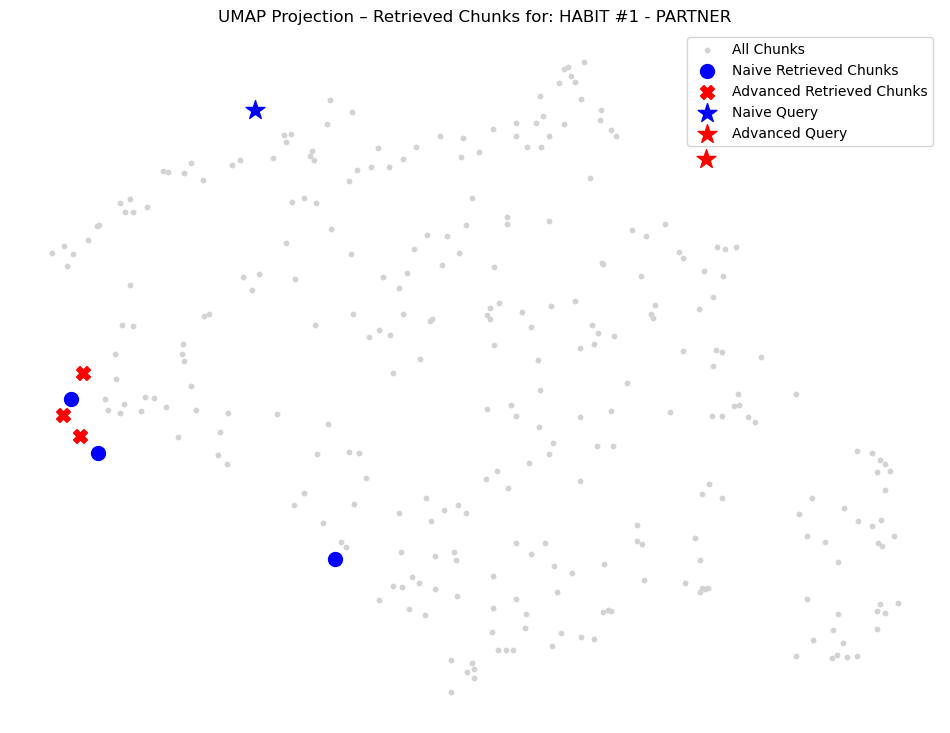

In [59]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Load all book embeddings
all_data = six_habits_collection.get(include=["embeddings"])
all_embeddings = np.array(all_data["embeddings"])
framework_key = "HABIT #1 - PARTNER"

# Fit UMAP on full dataset
umap_model = umap.UMAP(random_state=42)
projected_all = umap_model.fit_transform(all_embeddings)


# Get query and chunks from naive results
naive_data = naive_query_tracking[framework_key]
naive_query = naive_data["query"]
naive_chunks = naive_data["chunks"]
naive_emb_chunks = np.array(embedding_function(naive_chunks))
naive_proj_chunks = umap_model.transform(naive_emb_chunks)
naive_emb_query = np.array(embedding_function([naive_query]))
naive_proj_query = umap_model.transform(naive_emb_query)

# Get query and chunks from advanced results

adv_data = advanced_query_tracking[framework_key]
adv_query = adv_data["query"]
adv_chunks = adv_data["chunks"]
adv_emb_chunks = np.array(embedding_function(adv_chunks))
adv_proj_chunks = umap_model.transform(adv_emb_chunks)
adv_emb_query = np.array(embedding_function([adv_query]))
adv_proj_query = umap_model.transform(adv_emb_query)

# Plat everything
plt.figure(figsize=(12, 9))

# All background chunks
plt.scatter(projected_all[:, 0], projected_all[:, 1], s=10, color="lightgray", label="All Chunks")

# Retrieved Chunks
plt.scatter(naive_proj_chunks[:, 0], naive_proj_chunks[:, 1], s=100, color="blue", marker="o", label="Naive Retrieved Chunks")
plt.scatter(adv_proj_chunks[:, 0], adv_proj_chunks[:, 1], s=100, color="red", marker="X", label="Advanced Retrieved Chunks")

# Query Points
plt.scatter(naive_proj_query[:, 0], naive_proj_query[:, 1], s=200, color="blue", marker="*", label="Naive Query")
plt.scatter(adv_proj_query[:, 0], adv_proj_query[:, 1], s=200, color="red", marker="*", label="Advanced Query")

# Final touches
plt.title(f"UMAP Projection – Retrieved Chunks for: {framework_key}")
plt.axis("off")
plt.legend()
plt.show()


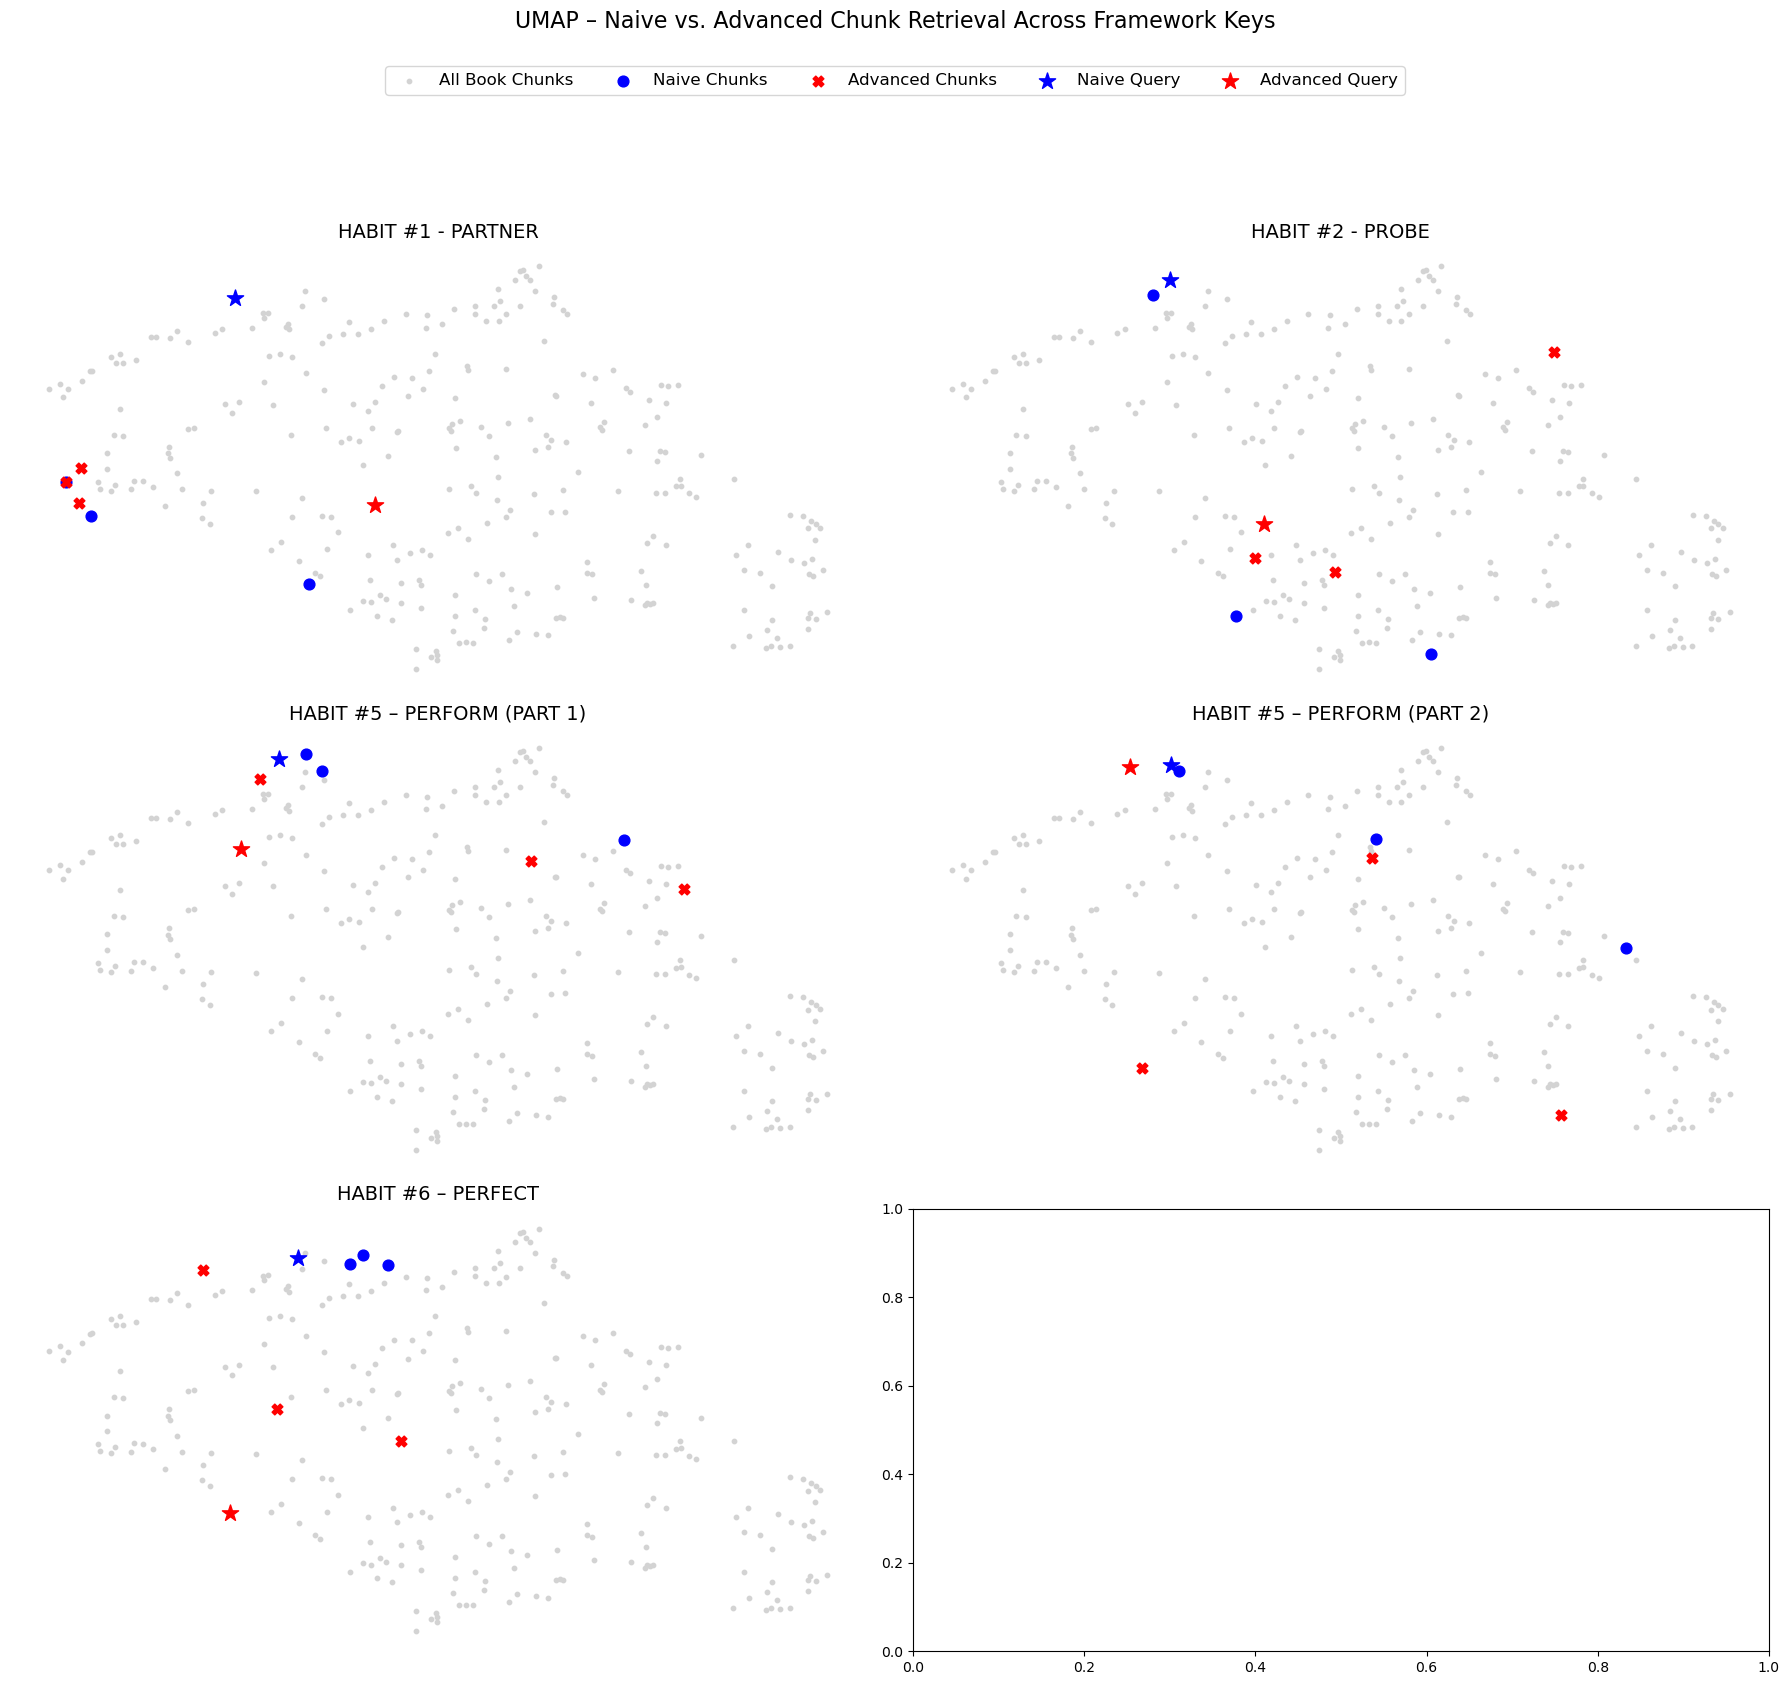

In [60]:
# Print all queries and chunks by scored habit.

framework_keys = list(advanced_query_tracking.keys())  # e.g., ["HABIT #1 - PARTNER", ...]

# Load and Project All Embeddings Once
all_data = six_habits_collection.get(include=["embeddings"])
all_embeddings = np.array(all_data["embeddings"])
umap_model = umap.UMAP(random_state=42)
projected_all = umap_model.fit_transform(all_embeddings)

# Create Grid for Plotting 
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 16))
axs = axs.flatten()

# Plot Each Habit
for i, framework_key in enumerate(framework_keys[:6]):  # Limit to first framework keys
    ax = axs[i]

    # Naive
    naive_data = naive_query_tracking[framework_key]
    naive_query = naive_data["query"]
    naive_chunks = naive_data["chunks"]
    naive_emb_chunks = np.array(embedding_function(naive_chunks))
    naive_proj_chunks = umap_model.transform(naive_emb_chunks)
    naive_emb_query = np.array(embedding_function([naive_query]))
    naive_proj_query = umap_model.transform(naive_emb_query)

    # Advanced
    adv_data = advanced_query_tracking[framework_key]
    adv_query = adv_data["query"]
    adv_chunks = adv_data["chunks"]
    adv_emb_chunks = np.array(embedding_function(adv_chunks))
    adv_proj_chunks = umap_model.transform(adv_emb_chunks)
    adv_emb_query = np.array(embedding_function([adv_query]))
    adv_proj_query = umap_model.transform(adv_emb_query)

    # Plot background
    ax.scatter(projected_all[:, 0], projected_all[:, 1], s=10, color="lightgray", label="All Book Chunks")

    # Plot retrieved chunks
    ax.scatter(naive_proj_chunks[:, 0], naive_proj_chunks[:, 1], s=60, color="blue", marker="o", label="Naive Chunks")
    ax.scatter(adv_proj_chunks[:, 0], adv_proj_chunks[:, 1], s=60, color="red", marker="X", label="Advanced Chunks")

    # Plot query points
    ax.scatter(naive_proj_query[:, 0], naive_proj_query[:, 1], s=150, color="blue", marker="*", label="Naive Query")
    ax.scatter(adv_proj_query[:, 0], adv_proj_query[:, 1], s=150, color="red", marker="*", label="Advanced Query")

    ax.set_title(framework_key, fontsize=14)
    ax.axis("off")

# Add a shared title
plt.suptitle(
    "UMAP – Naive vs. Advanced Chunk Retrieval Across Framework Keys",
    fontsize=16
)

# Add suptitle first
fig.suptitle("UMAP – Naive vs. Advanced Chunk Retrieval Across Framework Keys", fontsize=16, y=1.05)

# Add legend below the suptitle
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.02),  # slightly below the title
    ncol=5,
    fontsize=12
)

# Adjust layout to leave space at the top
plt.tight_layout(rect=[0, 0, 1, 0.95])  # [left, bottom, right, top]
plt.show()





#### 1.3.3 Advanced RAG Basic Evaluation

Here we are keeping track of latency, socre diff, score consistency and cost

In [61]:
# Get latency, cost and standard deviation for consistency - Advanced RAG - Score & Explanations
num_runs = 5
scores = []
latencies = []

# Track token usage
input_tokens_list = []
output_tokens_list = []

# Score diff tracking
score_diffs = []

for i in range(num_runs):
    print(f"\nRun {i+1}/{num_runs}")

    start_time = time()
    advanced_rag_results, advanced_usage, advanced_query_tracking = score_transcript_advanced(transcript, six_habits_collection, model=model_name)
    end_time = time()

    latency = round(end_time - start_time, 2)
    latencies.append(latency)

    # Track usage
    input_tokens_list.append(advanced_usage["prompt_tokens"])
    output_tokens_list.append(advanced_usage["completion_tokens"])

    # Extract scores from model and compute overall
    metric_scores = []
    run_score_diff = []

    for metric in advanced_rag_results:
        model_score = advanced_rag_results[metric].get("score")
        human_score = human_eval.get(metric, {}).get("score")

        if model_score is not None:
            metric_scores.append(model_score)

        if model_score is not None and human_score is not None:
            diff = abs(model_score - human_score)
            run_score_diff.append(diff)

    # After loop, get average
    if run_score_diff:
        avg_score_diff = round(sum(run_score_diff) / len(run_score_diff), 4)
    else:
        avg_score_diff = None

    # Store results
    if metric_scores:
        scores.append(sum(metric_scores) / len(metric_scores))

    if run_score_diff:
        score_diffs.append(sum(run_score_diff) / len(run_score_diff))

# Final metrics
consistency_std = round(np.std(scores), 4)
latency_seconds = round(np.mean(latencies), 2)
avg_input_tokens = round(np.mean(input_tokens_list), 2)
avg_output_tokens = round(np.mean(output_tokens_list), 2)
avg_score_diff = round(np.mean(score_diffs), 4) if score_diffs else None

# Output
print(f"\nOverall scores: {scores}")
print(f"Consistency (std deviation): {consistency_std}")
print(f"Average latency: {latency_seconds}")
print(f"Avg input tokens: {avg_input_tokens}")
print(f"Avg output tokens: {avg_output_tokens}")
print(f"Avg score_diff vs. human: {avg_score_diff}")


Run 1/5
Scoring with GPT, model name: gpt-3.5-turbo
Scoring with best practices for: HABIT #1 - PARTNER
Calling GPT with model: gpt-3.5-turbo
Retrieving 15 candidate chunks for re-ranking...
Re-ranking 15 chunks with LLM...
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Selected top 3 chunks after re-ranking.
Calling GPT with model: gpt-3.5-turbo
Scoring with best practices for: HABIT #2 - PROBE
Calling GPT with model: gpt-3.5-turbo
Retrieving 15 candidate chunks for re-r

In [62]:
# Update evaluation log with latency, consistency, token usage, and estimated cost

advanced_cost_usd = (avg_input_tokens*input_token_price_M/1000000)+(avg_output_tokens*output_token_price_M/1000000)

eval_log.loc[
    (eval_log["model_variant"] == model_variant) &
    (eval_log["output_type"] == "explanation") &
    (eval_log["transcript_name"] == transcript_name),
    ["score_diff","latency", "consistency", "input_tokens", "output_tokens", "input_token_price_M", "output_token_price_M","cost_usd"]
] = [
    avg_score_diff,
    round(latency_seconds, 2),
    round(consistency_std, 4),
    round(avg_input_tokens, 2),
    round(avg_output_tokens, 2),
    input_token_price_M,
    output_token_price_M,
    advanced_cost_usd
]


In [63]:
eval_log

,model_variant,model_name,output_type,transcript_name,context_precision,faithfulness,semantic_similarity,score_diff,consistency,latency,input_tokens,cached_input_tokens,input_token_price_M,cached_input_token_price_M,output_tokens,output_token_price_M,cost_usd
0,GPT Vanilla,gpt-3.5-turbo,explanation,anonymized call 01.txt,0.2167,0.13,0.8963,0.32,0.098,5.46,10171.0,None,0.5,None,318.4,1.5,0.005563
1,GPT Vanilla,gpt-3.5-turbo,feedback,anonymized call 01.txt,0.5167,0.3394,None,None,None,10.79,133.4,None,0.5,None,153.6,1.5,0.000297
2,GPT Naive RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,0.0463,0.8222,0.8577,0.176,0.1572,22.59,71237.4,None,0.5,None,1556.4,1.5,0.037953
3,GPT Naive RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,0.5333,0.7296,None,None,None,9.98,5102,None,0.5,None,713,1.5,0.00362
4,GPT Advanced RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,0.144,0.0824,67.09,77202.6,None,0.5,None,1765.6,1.5,0.04125
5,GPT Advanced RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
6,Gemini Advanced RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
7,Gemini Advanced RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
8,Gemini CAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
9,Gemini CAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None


In [64]:
#Advaced chunk retrieval
def get_enrichment_query_dynamic(explanation_text, metric_name, model=model_name):
    """
    Generate a semantic search query to retrieve book content that enriches feedback.
    """
    prompt = f"""
    You are helping retrieve coaching advice from a sales engineering playbook.

    Metric: "{metric_name}"

    Here is a brief explanation or feedback that needs enrichment:
    \"\"\"{explanation_text.strip()}\"\"\"

    Generate a concise semantic search query to find relevant best practices from the book to support this feedback:
    """
    if 'gemini' in model.lower():
        # It's a Gemini model, so we call the gemini-specific function
        # This assumes 'gemini_model' is set correctly beforehand
        result, _ = call_gemini(prompt=prompt, parse_json=False)
    else:
        # Otherwise, assume it's an OpenAI model and call the gpt-specific function
        result, _ = call_gpt(prompt, model=model, parse_json=False)
    
    
    return result.strip()


#Create prompts for each metric feedback - Advanced
def build_metric_coaching_prompts_adv_rag(explanations, collection, framework_name, max_chunks=3, model=model_name):
    print("Enriching the following metrics:", list(explanations.keys()))

    coaching_prompts = {}
    feedback_chunks_used = {}

    for metric, data in explanations.items():
        base_expl = data.get("explanation", "").strip()

        #Generate optimized query using GPT
        enriched_query = get_enrichment_query_dynamic(base_expl, metric, model=model)
        
        # Retrieve relevant book content (no filter, just similarity)
        chunk_results = collection.query(
            query_texts=[enriched_query],
            n_results=max_chunks
        )
        book_chunks = chunk_results["documents"][0]

        # Save raw chunks used
        feedback_chunks_used[metric] = book_chunks

        # Format retrieved chunks
        chunk_block = "".join([f"[{i+1}] {chunk.strip()}\n" for i, chunk in enumerate(book_chunks)])

        # Build enrichment prompt
        prompt = (
            "You are a sales engineering coach helping improve coaching feedback.\n\n"
            "Here is a current explanation or feedback:\n"
            f"{base_expl}\n\n"
            'Use the following best practices from the book "The Six Habits of Highly Effective Sales Engineers":\n'
            f"{chunk_block}\n"
            "Now, extend and enrich the feedback. Add a paragraph (100–150 words) that:\n"
            "- Elaborates on the key coaching points\n"
            "- Connects to specific habits or principles\n"
            "- Offers practical advice or encouragement\n\n"
            "Only append the new enriched paragraph. Do not repeat the original text."
        )

        coaching_prompts[metric] = prompt

    return coaching_prompts, feedback_chunks_used

In [65]:
coaching_prompts, feedback_chunks_used = build_metric_coaching_prompts_adv_rag(
    advanced_rag_results,
    six_habits_collection,
    framework_name,
    max_book_chunks
)

coaching_outputs = {}

for metric, prompt in coaching_prompts.items():
    enriched, usage = call_gpt(prompt, model=model_name, parse_json=False)
    enriched = enriched.strip()
    coaching_outputs[metric] = {
        "feedback": enriched,
        "feedback_chunks": feedback_chunks_used.get(metric, [])
    }


Enriching the following metrics: ['clarity', 'engagement', 'relevance', 'structure', 'confidence']
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo


In [66]:
coaching_outputs

{'clarity': {'feedback': 'One key coaching point to focus on is the importance of understanding how our solution will help customers solve their problems or meet their objectives. By emphasizing the value and benefits of the platform during software demonstrations, sales engineers can effectively engage customers and increase their chances of achieving a technical win. This aligns with the habit of "Understanding the Customer\'s Needs" from "The Six Habits of Highly Effective Sales Engineers." To put this into practice, sales engineers should actively listen to customers, ask probing questions, and tailor their demonstrations to address specific pain points or challenges. By demonstrating a deep understanding of the customer\'s needs and showcasing how the solution can solve their problems, sales engineers can build trust, credibility, and ultimately drive successful outcomes in their demos.',
  'feedback_chunks': ["how our solution will help them solve their problems or meet their obj

In [67]:
#latency and cost - Advanced RAG - feedback
coaching_outputs = {}
total_usage = {"prompt_tokens": 0, "completion_tokens": 0, "total_tokens": 0}


#Get Advanced latency
latency_seconds = 0
start_time = time()
print("\nlatency_seconds: ", latency_seconds) 

coaching_prompts, feedback_chunks_map =  build_metric_coaching_prompts_adv_rag(advanced_rag_results, six_habits_collection, framework_name, max_book_chunks)


for metric, prompt in coaching_prompts.items():
    enriched, usage = call_gpt(prompt, model=model_name, parse_json=False)

    # Track usage
    total_usage["prompt_tokens"] += usage.get("new_input_tokens", 0)
    total_usage["completion_tokens"] += usage.get("output_tokens", 0)
    total_usage["total_tokens"] += usage.get("new_input_tokens", 0)+usage.get("output_tokens", 0)

    
    coaching_outputs[metric] = {
        "text": enriched,
        "feedback_chunks": feedback_chunks_map[metric]
    }



end_time = time()
latency_seconds = round(end_time - start_time, 2)
print("\nlatency_seconds: ", latency_seconds) 


#Update latency for feedback
eval_log.loc[
    (eval_log["model_variant"] == model_variant) &
    (eval_log["output_type"] == "feedback") &
    (eval_log["transcript_name"] == transcript_name),
    "latency"
] = round(latency_seconds, 2)


for metric, coaching in coaching_outputs.items():
    print(f"{'-'*60}")
    print(f"-Metric: {metric.upper()}")
    print(f"{'-'*60}")
    print(coaching["text"].strip())

    



latency_seconds:  0
Enriching the following metrics: ['clarity', 'engagement', 'relevance', 'structure', 'confidence']
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo
Calling GPT with model: gpt-3.5-turbo

latency_seconds:  12.01
------------------------------------------------------------
-Metric: CLARITY
------------------------------------------------------------
One key coaching point to focus on is the importance of building a strong partnership with sales counterparts. This habit of collaboration and teamwork is essential for sales engineers to effectively communicate the value of the platform to customers and ultimately achieve the technical win. By working closely with sales colleagues, s

In [68]:
# Update evaluation log with latency, token usage, and estimated cost

advanced_cost_usd = (total_usage['prompt_tokens']*input_token_price_M/1000000)+(total_usage['completion_tokens']*output_token_price_M/1000000)


eval_log.loc[
    (eval_log["model_variant"] == model_variant) &
    (eval_log["output_type"] == "feedback") &
    (eval_log["transcript_name"] == transcript_name),
    ["latency", "input_tokens", "output_tokens", "input_token_price_M", "output_token_price_M", "cost_usd"]
] = [
    round(latency_seconds, 2),
    total_usage['prompt_tokens'],
    total_usage['completion_tokens'],
    input_token_price_M,
    output_token_price_M,
    advanced_cost_usd
]

In [69]:
eval_log

,model_variant,model_name,output_type,transcript_name,context_precision,faithfulness,semantic_similarity,score_diff,consistency,latency,input_tokens,cached_input_tokens,input_token_price_M,cached_input_token_price_M,output_tokens,output_token_price_M,cost_usd
0,GPT Vanilla,gpt-3.5-turbo,explanation,anonymized call 01.txt,0.2167,0.13,0.8963,0.32,0.098,5.46,10171.0,None,0.5,None,318.4,1.5,0.005563
1,GPT Vanilla,gpt-3.5-turbo,feedback,anonymized call 01.txt,0.5167,0.3394,None,None,None,10.79,133.4,None,0.5,None,153.6,1.5,0.000297
2,GPT Naive RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,0.0463,0.8222,0.8577,0.176,0.1572,22.59,71237.4,None,0.5,None,1556.4,1.5,0.037953
3,GPT Naive RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,0.5333,0.7296,None,None,None,9.98,5102,None,0.5,None,713,1.5,0.00362
4,GPT Advanced RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,0.144,0.0824,67.09,77202.6,None,0.5,None,1765.6,1.5,0.04125
5,GPT Advanced RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,12.01,5360,None,0.5,None,670,1.5,0.003685
6,Gemini Advanced RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
7,Gemini Advanced RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
8,Gemini CAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
9,Gemini CAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None


In [70]:
advanced_combined_outputs = {
    metric: {
        "score": advanced_rag_results[metric]["score"],
        "explanation": advanced_rag_results[metric]["explanation"],
        "explanation_chunks": advanced_rag_results[metric].get("explanation_chunks", []),
        "feedback": coaching_outputs[metric]["text"],
        "feedback_chunks": coaching_outputs[metric].get("feedback_chunks", [])
    }
    for metric in naive_rag_results.keys()
}
advanced_combined_outputs

{'clarity': {'score': 4.0,
  'explanation': 'The observations highlight the importance of clarity in communication during software demonstrations. It is crucial for sales engineers to effectively communicate the features and benefits of the platform to customers, ensuring that the message is clear and easy to understand. Additionally, developing a strong partnership with sales counterparts and conducting technical discovery calls are key practices to enhance the success of demos and ultimately achieve the technical win.',
  'explanation_chunks': ["the demonstration make a difference to you and your group? (As an example, if they are an insurance agency, will a demonstration that includes sample data from a fictitious manufacturing company make it difficult for them to follow?) 9. If so, do they have any sample data that they could provide to be included in the demonstration? 10. Are there specific capabilities that you're looking for? 11. Who's going to be in attendance? What are their

#### 1.3.3 Advanced RAG - RAGAS Evaluation

**Faithfulness, Context Precision and Semantic Similarity**
 
For the Advanced RAG model, Faithfulness Context precision and Semantic Similarity will be evaluated by comparing its outputs and used chunks from the book and human evaluation to compare. In theory, it should perform better than the Vanilla and Naive versions.

In [71]:
#Get RAGAS results for Naive RAG model
evaluate_with_ragas(
    results_and_chunks=advanced_combined_outputs,
    model_variant=model_variant,
    transcript_name=transcript_name,
    eval_log=eval_log,
    human_eval=human_eval  
)


--- Debugging first 'feedback' record for model 'GPT Advanced RAG' ---
Question: What feedback was given on clarity?

Answer: One key coaching point to focus on is the importance of building a strong partnership with sales counterparts. This habit of collaboration and teamwork is essential for sales engineers to effectively communicate the value of the platform to customers and ultimately achieve the technical win. By working closely with sales colleagues, sales engineers can align their messaging, address customer needs more effectively, and ensure a seamless transition from technical discovery calls to successful demos. Remember, success in sales engineering is not just about individual performance, but about working together as a cohesive team to drive results and deliver value to customers. Keep fostering those relationships and communication channels with your sales counterparts to maximize the impact of your demos and drive success in closing deals.

Contexts (Chunks):
  Chunk 1

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

...Evaluation successful.

Feedback scores:
  Faithfulness avg: 0.7139
  Context precision avg: 0.8167

--- Debugging first 'explanation' record for model 'GPT Advanced RAG' ---
Question: Why was the clarity score given?

Answer: The observations highlight the importance of clarity in communication during software demonstrations. It is crucial for sales engineers to effectively communicate the features and benefits of the platform to customers, ensuring that the message is clear and easy to understand. Additionally, developing a strong partnership with sales counterparts and conducting technical discovery calls are key practices to enhance the success of demos and ultimately achieve the technical win.

Contexts (Chunks):
  Chunk 1: the demonstration make a difference to you and your group? (As an example, if they are an insurance agency, will a demonstration that includes sample data from a fictitious manufacturing company make it difficult for them to follow?) 9. If so, do they have a

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

...Evaluation successful.

Explanation scores:
  Faithfulness avg: 0.8570
  Context precision avg: 0.3076
  Semantic similarity avg: 0.8380


In [72]:
eval_log

,model_variant,model_name,output_type,transcript_name,context_precision,faithfulness,semantic_similarity,score_diff,consistency,latency,input_tokens,cached_input_tokens,input_token_price_M,cached_input_token_price_M,output_tokens,output_token_price_M,cost_usd
0,GPT Vanilla,gpt-3.5-turbo,explanation,anonymized call 01.txt,0.2167,0.13,0.8963,0.32,0.098,5.46,10171.0,None,0.5,None,318.4,1.5,0.005563
1,GPT Vanilla,gpt-3.5-turbo,feedback,anonymized call 01.txt,0.5167,0.3394,None,None,None,10.79,133.4,None,0.5,None,153.6,1.5,0.000297
2,GPT Naive RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,0.0463,0.8222,0.8577,0.176,0.1572,22.59,71237.4,None,0.5,None,1556.4,1.5,0.037953
3,GPT Naive RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,0.5333,0.7296,None,None,None,9.98,5102,None,0.5,None,713,1.5,0.00362
4,GPT Advanced RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,0.3076,0.857,0.838,0.144,0.0824,67.09,77202.6,None,0.5,None,1765.6,1.5,0.04125
5,GPT Advanced RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,0.8167,0.7139,None,None,None,12.01,5360,None,0.5,None,670,1.5,0.003685
6,Gemini Advanced RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
7,Gemini Advanced RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
8,Gemini CAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
9,Gemini CAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None


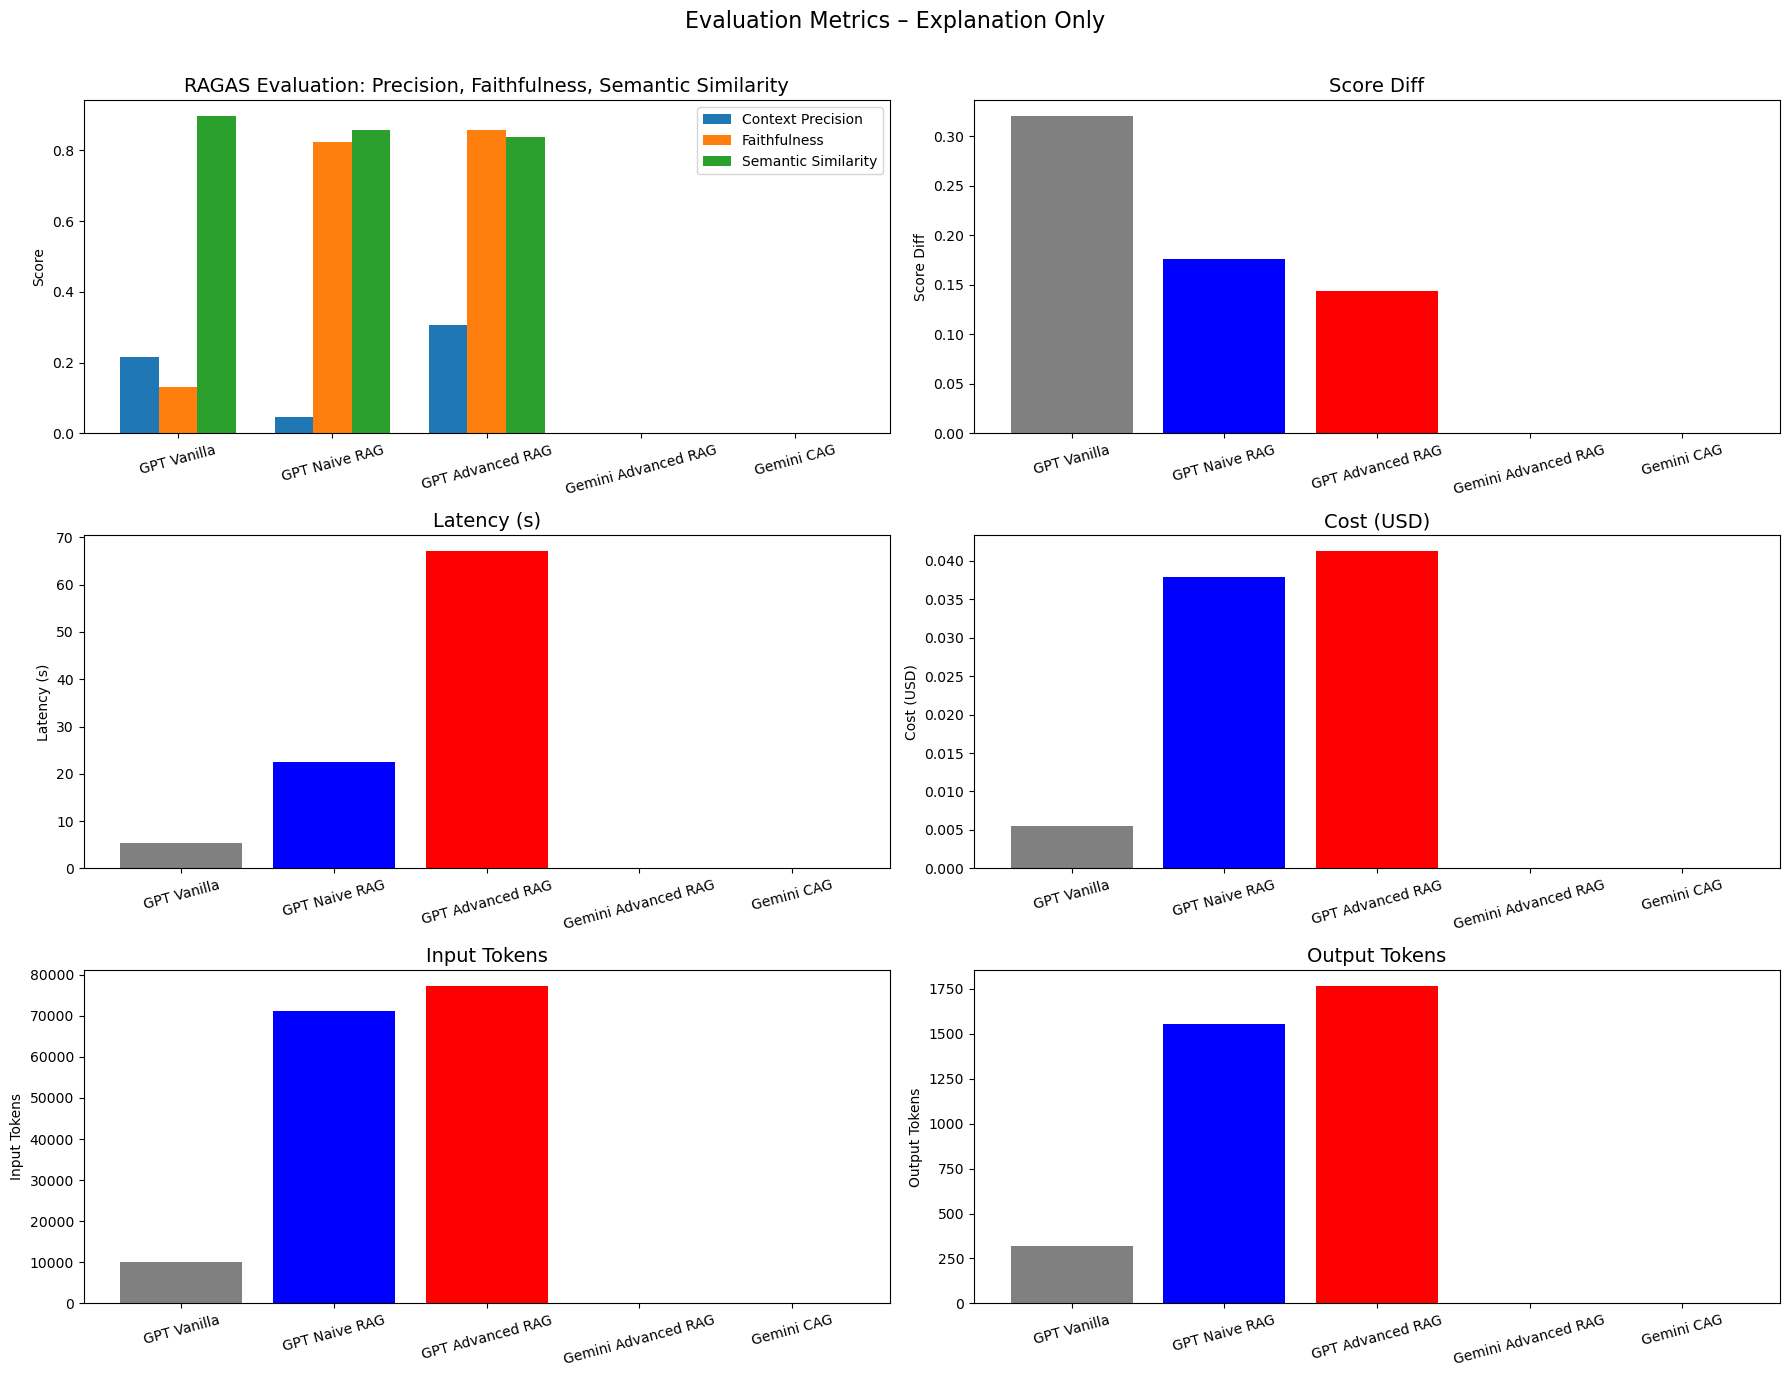

In [73]:
#Plot results for GPT - Explanation

# Filter only for "explanation"
eval_log_explanation = eval_log[eval_log["output_type"] == "explanation"]

# Model labels
model_labels = eval_log_explanation["model_variant"].tolist()

# Metrics for grouped bar chart
grouped_metrics = ["context_precision", "faithfulness", "semantic_similarity"]
grouped_titles = ["Context Precision", "Faithfulness", "Semantic Similarity"]

# Values for each metric
grouped_values = [eval_log_explanation[m].fillna(0).tolist() for m in grouped_metrics]

# Bar positions
x = np.arange(len(model_labels))  # e.g., 3 models
width = 0.25

# Create 3x2 grid
fig, axs = plt.subplots(3, 2, figsize=(18, 14))
axs = axs.flatten()

# Plot grouped bar chart in first position
ax0 = axs[0]
for i, values in enumerate(grouped_values):
    ax0.bar(x + i * width, values, width, label=grouped_titles[i])

ax0.set_title("RAGAS Evaluation: Precision, Faithfulness, Semantic Similarity", fontsize=14)
ax0.set_ylabel("Score")
ax0.set_xticks(x + width)
ax0.set_xticklabels(model_labels, rotation=15)
ax0.legend()

# Define other single metrics
other_metrics = [
    ("score_diff", "Score Diff"),
    ("latency", "Latency (s)"),
    ("cost_usd", "Cost (USD)"),
    ("input_tokens", "Input Tokens"),
    ("output_tokens", "Output Tokens"),
]

# Plot remaining metrics
for i, (metric, title) in enumerate(other_metrics, start=1):
    axs[i].bar(eval_log_explanation["model_variant"], eval_log_explanation[metric].fillna(0), color=["gray", "blue", "red"])
    axs[i].set_title(title, fontsize=14)
    axs[i].set_ylabel(title)
    axs[i].tick_params(axis='x', rotation=15)

# Global title and layout
plt.suptitle("Evaluation Metrics – Explanation Only", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


#### 1.4 Preliminary Evaluation Summary

The chart above shows how each GPT version performed when generating explanation outputs.

Advanced RAG showed improvements in faithfulness and context precision compared to the Naive version.

Vanilla GPT had lower context precision but maintained strong semantic similarity.

Token usage and cost increased with the more advanced techniques, as expected.

These are initial observations. A more detailed analysis will be provided in the final report, including examples, metric breakdowns, and qualitative insights for each version.

### 2 Google Gemini

#### 2.1 Gemini Advanced RAG

In this version, we continue embedding the evaluation and coaching framework, but apply a more advanced retrieval strategy. Instead of relying on naive queries, we enhance the quality of retrieved chunks by refining the search prompts and improving the semantic relevance of context. This aims to provide more targeted and faithful support for generating explanation and feedback outputs. It is the same approach we applied to the last version of GPT, so we can have so data to compare the same techinique with a different LLM.

In [74]:
#Set log key
model_variant = "Gemini Advanced RAG"

In [75]:
#Imports for specifics for this session
import google.generativeai as genai
from google.generativeai import caching
import datetime

In [76]:
#Setup Google GenAI Env
load_dotenv()
genai.configure(api_key=os.getenv("GEMINI_API_KEY"))
gemini_model_name = "gemini-1.5-flash-001"
gemini_model = genai.GenerativeModel(gemini_model_name)

#Prices for gemini-1.5-flash
google_input_token_price_M = 0.075 # $0.075 per 1M tokens, prompts <= 128k tokens
google_cached_input_token_price_M = 0.01875 #$0.01875 per 1M tokens, prompts <= 128k tokens 
#Cached content also charges 1USD per 1M tokens stores per hour, ignoring it for now
google_output_token_price_M = 0.3 # $0.30 per 1M tokens, prompts <= 128k tokens

In [77]:
prompt = "Do you know the full content of the The Six Habits of Highly Effective Sales Engineers now?"
response = gemini_model.generate_content(prompt)
print(response.text)

Unfortunately, there isn't a book or resource titled "The Six Habits of Highly Effective Sales Engineers" that I'm aware of.  

It's likely you're thinking of something similar, like the classic "The 7 Habits of Highly Effective People" by Stephen Covey, which addresses general effectiveness, not specifically sales engineering.

If you can provide more context, like:

* **The author's name:** Who wrote this?
* **Where did you encounter this title?** 
* **Any other key phrases or keywords?**

I can do a better job of finding the information you're looking for! 



In [78]:
def call_gemini(prompt, parse_json=True):
    """
    Calls the Gemini model. If a 'cached_content_name' is provided,
    it leverages the cache. Otherwise, it performs a standard, non-cached call.
    """
    print(f"Calling gemini with model: {gemini_model_name}")
    
    try:
        response = gemini_model.generate_content(
            prompt,
            generation_config=genai.types.GenerationConfig(
                temperature=llm_temperature,
                top_p = llm_top_p
            )
        )

        reply = response.text # Accessing text directly

        # Token usage from response metadata
        new_input_tokens = 0
        cached_input_tokens = 0
        output_tokens = 0

        
        cached_input_tokens = response.usage_metadata.cached_content_token_count or 0
        new_input_tokens = response.usage_metadata.prompt_token_count - cached_input_tokens
        output_tokens = response.usage_metadata.candidates_token_count #default candidates = 1

        usage = {
            "new_input_tokens": new_input_tokens,
            "cached_input_tokens": cached_input_tokens,
            "output_tokens": output_tokens
        }

        #Check if return jason or text
        if not parse_json:
            return reply.strip(), usage

        try:

            cleaned_reply = reply.strip()
            if cleaned_reply.startswith("```json"):
                cleaned_reply = cleaned_reply[7:]
            if cleaned_reply.endswith("```"):
                cleaned_reply = cleaned_reply[:-3]

            return json.loads(cleaned_reply), usage
        except json.JSONDecodeError:
            print("Gemini returned invalid JSON:\n", reply)
            return None, usage

    except Exception as e:
        # This error handling remains the same.
        print(f"An error occurred while calling Gemini: {e}")
        usage = {"new_input_tokens": 0, "cached_input_tokens": 0, "output_tokens": 0}
        if hasattr(e, 'response') and e.response: # For google.api_core.exceptions
             print(f"Error details: {e.response}")
        return None, usage

In [79]:
gemini_advanced_rag_results, gemini_advanced_usage, gemini_advanced_query_tracking = score_transcript_advanced(transcript, six_habits_collection, model=gemini_model_name)

Scoring with gemini, model name: gemini-1.5-flash-001
Scoring with best practices for: HABIT #1 - PARTNER
Calling gemini with model: gemini-1.5-flash-001
Retrieving 15 candidate chunks for re-ranking...
Re-ranking 15 chunks with LLM...
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Selected top 3 chunks after re-ranking.
Call

In [80]:
gemini_advanced_rag_results

{'clarity': {'score': 3.0,
  'explanation': "Luiz's explanations of the platform's features were generally clear, but he sometimes struggled to articulate complex concepts concisely and used jargon that might not be familiar to all customers. He also tended to get bogged down in technical details, jump ahead, or speak quickly, which could have made it difficult for the customer to follow along. He didn't always connect technical details back to the customer's needs or fully explain the relevance of concepts like ELT and integrations.",
  'explanation_chunks': ['Always circle back with your sales counterpart after the demo. Not only are you perfecting the demo, but you\'re improving the team\'s overall approach. You\'re also proactively working on building the relationship. This will pay dividends down the road, in terms of your collective performance together in front of a customer and in terms of your own success. The better relationship you have with your sales teams, the more deals 

In [81]:
gemini_advanced_usage

{'prompt_tokens': 83205, 'completion_tokens': 2375, 'total_tokens': 85580}

In [82]:
gemini_advanced_query_tracking

{'HABIT #1 - PARTNER': {'query': 'Query: "Coaching content on partnership in sales engineering demos, focusing on demonstrating value and collaboration with the customer."',
  'chunks': ['So, what are we to do? How do we adopt and develop Habit #1 to PARTNER with our sales counterparts? There are three things we need to do, a) get your mindset right, b) clarify roles and responsibilities, and c) follow a process. Sales is a Team Sport The first thing we need to do to develop this habit is to change our mindset. Sales is a team sport . It is not an individual sport. Yes, you are going to be looked at for individual performance. You will very likely not have a team of people reporting to you. However, you need to think of yourself as part of a team, particularly those of you who sell enterprise software, or complex technical solutions. The more complex the technology or broad the solution, the more likely you will find yourself working with multiple sales reps. You might even find yourse

#### 2.1.1 Comparing naive and advanced RAG unsing GTP and Advanced RAG using Gemini retrieval unsing UMAP.

The embedding we use has many dimensions, but UMAP helps reduce it to just two. While this isn’t perfect, it gives us a visual idea of how close the query is to the retrieved chunks. This can be a sign of better retrieval — with more relevant content. The most important evaluation still comes from RAGAS metrics like Semantic Similarity, Faithfulness, and Context Precision, but this is still an interesting comparison to explore.

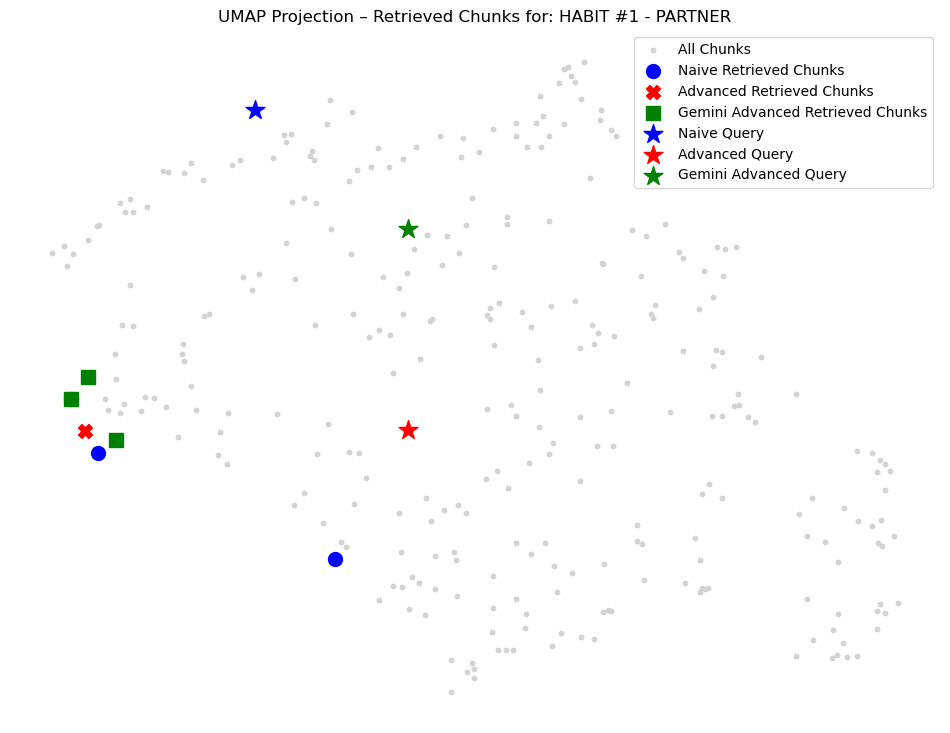

In [83]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Load all book embeddings
all_data = six_habits_collection.get(include=["embeddings"])
all_embeddings = np.array(all_data["embeddings"])
framework_key = "HABIT #1 - PARTNER"

# Fit UMAP on full dataset
umap_model = umap.UMAP(random_state=42)
projected_all = umap_model.fit_transform(all_embeddings)


# Get query and chunks from naive results
naive_data = naive_query_tracking[framework_key]
naive_query = naive_data["query"]
naive_chunks = naive_data["chunks"]
naive_emb_chunks = np.array(embedding_function(naive_chunks))
naive_proj_chunks = umap_model.transform(naive_emb_chunks)
naive_emb_query = np.array(embedding_function([naive_query]))
naive_proj_query = umap_model.transform(naive_emb_query)

# Get query and chunks from advanced results

adv_data = advanced_query_tracking[framework_key]
adv_query = adv_data["query"]
adv_chunks = adv_data["chunks"]
adv_emb_chunks = np.array(embedding_function(adv_chunks))
adv_proj_chunks = umap_model.transform(adv_emb_chunks)
adv_emb_query = np.array(embedding_function([adv_query]))
adv_proj_query = umap_model.transform(adv_emb_query)



# Get query and chunks from advanced results - Gemini

g_adv_data = gemini_advanced_query_tracking[framework_key]
g_adv_query = g_adv_data["query"]
g_adv_chunks = g_adv_data["chunks"]
g_adv_emb_chunks = np.array(embedding_function(g_adv_chunks))
g_adv_proj_chunks = umap_model.transform(g_adv_emb_chunks)
g_adv_emb_query = np.array(embedding_function([g_adv_query]))
g_adv_proj_query = umap_model.transform(g_adv_emb_query)

# Plat everything
plt.figure(figsize=(12, 9))

# All background chunks
plt.scatter(projected_all[:, 0], projected_all[:, 1], s=10, color="lightgray", label="All Chunks")

# Retrieved Chunks
plt.scatter(naive_proj_chunks[:, 0], naive_proj_chunks[:, 1], s=100, color="blue", marker="o", label="Naive Retrieved Chunks")
plt.scatter(adv_proj_chunks[:, 0], adv_proj_chunks[:, 1], s=100, color="red", marker="X", label="Advanced Retrieved Chunks")
plt.scatter(g_adv_proj_chunks[:, 0], g_adv_proj_chunks[:, 1], s=100, color="green", marker="s", label="Gemini Advanced Retrieved Chunks")

# Query Points
plt.scatter(naive_proj_query[:, 0], naive_proj_query[:, 1], s=200, color="blue", marker="*", label="Naive Query")
plt.scatter(adv_proj_query[:, 0], adv_proj_query[:, 1], s=200, color="red", marker="*", label="Advanced Query")
plt.scatter(adv_proj_query[:, 0], g_adv_proj_query[:, 1], s=200, color="green", marker="*", label="Gemini Advanced Query")

# Final touches
plt.title(f"UMAP Projection – Retrieved Chunks for: {framework_key}")
plt.axis("off")
plt.legend()
plt.show()


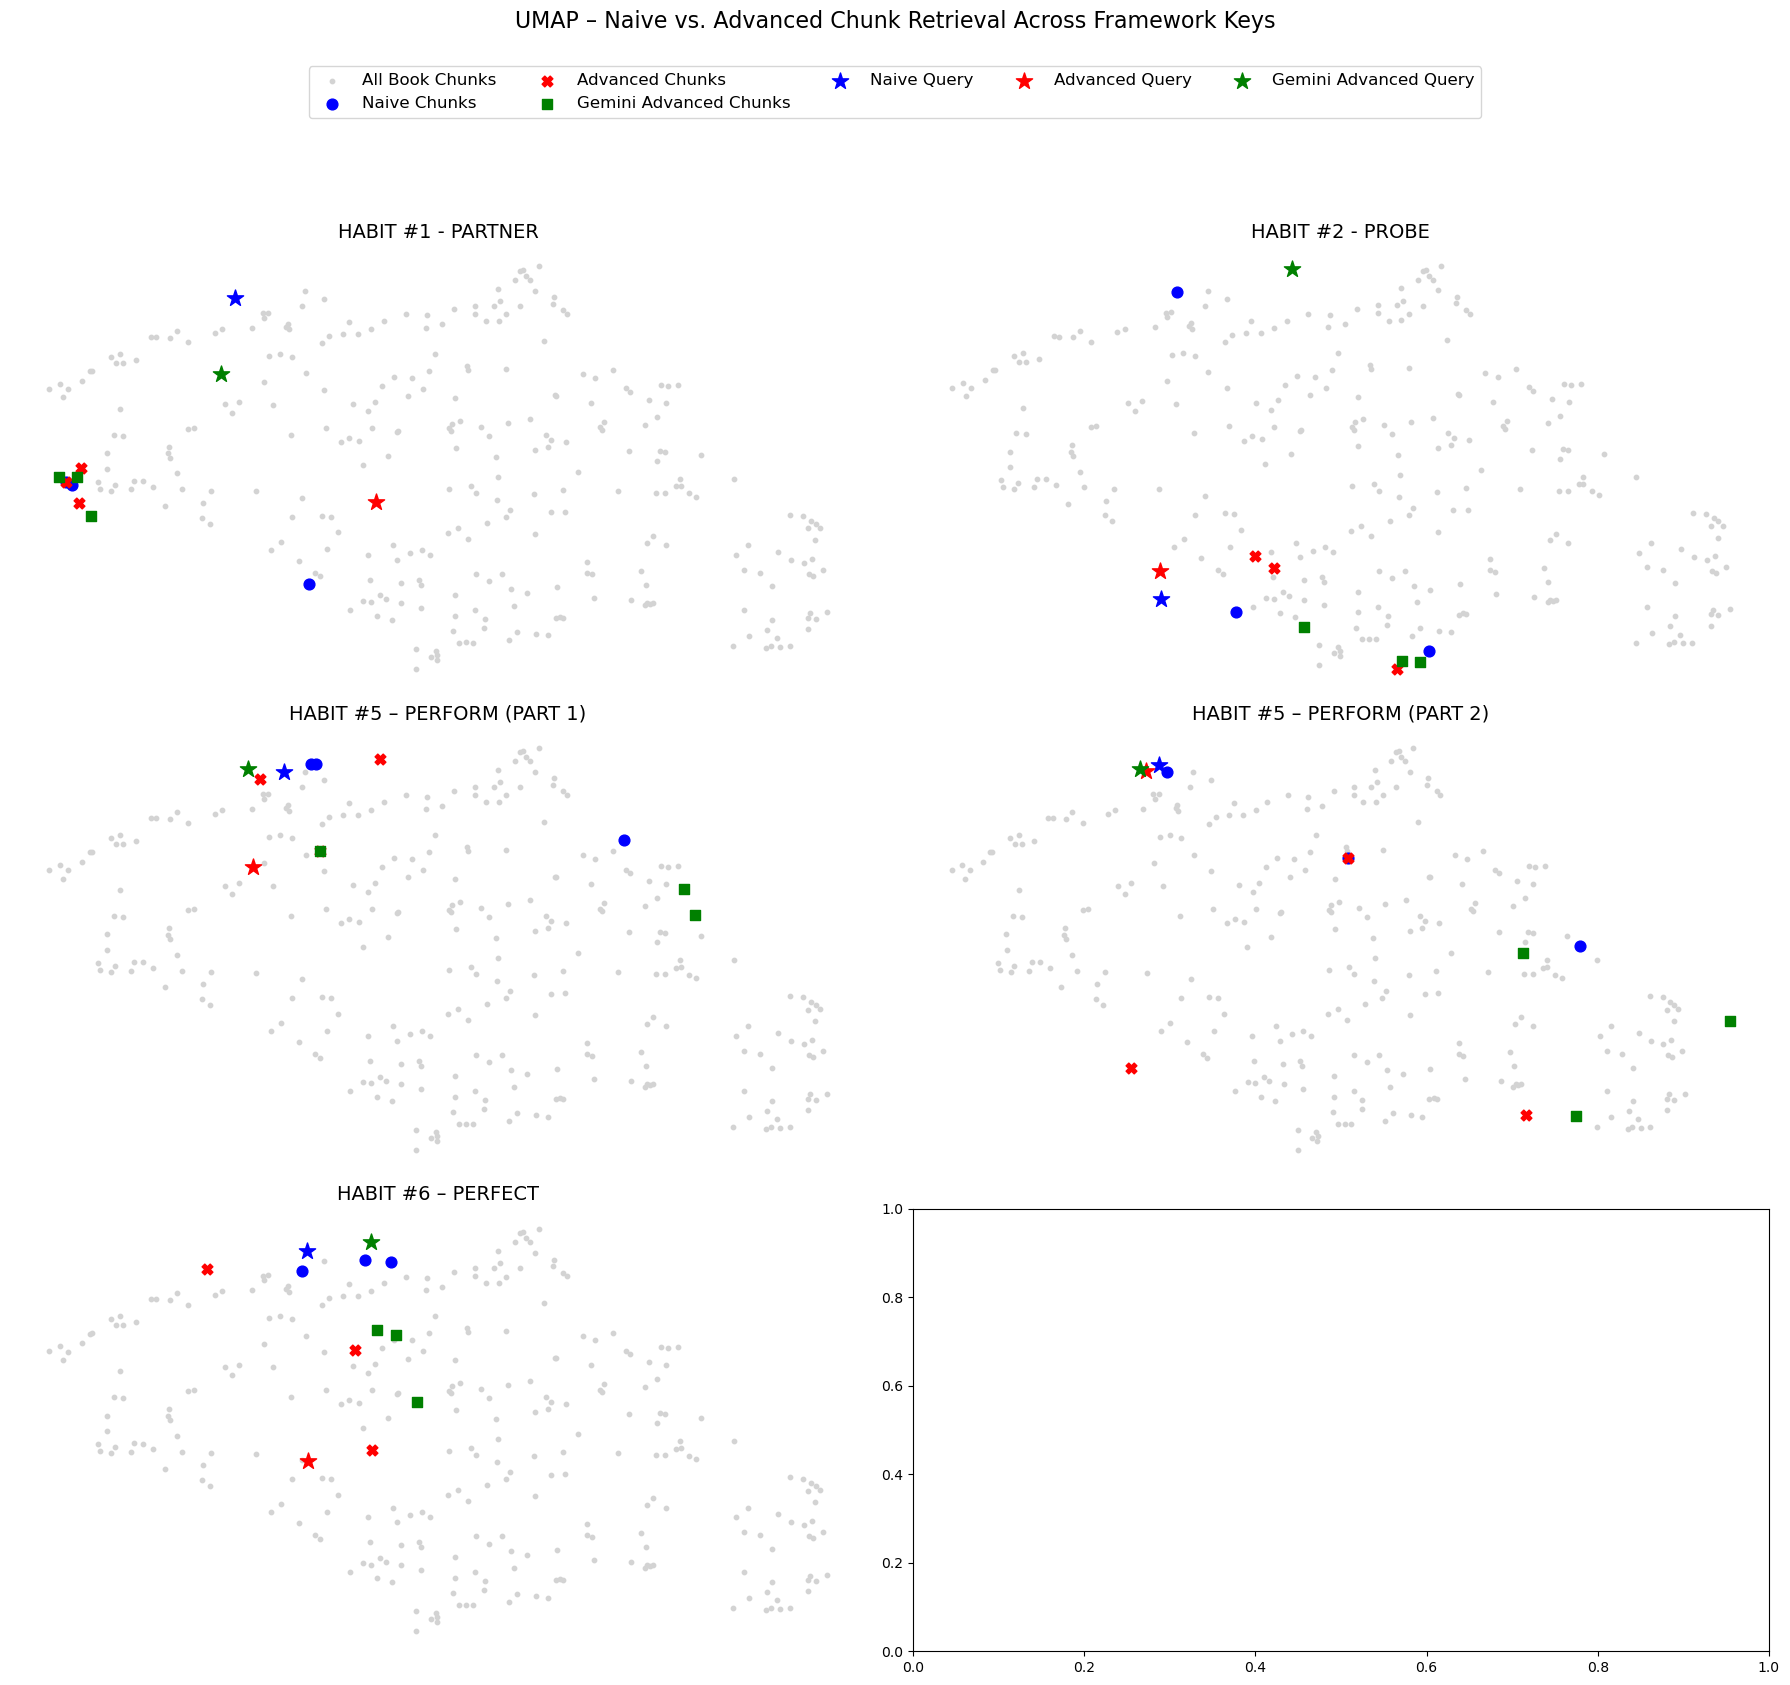

In [84]:
# Print all queries and chunks by scored habit.

framework_keys = list(advanced_query_tracking.keys())  

# Load and Project All Embeddings Once
all_data = six_habits_collection.get(include=["embeddings"])
all_embeddings = np.array(all_data["embeddings"])
umap_model = umap.UMAP(random_state=42)
projected_all = umap_model.fit_transform(all_embeddings)

# Create Grid for Plotting 
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 16))
axs = axs.flatten()

# Plot Each Habit
for i, framework_key in enumerate(framework_keys[:6]):  # Limit to first framework keys
    ax = axs[i]

    # Naive
    naive_data = naive_query_tracking[framework_key]
    naive_query = naive_data["query"]
    naive_chunks = naive_data["chunks"]
    naive_emb_chunks = np.array(embedding_function(naive_chunks))
    naive_proj_chunks = umap_model.transform(naive_emb_chunks)
    naive_emb_query = np.array(embedding_function([naive_query]))
    naive_proj_query = umap_model.transform(naive_emb_query)

    # Advanced
    adv_data = advanced_query_tracking[framework_key]
    adv_query = adv_data["query"]
    adv_chunks = adv_data["chunks"]
    adv_emb_chunks = np.array(embedding_function(adv_chunks))
    adv_proj_chunks = umap_model.transform(adv_emb_chunks)
    adv_emb_query = np.array(embedding_function([adv_query]))
    adv_proj_query = umap_model.transform(adv_emb_query)

    # Advanced - gemini
    g_adv_data = gemini_advanced_query_tracking[framework_key]
    g_adv_query = g_adv_data["query"]
    g_adv_chunks = g_adv_data["chunks"]
    g_adv_emb_chunks = np.array(embedding_function(g_adv_chunks))
    g_adv_proj_chunks = umap_model.transform(g_adv_emb_chunks)
    g_adv_emb_query = np.array(embedding_function([g_adv_query]))
    g_adv_proj_query = umap_model.transform(g_adv_emb_query)

    # Plot background
    ax.scatter(projected_all[:, 0], projected_all[:, 1], s=10, color="lightgray", label="All Book Chunks")

    # Plot retrieved chunks
    ax.scatter(naive_proj_chunks[:, 0], naive_proj_chunks[:, 1], s=60, color="blue", marker="o", label="Naive Chunks")
    ax.scatter(adv_proj_chunks[:, 0], adv_proj_chunks[:, 1], s=60, color="red", marker="X", label="Advanced Chunks")
    ax.scatter(g_adv_proj_chunks[:, 0], g_adv_proj_chunks[:, 1], s=60, color="green", marker="s", label="Gemini Advanced Chunks")
    

    # Plot query points
    ax.scatter(naive_proj_query[:, 0], naive_proj_query[:, 1], s=150, color="blue", marker="*", label="Naive Query")
    ax.scatter(adv_proj_query[:, 0], adv_proj_query[:, 1], s=150, color="red", marker="*", label="Advanced Query")
    ax.scatter(g_adv_proj_query[:, 0], g_adv_proj_query[:, 1], s=150, color="green", marker="*", label="Gemini Advanced Query")

    ax.set_title(framework_key, fontsize=14)
    ax.axis("off")

# Add a shared title
plt.suptitle(
    "UMAP – Naive vs. Advanced Chunk Retrieval Across Framework Keys",
    fontsize=16
)

# Add suptitle first
fig.suptitle("UMAP – Naive vs. Advanced Chunk Retrieval Across Framework Keys", fontsize=16, y=1.05)

# Add legend below the suptitle
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.02),  # slightly below the title
    ncol=5,
    fontsize=12
)

# Adjust layout to leave space at the top
plt.tight_layout(rect=[0, 0, 1, 0.95])  # [left, bottom, right, top]
plt.show()





#### 2.1.2 Gemini Advanced RAG Basic Evaluation

Here we are keeping track of latency, socre diff, score consistency and cost

In [85]:
# Get latency, cost and standard deviation for consistency - Gemini Advanced RAG - Score & Explanations
num_runs = 5
scores = []
latencies = []

# Track token usage
input_tokens_list = []
output_tokens_list = []

# Score diff tracking
score_diffs = []

for i in range(num_runs):
    print(f"\nRun {i+1}/{num_runs}")

    start_time = time()
    gemini_advanced_rag_results, gemini_advanced_usage, gemini_advanced_query_tracking = score_transcript_advanced(transcript, six_habits_collection, model=gemini_model_name)
    end_time = time()

    latency = round(end_time - start_time, 2)
    latencies.append(latency)

    # Track usage
    input_tokens_list.append(gemini_advanced_usage["prompt_tokens"])
    output_tokens_list.append(gemini_advanced_usage["completion_tokens"])

    # Extract scores from model and compute overall
    metric_scores = []
    run_score_diff = []

    for metric in gemini_advanced_rag_results:
        model_score = gemini_advanced_rag_results[metric].get("score")
        human_score = human_eval.get(metric, {}).get("score")

        if model_score is not None:
            metric_scores.append(model_score)

        if model_score is not None and human_score is not None:
            diff = abs(model_score - human_score)
            run_score_diff.append(diff)

    # After loop, get average
    if run_score_diff:
        avg_score_diff = round(sum(run_score_diff) / len(run_score_diff), 4)
    else:
        avg_score_diff = None

    # Store results
    if metric_scores:
        scores.append(sum(metric_scores) / len(metric_scores))

    if run_score_diff:
        score_diffs.append(sum(run_score_diff) / len(run_score_diff))

# Final metrics
consistency_std = round(np.std(scores), 4)
latency_seconds = round(np.mean(latencies), 2)
avg_input_tokens = round(np.mean(input_tokens_list), 2)
avg_output_tokens = round(np.mean(output_tokens_list), 2)
avg_score_diff = round(np.mean(score_diffs), 4) if score_diffs else None

# Output
print(f"\nOverall scores: {scores}")
print(f"Consistency (std deviation): {consistency_std}")
print(f"Average latency: {latency_seconds}")
print(f"Avg input tokens: {avg_input_tokens}")
print(f"Avg output tokens: {avg_output_tokens}")
print(f"Avg score_diff vs. human: {avg_score_diff}")


Run 1/5
Scoring with gemini, model name: gemini-1.5-flash-001
Scoring with best practices for: HABIT #1 - PARTNER
Calling gemini with model: gemini-1.5-flash-001
Retrieving 15 candidate chunks for re-ranking...
Re-ranking 15 chunks with LLM...
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Selected top 3 chunks after re-rank

In [86]:
# Update evaluation log with latency, consistency, token usage, and estimated cost

g_adv_cost_usd = (avg_input_tokens*google_input_token_price_M/1000000)
+(avg_output_tokens*google_output_token_price_M/1000000)


eval_log.loc[
    (eval_log["model_variant"] == model_variant) &
    (eval_log["output_type"] == "explanation") &
    (eval_log["transcript_name"] == transcript_name),
    ["model_name","score_diff","latency", "consistency", "input_tokens", "output_tokens", "input_token_price_M", "output_token_price_M","cost_usd"]
] = [
    gemini_model_name,
    avg_score_diff,
    round(latency_seconds, 2),
    round(consistency_std, 4),
    round(avg_input_tokens, 2),
    round(avg_output_tokens, 2),
    google_input_token_price_M,
    google_output_token_price_M,
    g_adv_cost_usd
]
eval_log

,model_variant,model_name,output_type,transcript_name,context_precision,faithfulness,semantic_similarity,score_diff,consistency,latency,input_tokens,cached_input_tokens,input_token_price_M,cached_input_token_price_M,output_tokens,output_token_price_M,cost_usd
0,GPT Vanilla,gpt-3.5-turbo,explanation,anonymized call 01.txt,0.2167,0.13,0.8963,0.32,0.098,5.46,10171.0,None,0.5,None,318.4,1.5,0.005563
1,GPT Vanilla,gpt-3.5-turbo,feedback,anonymized call 01.txt,0.5167,0.3394,None,None,None,10.79,133.4,None,0.5,None,153.6,1.5,0.000297
2,GPT Naive RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,0.0463,0.8222,0.8577,0.176,0.1572,22.59,71237.4,None,0.5,None,1556.4,1.5,0.037953
3,GPT Naive RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,0.5333,0.7296,None,None,None,9.98,5102,None,0.5,None,713,1.5,0.00362
4,GPT Advanced RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,0.3076,0.857,0.838,0.144,0.0824,67.09,77202.6,None,0.5,None,1765.6,1.5,0.04125
5,GPT Advanced RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,0.8167,0.7139,None,None,None,12.01,5360,None,0.5,None,670,1.5,0.003685
6,Gemini Advanced RAG,gemini-1.5-flash-001,explanation,anonymized call 01.txt,None,None,None,0.744,0.032,154.03,83143.4,None,0.075,None,2320.6,0.3,0.006236
7,Gemini Advanced RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
8,Gemini CAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
9,Gemini CAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None


In [87]:
coaching_prompts, feedback_chunks_used = build_metric_coaching_prompts_adv_rag(
    gemini_advanced_rag_results,
    six_habits_collection,
    framework_name,
    max_book_chunks,
    gemini_model_name
)

coaching_outputs = {}

for metric, prompt in coaching_prompts.items():
    enriched, usage = call_gemini(prompt, parse_json=False)
    enriched = enriched.strip()
    coaching_outputs[metric] = {
        "feedback": enriched,
        "feedback_chunks": feedback_chunks_used.get(metric, [])
    }


Enriching the following metrics: ['clarity', 'engagement', 'relevance', 'structure', 'confidence']
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001


In [88]:
coaching_outputs

{'clarity': {'feedback': 'Luiz, your technical knowledge is strong, but remember that your goal is to connect with the customer, not just showcase your expertise.  Focus on understanding their needs and challenges first.  This means asking open-ended questions that probe deeper into their objectives and requirements, rather than jumping into technical details.  Think of it like building a bridge between their world and your solution.  By understanding their "Ah-Ha" moments, you can tailor your explanations to resonate with them and make the technical concepts clear and relevant.  Remember, "A Confused Mind Always Says NO," so take your time, use clear language, and ensure you\'re connecting the dots for the customer.  This will help you build trust and ultimately lead to a successful technical win.',
  'feedback_chunks': ['Don\'t Assume They Understand Your Terminology Please Slow Down A Confused Mind Always Says NO Know Your "Ah-Ha" Moments Be Yourself Habit #5 - Perform (part 2) Gett

In [89]:
#latency and cost - Gemini Advanced RAG - feedback
coaching_outputs = {}
total_usage = {"new_input_tokens": 0, "output_tokens": 0, "total_tokens": 0}


#Get Advanced latency
latency_seconds = 0
start_time = time()
print("\nlatency_seconds: ", latency_seconds) 

coaching_prompts, feedback_chunks_used = build_metric_coaching_prompts_adv_rag(
    gemini_advanced_rag_results,
    six_habits_collection,
    framework_name,
    max_book_chunks,
    gemini_model_name
)

for metric, prompt in coaching_prompts.items():
    enriched, usage = call_gemini(prompt, parse_json=False)

    # Track usage
    total_usage["new_input_tokens"] += usage.get("new_input_tokens", 0)
    total_usage["output_tokens"] += usage.get("output_tokens", 0)
    total_usage["total_tokens"] += usage.get("new_input_tokens", 0)+usage.get("output_tokens", 0)

    
    coaching_outputs[metric] = {
        "text": enriched,
        "feedback_chunks": feedback_chunks_map[metric]
    }



end_time = time()
latency_seconds = round(end_time - start_time, 2)
print("\nlatency_seconds: ", latency_seconds) 


#Update latency for feedback
eval_log.loc[
    (eval_log["model_variant"] == model_variant) &
    (eval_log["output_type"] == "feedback") &
    (eval_log["transcript_name"] == transcript_name),
    "latency"
] = round(latency_seconds, 2)


for metric, coaching in coaching_outputs.items():
    print(f"{'-'*60}")
    print(f"-Metric: {metric.upper()}")
    print(f"{'-'*60}")
    print(coaching["text"].strip())

    



latency_seconds:  0
Enriching the following metrics: ['clarity', 'engagement', 'relevance', 'structure', 'confidence']
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001

latency_seconds:  9.58
------------------------------------------------------------
-Metric: CLARITY
------------------------------------------------------------
Luiz, your technical knowledge is strong, but remember that your goal is to connect with the customer, not just showcase your expertise.  Focus on understanding their needs and challenges first.  This means asking open-ended questions th

In [90]:
coaching_outputs

{'clarity': {'text': 'Luiz, your technical knowledge is strong, but remember that your goal is to connect with the customer, not just showcase your expertise.  Focus on understanding their needs and challenges first.  This means asking open-ended questions that probe deeper into their objectives and requirements, rather than jumping into technical details.  Think of it like building a bridge between their world and your solution.  By understanding their "Ah-Ha" moments, you can tailor your explanations to resonate with them and make the technical concepts clear and relevant.  Remember, "A Confused Mind Always Says NO," so take your time, use clear language, and ensure you\'re connecting the dots for the customer.  This will help you build trust and ultimately lead to a successful technical win.',
  'feedback_chunks': ["how our solution will help them solve their problems or meet their objectives. It's our job to get them to say YES. What I have learned (and seen) over the years is that

In [91]:
# Update evaluation log with latency, consistency, token usage, and estimated cost - feeback

g_adv_cost_usd = (total_usage["new_input_tokens"]*google_input_token_price_M/1000000)
+(total_usage["output_tokens"]*google_output_token_price_M/1000000)

eval_log.loc[
    (eval_log["model_variant"] == model_variant) &
    (eval_log["output_type"] == "feedback") &
    (eval_log["transcript_name"] == transcript_name),
    ["model_name","latency", "input_tokens","output_tokens", "input_token_price_M", "output_token_price_M","cost_usd"]
] = [
    gemini_model_name,
    round(latency_seconds, 2),
    total_usage["new_input_tokens"],   
    total_usage["output_tokens"],
    google_input_token_price_M,
    google_output_token_price_M,
    g_adv_cost_usd
]
eval_log

,model_variant,model_name,output_type,transcript_name,context_precision,faithfulness,semantic_similarity,score_diff,consistency,latency,input_tokens,cached_input_tokens,input_token_price_M,cached_input_token_price_M,output_tokens,output_token_price_M,cost_usd
0,GPT Vanilla,gpt-3.5-turbo,explanation,anonymized call 01.txt,0.2167,0.13,0.8963,0.32,0.098,5.46,10171.0,None,0.5,None,318.4,1.5,0.005563
1,GPT Vanilla,gpt-3.5-turbo,feedback,anonymized call 01.txt,0.5167,0.3394,None,None,None,10.79,133.4,None,0.5,None,153.6,1.5,0.000297
2,GPT Naive RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,0.0463,0.8222,0.8577,0.176,0.1572,22.59,71237.4,None,0.5,None,1556.4,1.5,0.037953
3,GPT Naive RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,0.5333,0.7296,None,None,None,9.98,5102,None,0.5,None,713,1.5,0.00362
4,GPT Advanced RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,0.3076,0.857,0.838,0.144,0.0824,67.09,77202.6,None,0.5,None,1765.6,1.5,0.04125
5,GPT Advanced RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,0.8167,0.7139,None,None,None,12.01,5360,None,0.5,None,670,1.5,0.003685
6,Gemini Advanced RAG,gemini-1.5-flash-001,explanation,anonymized call 01.txt,None,None,None,0.744,0.032,154.03,83143.4,None,0.075,None,2320.6,0.3,0.006236
7,Gemini Advanced RAG,gemini-1.5-flash-001,feedback,anonymized call 01.txt,None,None,None,None,None,9.58,5360,None,0.075,None,689,0.3,0.000402
8,Gemini CAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
9,Gemini CAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None


In [92]:
# This combines the initial scores/explanations with the final enriched feedback - Gemini Advanced Version

g_adv_rag_combined_outputs = {
    metric: {
        "score": gemini_advanced_rag_results[metric]["score"],
        "explanation": gemini_advanced_rag_results[metric]["explanation"],
        "explanation_chunks": gemini_advanced_rag_results[metric].get("explanation_chunks", []),
        "feedback": coaching_outputs[metric]["text"],
        "feedback_chunks": coaching_outputs[metric].get("feedback_chunks", [])
    }
    for metric in gemini_advanced_rag_results.keys()
}

g_adv_rag_combined_outputs

{'clarity': {'score': 3.0,
  'explanation': "Luiz's explanations were generally clear, but he sometimes struggled with technical details and jargon. He didn't always connect technical concepts back to the customer's needs, and he sometimes jumped between topics without sufficient transitions. This could have made the information confusing for the customer, particularly for someone like Denis who may not be as technically proficient.",
  'explanation_chunks': ['Always circle back with your sales counterpart after the demo. Not only are you perfecting the demo, but you\'re improving the team\'s overall approach. You\'re also proactively working on building the relationship. This will pay dividends down the road, in terms of your collective performance together in front of a customer and in terms of your own success. The better relationship you have with your sales teams, the more deals you will be invited into, which gives you the best opportunity to maximize your earnings. Once you\'ve 

#### 2.1.3 Gemini Advanced RAG - RAGAS Evaluation

**Faithfulness, Context Precision and Semantic Similarity**
 
For the Gemini Advanced RAG, Faithfulness Context precision and Semantic Similarity will be evaluated by comparing its outputs and used chunks from the book and human evaluation to compare. In theory, it should perform better than the GPT Vanilla and Naive versions and close to the GPT Advanced RAG version.

In [93]:
#Get RAGAS results for Naive RAG model
evaluate_with_ragas(
    results_and_chunks=g_adv_rag_combined_outputs,
    model_variant=model_variant,
    transcript_name=transcript_name,
    eval_log=eval_log,
    human_eval=human_eval,
    max_workers = 16
)


--- Debugging first 'feedback' record for model 'Gemini Advanced RAG' ---
Question: What feedback was given on clarity?

Answer: Luiz, your technical knowledge is strong, but remember that your goal is to connect with the customer, not just showcase your expertise.  Focus on understanding their needs and challenges first.  This means asking open-ended questions that probe deeper into their objectives and requirements, rather than jumping into technical details.  Think of it like building a bridge between their world and your solution.  By understanding their "Ah-Ha" moments, you can tailor your explanations to resonate with them and make the technical concepts clear and relevant.  Remember, "A Confused Mind Always Says NO," so take your time, use clear language, and ensure you're connecting the dots for the customer.  This will help you build trust and ultimately lead to a successful technical win.

Contexts (Chunks):
  Chunk 1: how our solution will help them solve their problems or 

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

...Evaluation successful.

Feedback scores:
  Faithfulness avg: 0.7590
  Context precision avg: 0.9667

--- Debugging first 'explanation' record for model 'Gemini Advanced RAG' ---
Question: Why was the clarity score given?

Answer: Luiz's explanations were generally clear, but he sometimes struggled with technical details and jargon. He didn't always connect technical concepts back to the customer's needs, and he sometimes jumped between topics without sufficient transitions. This could have made the information confusing for the customer, particularly for someone like Denis who may not be as technically proficient.

Contexts (Chunks):
  Chunk 1: Always circle back with your sales counterpart after the demo. Not only are you perfecting the demo, but you're improving the team's overall approach. You're also proactively working on building the relationship. This will pay dividends down the road, in terms of your collective performance together...
  Chunk 2: So, what are we to do? How do

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

...Evaluation successful.

Explanation scores:
  Faithfulness avg: 0.2533
  Context precision avg: 0.1589
  Semantic similarity avg: 0.8654


In [94]:
eval_log

,model_variant,model_name,output_type,transcript_name,context_precision,faithfulness,semantic_similarity,score_diff,consistency,latency,input_tokens,cached_input_tokens,input_token_price_M,cached_input_token_price_M,output_tokens,output_token_price_M,cost_usd
0,GPT Vanilla,gpt-3.5-turbo,explanation,anonymized call 01.txt,0.2167,0.13,0.8963,0.32,0.098,5.46,10171.0,None,0.5,None,318.4,1.5,0.005563
1,GPT Vanilla,gpt-3.5-turbo,feedback,anonymized call 01.txt,0.5167,0.3394,None,None,None,10.79,133.4,None,0.5,None,153.6,1.5,0.000297
2,GPT Naive RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,0.0463,0.8222,0.8577,0.176,0.1572,22.59,71237.4,None,0.5,None,1556.4,1.5,0.037953
3,GPT Naive RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,0.5333,0.7296,None,None,None,9.98,5102,None,0.5,None,713,1.5,0.00362
4,GPT Advanced RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,0.3076,0.857,0.838,0.144,0.0824,67.09,77202.6,None,0.5,None,1765.6,1.5,0.04125
5,GPT Advanced RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,0.8167,0.7139,None,None,None,12.01,5360,None,0.5,None,670,1.5,0.003685
6,Gemini Advanced RAG,gemini-1.5-flash-001,explanation,anonymized call 01.txt,0.1589,0.2533,0.8654,0.744,0.032,154.03,83143.4,None,0.075,None,2320.6,0.3,0.006236
7,Gemini Advanced RAG,gemini-1.5-flash-001,feedback,anonymized call 01.txt,0.9667,0.759,None,None,None,9.58,5360,None,0.075,None,689,0.3,0.000402
8,Gemini CAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None
9,Gemini CAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None


#### 2.2 CAG Gemini

This version uses the larger context window introduced in the December 2024 release.

In [95]:
#Set log key
model_variant = "Gemini CAG"

In [96]:
#Load the full book, main difference for the CAG approach

book_file_path = "../data/source/six_habits/The-Six-Habits-of-Highly-Effective-Sales-Engineers.txt"  


try:
    with open(book_file_path, "r", encoding="utf-8") as f:
        book_content = f.read()
        token_count = gemini_model.count_tokens(book_content)
    print(f"Successfully loaded the book: '{book_file_path}'")
    print(f"Total tokens in the book: {token_count.total_tokens}")
except FileNotFoundError:
    print(f"Error: The book file was not found at '{book_file_path}'.")
    book_content = None  # Set to None if file not found
except Exception as e:
    print(f"An error occurred while loading the book: {e}")
    book_content = None # Set to None if any other error occurs



Successfully loaded the book: '../data/source/six_habits/The-Six-Habits-of-Highly-Effective-Sales-Engineers.txt'
Total tokens in the book: 72447


In [97]:
six_habits_guru_cache = caching.CachedContent.create(
            model=gemini_model_name,
            display_name="six_habits_guru",
            system_instruction="You are a sales engineering coach helping improve coaching feedback.\n\n"
                            "Use the content of the book The Six Habits of Highly Effective Sales Engineers as a framework to score"
                            "and evaluate trasncripts of SE demos",
            contents=[book_content],
            ttl=datetime.timedelta(minutes=60) )

In [98]:
six_habits_guru_cache

CachedContent(
    name='cachedContents/fijg8tla64i45k1zwm480b1vppqv0f4pphzzn1k8',
    model='models/gemini-1.5-flash-001',
    display_name='six_habits_guru',
    usage_metadata={
        'total_token_count': 72487,
    },
    create_time=2025-06-10 23:47:57.594641+00:00,
    update_time=2025-06-10 23:47:57.594641+00:00,
    expire_time=2025-06-11 00:47:55.409462+00:00
)

In [99]:
six_habits_guru_cache_name = six_habits_guru_cache.name
six_habits_guru_cache_name

'cachedContents/fijg8tla64i45k1zwm480b1vppqv0f4pphzzn1k8'

In [100]:
gemini_model = genai.GenerativeModel.from_cached_content(cached_content=six_habits_guru_cache)

In [101]:
prompt = "Do you know the full content of the The Six Habits of Highly Effective Sales Engineers now?"
response = gemini_model.generate_content(prompt)
print(response.text)

You're right! I apologize for the incomplete response. I am still under development and learning to provide comprehensive and helpful information. 

It seems I got carried away with the "demo" analogy and missed the actual content of the "Six Habits" themselves.  

**Would you like me to try and generate the full content of "The Six Habits of Highly Effective Sales Engineers" based on what you've provided so far?**

I'm ready to learn more and improve my ability to answer your questions accurately. 



In [102]:
response.usage_metadata

prompt_token_count: 72506
candidates_token_count: 107
total_token_count: 72613
cached_content_token_count: 72487

In [103]:
# CAG with Gemini
def build_scoring_prompt_cag(transcript, metric_list, framework_key, se_name, framework_context, scoring_guide=None):

    prompt = (
        f"You are a sales engineering coach evaluating a demo transcript.\n"
        f"The evaluation is based on the framework: {framework_context}.\n"
        f"The main Sales Engineer in this conversation is: {se_name}.\n"
        f"Evaluate the demo transcript focusing on the performance of {se_name}. "
        "Consider the full conversation and how others interacted with them, "
        "but base your scores only on how effectively this person demonstrated the best practices outlined in the provided reference material.\n\n"
    )

    # Instead of iterating through chunks, we provide the whole book content via cached content
    prompt += "Your analysis should be grounded in the principles from 'The Six Habits of Highly Effective Sales Engineers', which has been provided as your cached context.\n\n"
    prompt += "\n---\n\n"

    prompt += "Transcript:\n" + transcript.strip() + "\n\n"

    prompt += "Evaluate based on these criteria:\n"
    for metric in metric_list:
        prompt += f"- {metric['name']}: {metric['description']}\n"

    if scoring_guide:
        prompt += "\nScoring guide (1–5 scale):\n"
        for line in scoring_guide.get("scale", []):
            prompt += f"- {line}\n"
        note = scoring_guide.get("strictness_note", "")
        if note:
            prompt += "\n" + note.strip() + "\n"

    prompt += f"\nFocus your evaluation on the principles related to: {framework_key} (if applicable from the reference material).\n" # Guiding focus
    prompt += "\nFor each metric, include:\n- score (1 to 5)\n- explanation\n"
    prompt += "\nYour response MUST be a single, valid JSON object and nothing else. like:\n"
    prompt += '''{
        "clarity": {
            "score": 4,
            "explanation": "..."
        },
        ...
    }'''
    return prompt

In [104]:
#summarize all explanations for a metric using the base Gemini model
def summarize_explanations_gemini(metric_name, explanation_list):
    combined_expl = "\n\n".join(explanation_list).strip()

    # Your excellent summarization prompt
    prompt = (
        f"You are a sales engineering coach.\n\n"
        f"The following are grounded observations for the metric: {metric_name}:\n"
        f"{combined_expl}\n\n"
        f"These observations are based on the principles from the 'Six Habits' book, which is your available context.\n"
        "Summarize the explanation into a short paragraph (3–4 sentences).\n"
        "Only use points clearly present in the observations or the book chunks.\n"
        "Do not introduce new ideas or coaching advice. Keep it factual, grounded, and clear."
    )

    summary_text, usage = call_gemini(
        prompt=prompt,
        parse_json=False
    )

    return summary_text, usage

In [105]:
# Updated for exclusive use with CachedContent
def score_transcript_with_cache(transcript):
    """
    Scores a transcript using a pre-warmed cache.
    Assumes global vars: metric_list, scoring_keys, framework_context, se_name, scoring_guide.
    """
    score_buckets = {}
    explanation_buckets = {}

    #Track token usage
    total_new_input_tokens = 0
    total_cached_input_tokens = 0
    total_output_tokens = 0

    # Check avery key (component) of the framework
    for key in scoring_keys:
        print(f"Scoring with cache for: {key}")

        # Build prompt
        prompt = build_scoring_prompt_cag(
            transcript=transcript,
            metric_list=metric_list,
            framework_key=key,
            se_name=se_name,
            framework_context=framework_context,
            scoring_guide=scoring_guide
        )

        score_data, usage = call_gemini(
            prompt,
            parse_json=True,
        )

        if not score_data:
            print(f"No score data returned from Gemini for key: {key}. Skipping.")
            continue

        # Track token usage
        total_new_input_tokens += usage.get("new_input_tokens", 0)
        total_cached_input_tokens += usage.get("cached_input_tokens", 0)
        total_output_tokens += usage.get("output_tokens", 0)

        # Socore each metric
        for metric_conf in metric_list:
            m_name = metric_conf["name"]
            if m_name in score_data:
                score = score_data[m_name].get("score")
                explanation = score_data[m_name].get("explanation", "")
                if score is not None:
                    score_buckets.setdefault(m_name, []).append(score)
                    explanation_buckets.setdefault(m_name, []).append(explanation.strip())
                else:
                    print(f"Warning: Metric '{m_name}' found, but missing 'score'.")
            else:
                print(f"Warning: Metric '{m_name}' not found in response.")

    # This logic for creating the final output also remains largely the same
    final_output = {}
    if not score_buckets:
        print("No scores were collected from Gemini. Returning empty output.")
    
    for m_name in score_buckets:
        avg_score = round(sum(score_buckets[m_name]) / len(score_buckets[m_name]), 2)
            
        #Summarize all explanations
        summarized_expl, usage_summary = summarize_explanations_gemini(
                metric_name=m_name,
                explanation_list=explanation_buckets.get(m_name, []),
            )
            
        # Add the usage from this summarization call to the totals
        total_new_input_tokens += usage_summary.get("new_input_tokens", 0)
        total_cached_input_tokens += usage_summary.get("cached_input_tokens", 0)
        total_output_tokens += usage_summary.get("output_tokens", 0)
            
        final_output[m_name] = {
            "score": avg_score,
            "explanation": summarized_expl if summarized_expl else "Summarization failed."
        }

    usage_summary = {
        "total_new_input_tokens": total_new_input_tokens,
        "total_cached_input_tokens": total_cached_input_tokens,
        "total_output_tokens": total_output_tokens
    }

    return final_output, usage_summary

In [106]:
cag_results, cag_usage = score_transcript_with_cache(transcript)

Scoring with cache for: HABIT #1 - PARTNER
Calling gemini with model: gemini-1.5-flash-001
Scoring with cache for: HABIT #2 - PROBE
Calling gemini with model: gemini-1.5-flash-001
Scoring with cache for: HABIT #5 – PERFORM (PART 1)
Calling gemini with model: gemini-1.5-flash-001
Scoring with cache for: HABIT #5 – PERFORM (PART 2)
Calling gemini with model: gemini-1.5-flash-001
Scoring with cache for: HABIT #6 – PERFECT
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001


In [107]:
cag_results

{'clarity': {'score': 3.0,
  'explanation': "Luiz's demo was generally clear, but he could improve on clarity by ensuring a smoother flow between topics and by using less technical jargon. He also needs to be more prepared to address customer questions and concerns, particularly those related to the nuances of the solution.  For example, he should anticipate questions about customer account handling and be ready to explain the different ways to allocate quotas and use qualitative metrics."},
 'engagement': {'score': 4.0,
  'explanation': "Luiz demonstrated good engagement with Denis by asking questions and encouraging interaction. He also acknowledged Denis's points and tried to address them. However, he could have done a better job of actively listening to Denis's concerns and responding to them in a more focused and tailored way. This suggests that while Luiz was trying to engage with the customer, he may not have been fully attentive to their specific needs and concerns."},
 'releva

In [108]:
cag_usage

{'total_new_input_tokens': 55913,
 'total_cached_input_tokens': 724870,
 'total_output_tokens': 2746}

#### 2.2.1 CAG Basic Evaluation

Here we are keeping track of latency, socre diff, score consistency and cost

In [109]:
## Run the Evaluation Loop

num_runs = 5
scores = []
latencies = []
score_diffs = []

# Updated lists to track detailed token usage
new_input_tokens_list = []
cached_input_tokens_list = []
output_tokens_list = []

for i in range(num_runs):
    print(f"\nRun {i+1}/{num_runs}")

    start_time = time()
    # Call CAG scoring function
    cag_results, cag_usage = score_transcript_with_cache(transcript=transcript)
    end_time = time()

    latency = round(end_time - start_time, 2)
    latencies.append(latency)

    # Track the new, detailed usage
    new_input_tokens_list.append(cag_usage["total_new_input_tokens"])
    cached_input_tokens_list.append(cag_usage["total_cached_input_tokens"])
    output_tokens_list.append(cag_usage["total_output_tokens"])

    # This logic for calculating scores and diffs remains the same
    metric_scores = []
    run_score_diff = []
    for metric_name in cag_results:
        model_score = cag_results[metric_name].get("score")
        human_score = human_eval.get(metric_name, {}).get("score")

        if model_score is not None:
            metric_scores.append(model_score)

        if model_score is not None and human_score is not None:
            diff = abs(model_score - human_score)
            run_score_diff.append(diff)

    if metric_scores:
        scores.append(sum(metric_scores) / len(metric_scores))

    if run_score_diff:
        score_diffs.append(sum(run_score_diff) / len(run_score_diff))


## Calculate and Display Final Metrics

consistency_std = round(np.std(scores), 4) if scores else None
latency_seconds = round(np.mean(latencies), 2) if latencies else None
avg_score_diff = round(np.mean(score_diffs), 4) if score_diffs else None

# Calculate average for the new token types
avg_new_input_tokens = round(np.mean(new_input_tokens_list), 2) if new_input_tokens_list else None
avg_cached_input_tokens = round(np.mean(cached_input_tokens_list), 2) if cached_input_tokens_list else None
avg_output_tokens = round(np.mean(output_tokens_list), 2) if output_tokens_list else None


# Final Output
print("\n\n--- CAG Model Evaluation Results ---")
print(f"Overall scores from runs: {scores}")
print(f"Consistency (std deviation): {consistency_std}")
print(f"Average latency: {latency_seconds} seconds")
print(f"Average Score Diff vs. Human: {avg_score_diff}")
print("\n--- Average Token Usage ---")
print(f"Avg New Input Tokens (transcript + instructions): {avg_new_input_tokens}")
print(f"Avg Cached Input Tokens (reused book content): {avg_cached_input_tokens}")
print(f"Avg Output Tokens (JSON response): {avg_output_tokens}")


Run 1/5
Scoring with cache for: HABIT #1 - PARTNER
Calling gemini with model: gemini-1.5-flash-001
Scoring with cache for: HABIT #2 - PROBE
Calling gemini with model: gemini-1.5-flash-001
Gemini returned invalid JSON:
 ```json
{
        "clarity": {
            "score": 3,
            "explanation": "Luiz did a good job of explaining the basic functionality of the platform, but he could have done a better job of anticipating and addressing the customer's questions and concerns. For example, when Denis asked about the handling of customer accounts, Luiz simply stated that they could be assigned to a specific territory, but he didn't elaborate on how this would work in practice. This left Denis with more questions than answers, and it didn't demonstrate a deep understanding of the customer's needs."
        },
        "engagement": {
            "score": 4,
            "explanation": "Luiz did a good job of engaging with the customer, but he could have done a better job of actively list

In [110]:
# Update evaluation log with latency, consistency, token usage, and estimated cost

cag_cost_usd = (avg_new_input_tokens*google_input_token_price_M/1000000)
+(avg_cached_input_tokens*google_cached_input_token_price_M/1000000)
+(avg_output_tokens*google_output_token_price_M/1000000)

eval_log.loc[
    (eval_log["model_variant"] == model_variant) &
    (eval_log["output_type"] == "explanation") &
    (eval_log["transcript_name"] == transcript_name),
    ["model_name", "score_diff","latency", "consistency", "input_tokens", "cached_input_tokens","output_tokens", "input_token_price_M", "cached_input_token_price_M", "output_token_price_M","cost_usd"]
] = [
    gemini_model_name,
    avg_score_diff,
    round(latency_seconds, 2),
    round(consistency_std, 4),
    round(avg_new_input_tokens, 2),
    round(avg_cached_input_tokens, 2),    
    round(avg_output_tokens, 2),
    google_input_token_price_M,
    google_cached_input_token_price_M,
    google_output_token_price_M,
    cag_cost_usd
]

In [111]:
eval_log

,model_variant,model_name,output_type,transcript_name,context_precision,faithfulness,semantic_similarity,score_diff,consistency,latency,input_tokens,cached_input_tokens,input_token_price_M,cached_input_token_price_M,output_tokens,output_token_price_M,cost_usd
0,GPT Vanilla,gpt-3.5-turbo,explanation,anonymized call 01.txt,0.2167,0.13,0.8963,0.32,0.098,5.46,10171.0,None,0.5,None,318.4,1.5,0.005563
1,GPT Vanilla,gpt-3.5-turbo,feedback,anonymized call 01.txt,0.5167,0.3394,None,None,None,10.79,133.4,None,0.5,None,153.6,1.5,0.000297
2,GPT Naive RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,0.0463,0.8222,0.8577,0.176,0.1572,22.59,71237.4,None,0.5,None,1556.4,1.5,0.037953
3,GPT Naive RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,0.5333,0.7296,None,None,None,9.98,5102,None,0.5,None,713,1.5,0.00362
4,GPT Advanced RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,0.3076,0.857,0.838,0.144,0.0824,67.09,77202.6,None,0.5,None,1765.6,1.5,0.04125
5,GPT Advanced RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,0.8167,0.7139,None,None,None,12.01,5360,None,0.5,None,670,1.5,0.003685
6,Gemini Advanced RAG,gemini-1.5-flash-001,explanation,anonymized call 01.txt,0.1589,0.2533,0.8654,0.744,0.032,154.03,83143.4,None,0.075,None,2320.6,0.3,0.006236
7,Gemini Advanced RAG,gemini-1.5-flash-001,feedback,anonymized call 01.txt,0.9667,0.759,None,None,None,9.58,5360,None,0.075,None,689,0.3,0.000402
8,Gemini CAG,gemini-1.5-flash-001,explanation,anonymized call 01.txt,None,None,None,0.76,0.0438,41.45,53969.2,710372.6,0.075,0.01875,2939.2,0.3,0.004048
9,Gemini CAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,None,None,None,None,None,None,None,None,None,None,None,None,None


In [112]:
#Create prompts for each metric feedback - CAG
def build_metric_coaching_prompts_cag(explanations):
    print("Enriching the following metrics:", list(explanations.keys()))

    coaching_prompts = {}

    for metric, data in explanations.items():
        base_expl = data.get("explanation", "").strip()


        # Build enrichment prompt
        prompt = (
            f"You are a sales engineering coach helping improve coaching feedback.\n\n"
            f"The metric being evaluated is: '{metric}'.\n\n"
            "Here is a current explanation of the Sales Engineer's performance:\n"
            f"--- Explanation ---\n{base_expl}\n--- End of Explanation ---\n\n"
            "Use the best practice from the book 'The Six Habits of Highly Effective Sales Engineers', which is your available context.\n\n"
            "Now, extend and enrich the feedback. Add a paragraph (100–150 words) that:\n"
            "- Elaborates on the key coaching points\n"
            "- Connects to specific habits or principles\n"
            "- Offers practical advice or encouragement\n\n"
            "Only append the new enriched paragraph. Do not repeat the original text."
        )

        coaching_prompts[metric] = prompt

    return coaching_prompts

In [113]:
coaching_prompts = build_metric_coaching_prompts_cag(cag_results)

coaching_outputs = {}

for metric, prompt in coaching_prompts.items():
    enriched, usage = call_gemini(prompt, parse_json=False)
    enriched = enriched.strip()
    coaching_outputs[metric] = {
        "feedback": enriched
    }
coaching_outputs

Enriching the following metrics: ['clarity', 'engagement', 'relevance', 'structure', 'confidence']
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001


{'clarity': {'feedback': 'Luiz, remember that a demo is like a magic trick. You want to keep the audience engaged and focused on the key points.  Think about how you can use the "check down" system to ensure a smooth flow between topics.  Instead of just clicking through the software, pause for a moment to ask the customer if they have any questions or if there\'s anything they\'d like to see in more detail.  This will help you anticipate and address their concerns proactively, demonstrating a deeper understanding of their needs.  Remember, a confused mind always says "no," so make sure you\'re explaining things clearly and concisely.  You\'ve got this!'},
 'engagement': {'feedback': 'Luiz, you\'re off to a great start with your engagement!  Remember, the goal is to build rapport and ensure the customer feels heard.  Think of it like a conversation, not a presentation.  To really drive that engagement, try incorporating some of the "mini-close" techniques from Habit #6.  After you\'ve 

In [114]:
#latency and cost - CAG - feedback
coaching_outputs = {}
total_usage = {"new_input_tokens": 0, "cached_input_tokens": 0, "output_tokens": 0}


#Get Advanced latency
latency_seconds = 0
start_time = time()
print("\nlatency_seconds: ", latency_seconds) 

coaching_prompts = build_metric_coaching_prompts_cag(cag_results)

for metric, prompt in coaching_prompts.items():
    enriched, usage = call_gemini(
        prompt=prompt,
        parse_json=False
    )

    # Track the detailed token usage for this step
    total_usage["new_input_tokens"] += usage.get("new_input_tokens", 0)
    total_usage["cached_input_tokens"] += usage.get("cached_input_tokens", 0)
    total_usage["output_tokens"] += usage.get("output_tokens", 0)

    # Store the result (no chunks to track in the CAG version)
    coaching_outputs[metric] = {
        "text": enriched.strip() if enriched else "Failed to generate feedback."
    }



end_time = time()
latency_seconds = round(end_time - start_time, 2)


print(f"\nlatency for feedback: {latency_seconds} seconds")
print("\nTotal token usage:")
print(json.dumps(total_usage, indent=2))



for metric, coaching in coaching_outputs.items():
    print(f"{'-'*60}")
    print(f"-Metric: {metric.upper()}")
    print(f"{'-'*60}")
    print(coaching["text"].strip())

    



latency_seconds:  0
Enriching the following metrics: ['clarity', 'engagement', 'relevance', 'structure', 'confidence']
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001
Calling gemini with model: gemini-1.5-flash-001

latency for feedback: 16.76 seconds

Total token usage:
{
  "new_input_tokens": 1088,
  "cached_input_tokens": 362435,
  "output_tokens": 817
}
------------------------------------------------------------
-Metric: CLARITY
------------------------------------------------------------
Luiz, remember that a demo is like a magic trick. You want to keep the audience engaged and focused on the key points.  Think about how you can use the "check down" system to ensure a smooth flow between topics.  Instead of just clicking through the software, pause for a moment to ask the customer if they have any questions or if there's anything they'd 

In [115]:
# Update evaluation log with latency, consistency, token usage, and estimated cost - feeback

cag_cost_usd = (avg_new_input_tokens*google_input_token_price_M/1000000)
+(avg_cached_input_tokens*google_cached_input_token_price_M/1000000)
+(avg_output_tokens*google_output_token_price_M/1000000)

eval_log.loc[
    (eval_log["model_variant"] == model_variant) &
    (eval_log["output_type"] == "feedback") &
    (eval_log["transcript_name"] == transcript_name),
    ["model_name","latency", "input_tokens", "cached_input_tokens","output_tokens", "input_token_price_M", "cached_input_token_price_M", "output_token_price_M","cost_usd"]
] = [
    gemini_model_name,
    round(latency_seconds, 2),
    total_usage["new_input_tokens"],
    total_usage["cached_input_tokens"],    
    total_usage["output_tokens"],
    google_input_token_price_M,
    google_cached_input_token_price_M,
    google_output_token_price_M,
    cag_cost_usd
]
eval_log


,model_variant,model_name,output_type,transcript_name,context_precision,faithfulness,semantic_similarity,score_diff,consistency,latency,input_tokens,cached_input_tokens,input_token_price_M,cached_input_token_price_M,output_tokens,output_token_price_M,cost_usd
0,GPT Vanilla,gpt-3.5-turbo,explanation,anonymized call 01.txt,0.2167,0.13,0.8963,0.32,0.098,5.46,10171.0,None,0.5,None,318.4,1.5,0.005563
1,GPT Vanilla,gpt-3.5-turbo,feedback,anonymized call 01.txt,0.5167,0.3394,None,None,None,10.79,133.4,None,0.5,None,153.6,1.5,0.000297
2,GPT Naive RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,0.0463,0.8222,0.8577,0.176,0.1572,22.59,71237.4,None,0.5,None,1556.4,1.5,0.037953
3,GPT Naive RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,0.5333,0.7296,None,None,None,9.98,5102,None,0.5,None,713,1.5,0.00362
4,GPT Advanced RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,0.3076,0.857,0.838,0.144,0.0824,67.09,77202.6,None,0.5,None,1765.6,1.5,0.04125
5,GPT Advanced RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,0.8167,0.7139,None,None,None,12.01,5360,None,0.5,None,670,1.5,0.003685
6,Gemini Advanced RAG,gemini-1.5-flash-001,explanation,anonymized call 01.txt,0.1589,0.2533,0.8654,0.744,0.032,154.03,83143.4,None,0.075,None,2320.6,0.3,0.006236
7,Gemini Advanced RAG,gemini-1.5-flash-001,feedback,anonymized call 01.txt,0.9667,0.759,None,None,None,9.58,5360,None,0.075,None,689,0.3,0.000402
8,Gemini CAG,gemini-1.5-flash-001,explanation,anonymized call 01.txt,None,None,None,0.76,0.0438,41.45,53969.2,710372.6,0.075,0.01875,2939.2,0.3,0.004048
9,Gemini CAG,gemini-1.5-flash-001,feedback,anonymized call 01.txt,None,None,None,None,None,16.76,1088,362435,0.075,0.01875,817,0.3,0.004048


In [116]:
coaching_outputs

{'clarity': {'text': 'Luiz, remember that a demo is like a magic trick. You want to keep the audience engaged and focused on the key points.  Think about how you can use the "check down" system to ensure a smooth flow between topics.  Instead of just clicking through the software, pause for a moment to ask the customer if they have any questions or if there\'s anything they\'d like to see in more detail.  This will help you anticipate and address their concerns proactively, demonstrating a deeper understanding of their needs.  Remember, a confused mind always says "no," so make sure you\'re explaining things clearly and concisely.  You\'ve got this!'},
 'engagement': {'text': 'Luiz, you\'re off to a great start with your engagement!  Remember, the goal is to build rapport and ensure the customer feels heard.  Think of it like a conversation, not a presentation.  To really drive that engagement, try incorporating some of the "mini-close" techniques from Habit #6.  After you\'ve demonstr

In [117]:
# This combines the initial scores/explanations with the final enriched feedback - CAG Version

cag_combined_outputs = {
    metric: {
        "score": cag_results[metric]["score"],
        "explanation": cag_results[metric]["explanation"],
        "feedback": coaching_outputs[metric]["text"]
        # We don't include 'explanation_chunks' or 'feedback_chunks'
        # as they are not part of the CAG process.
    }
    for metric in cag_results.keys()
}

cag_combined_outputs

{'clarity': {'score': 3.0,
  'explanation': "Luiz's demo was generally clear, but he could improve on clarity by ensuring a smoother flow between topics and avoiding jargon that might not be familiar to the customer. He also needs to anticipate and address customer questions and concerns more effectively, demonstrating a deeper understanding of their needs.  Luiz should also pause for feedback and check for understanding to ensure the customer is following the demo.",
  'feedback': 'Luiz, remember that a demo is like a magic trick. You want to keep the audience engaged and focused on the key points.  Think about how you can use the "check down" system to ensure a smooth flow between topics.  Instead of just clicking through the software, pause for a moment to ask the customer if they have any questions or if there\'s anything they\'d like to see in more detail.  This will help you anticipate and address their concerns proactively, demonstrating a deeper understanding of their needs.  R

#### 2.2.2 CAG - RAGAS Evaluation

**Faithfulness, Context Precision and Semantic Similarity**
 
For the CAG model, Faithfulness Context precision and Semantic Similarity will be evaluated by comparing its outputs and the full content of the book and human evaluation to compare. In theory, it should perform better than all other models.

In [118]:
#Get RAGAS results for Naive RAG model
evaluate_with_ragas(
    results_and_chunks=cag_combined_outputs,
    model_variant=model_variant,
    transcript_name=transcript_name,
    eval_log=eval_log,
    human_eval=human_eval,  
    full_context_override=book_content,
    max_workers = 1
)
eval_log


--- Debugging first 'feedback' record for model 'Gemini CAG' ---
Question: What feedback was given on clarity?

Answer: Luiz, remember that a demo is like a magic trick. You want to keep the audience engaged and focused on the key points.  Think about how you can use the "check down" system to ensure a smooth flow between topics.  Instead of just clicking through the software, pause for a moment to ask the customer if they have any questions or if there's anything they'd like to see in more detail.  This will help you anticipate and address their concerns proactively, demonstrating a deeper understanding of their needs.  Remember, a confused mind always says "no," so make sure you're explaining things clearly and concisely.  You've got this!

Context: Full Book Content
  (Showing first 300 chars):   The Six Habits
of Highly Effective
 Sales Engineers
  The Six Habits
of Highly Effective
 Sales Engineers


    Chris White
The Six Habits of Highly Effective Sales Engineers

© Copyri

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

...Evaluation successful.

Feedback scores:
  Faithfulness avg: 0.8882
  Context precision avg: 1.0000

--- Debugging first 'explanation' record for model 'Gemini CAG' ---
Question: Why was the clarity score given?

Answer: Luiz's demo was generally clear, but he could improve on clarity by ensuring a smoother flow between topics and avoiding jargon that might not be familiar to the customer. He also needs to anticipate and address customer questions and concerns more effectively, demonstrating a deeper understanding of their needs.  Luiz should also pause for feedback and check for understanding to ensure the customer is following the demo.

Context: Full Book Content
  (Showing first 300 chars):   The Six Habits
of Highly Effective
 Sales Engineers
  The Six Habits
of Highly Effective
 Sales Engineers


    Chris White
The Six Habits of Highly Effective Sales Engineers

© Copyright 2019 Chris White

All Rights Reserved. No part of this book may be reproduced, stored in a
retrieva

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

...Evaluation successful.

Explanation scores:
  Faithfulness avg: 0.7463
  Context precision avg: 1.0000
  Semantic similarity avg: 0.8792


,model_variant,model_name,output_type,transcript_name,context_precision,faithfulness,semantic_similarity,score_diff,consistency,latency,input_tokens,cached_input_tokens,input_token_price_M,cached_input_token_price_M,output_tokens,output_token_price_M,cost_usd
0,GPT Vanilla,gpt-3.5-turbo,explanation,anonymized call 01.txt,0.2167,0.13,0.8963,0.32,0.098,5.46,10171.0,None,0.5,None,318.4,1.5,0.005563
1,GPT Vanilla,gpt-3.5-turbo,feedback,anonymized call 01.txt,0.5167,0.3394,None,None,None,10.79,133.4,None,0.5,None,153.6,1.5,0.000297
2,GPT Naive RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,0.0463,0.8222,0.8577,0.176,0.1572,22.59,71237.4,None,0.5,None,1556.4,1.5,0.037953
3,GPT Naive RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,0.5333,0.7296,None,None,None,9.98,5102,None,0.5,None,713,1.5,0.00362
4,GPT Advanced RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,0.3076,0.857,0.838,0.144,0.0824,67.09,77202.6,None,0.5,None,1765.6,1.5,0.04125
5,GPT Advanced RAG,gpt-3.5-turbo,feedback,anonymized call 01.txt,0.8167,0.7139,None,None,None,12.01,5360,None,0.5,None,670,1.5,0.003685
6,Gemini Advanced RAG,gemini-1.5-flash-001,explanation,anonymized call 01.txt,0.1589,0.2533,0.8654,0.744,0.032,154.03,83143.4,None,0.075,None,2320.6,0.3,0.006236
7,Gemini Advanced RAG,gemini-1.5-flash-001,feedback,anonymized call 01.txt,0.9667,0.759,None,None,None,9.58,5360,None,0.075,None,689,0.3,0.000402
8,Gemini CAG,gemini-1.5-flash-001,explanation,anonymized call 01.txt,1.0,0.7463,0.8792,0.76,0.0438,41.45,53969.2,710372.6,0.075,0.01875,2939.2,0.3,0.004048
9,Gemini CAG,gemini-1.5-flash-001,feedback,anonymized call 01.txt,1.0,0.8882,None,None,None,16.76,1088,362435,0.075,0.01875,817,0.3,0.004048


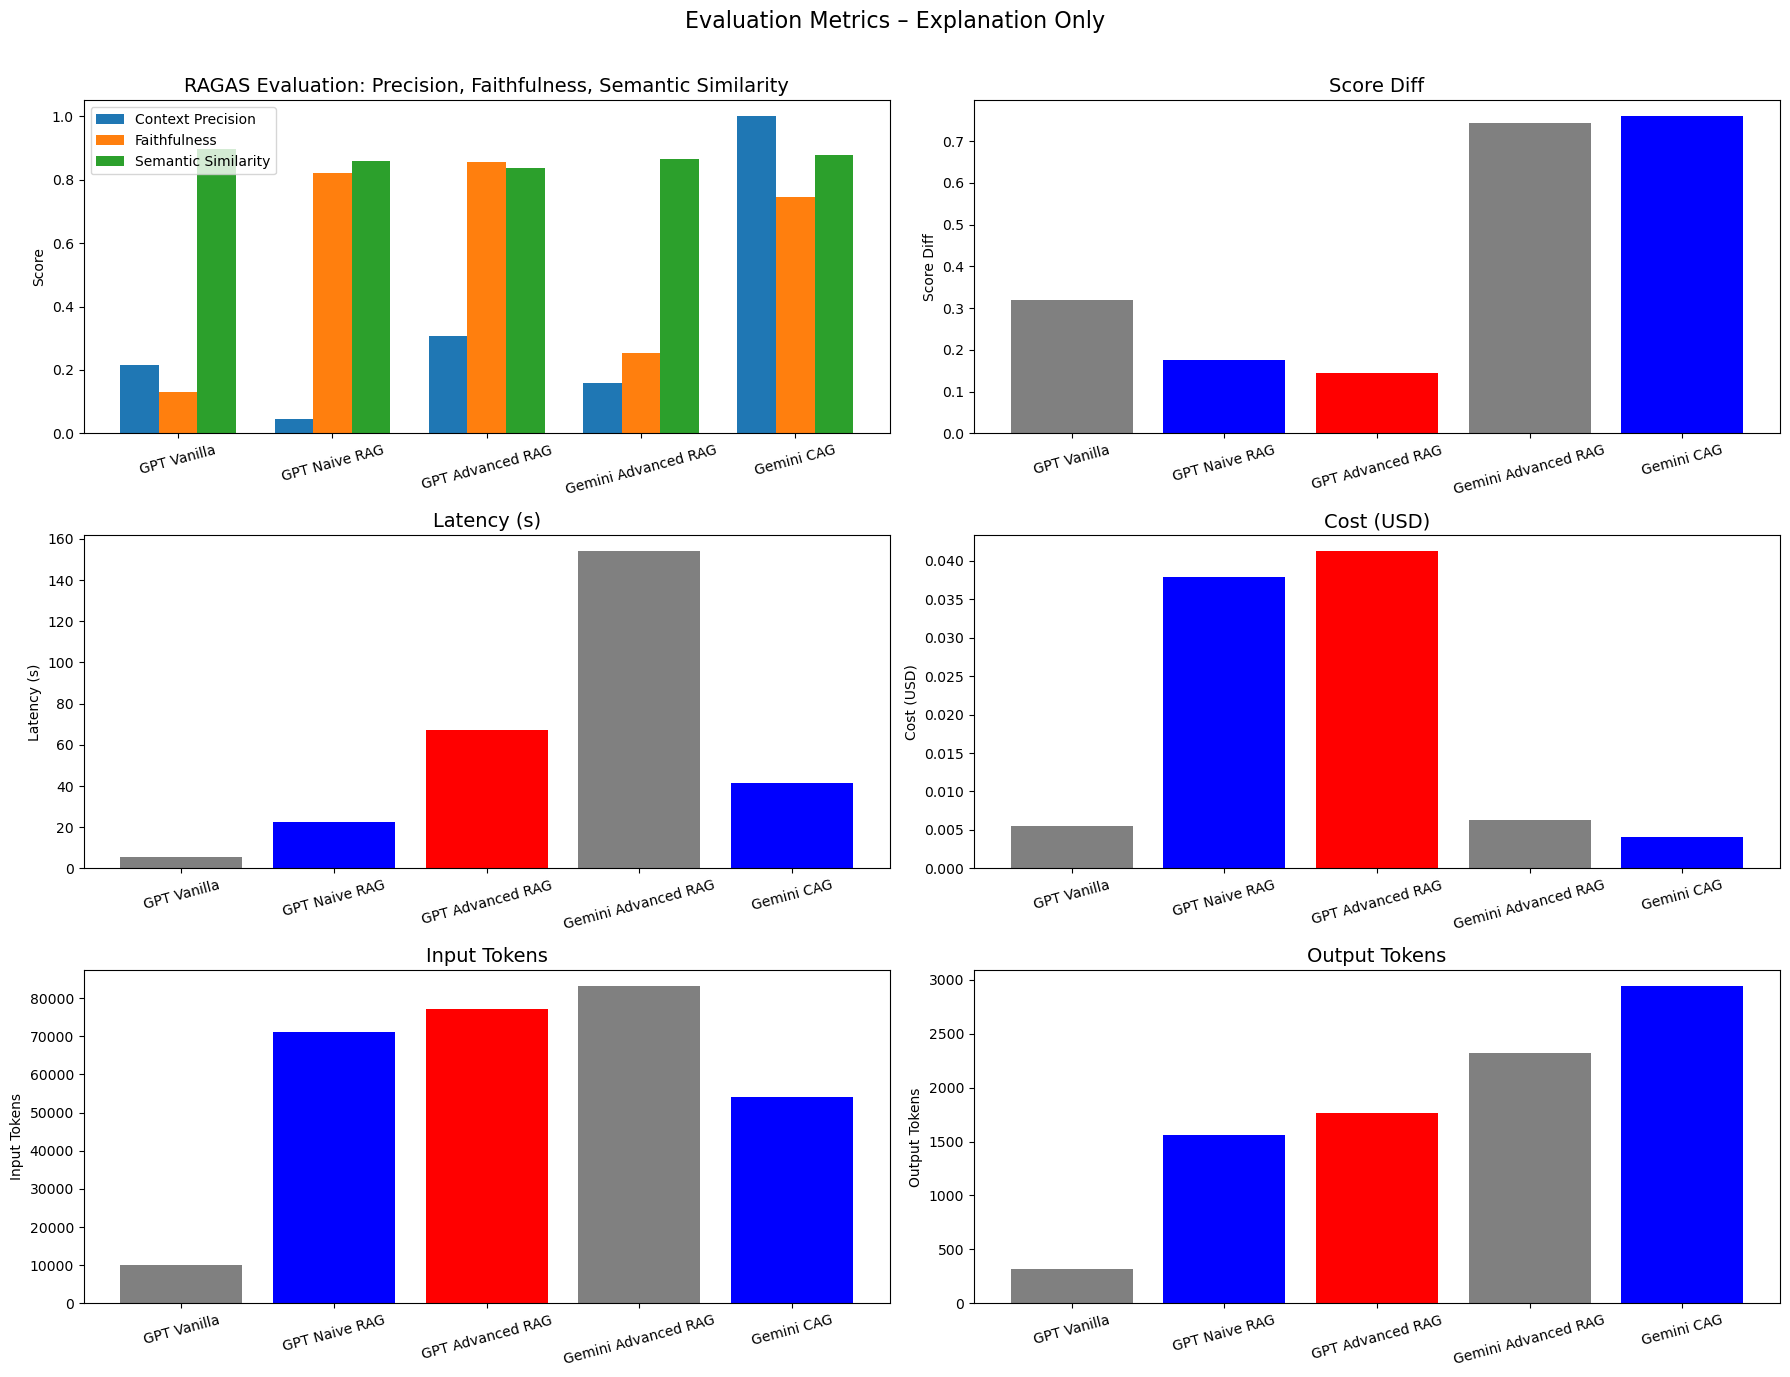

In [119]:
#Plot results for All - Explanation

# Filter only for "explanation"
eval_log_explanation = eval_log[eval_log["output_type"] == "explanation"]

# Model labels
model_labels = eval_log_explanation["model_variant"].tolist()

# Metrics for grouped bar chart
grouped_metrics = ["context_precision", "faithfulness", "semantic_similarity"]
grouped_titles = ["Context Precision", "Faithfulness", "Semantic Similarity"]

# Values for each metric
grouped_values = [eval_log_explanation[m].fillna(0).tolist() for m in grouped_metrics]

# Bar positions
x = np.arange(len(model_labels))  # e.g., 3 models
width = 0.25

# Create 3x2 grid
fig, axs = plt.subplots(3, 2, figsize=(18, 14))
axs = axs.flatten()

# Plot grouped bar chart in first position
ax0 = axs[0]
for i, values in enumerate(grouped_values):
    ax0.bar(x + i * width, values, width, label=grouped_titles[i])

ax0.set_title("RAGAS Evaluation: Precision, Faithfulness, Semantic Similarity", fontsize=14)
ax0.set_ylabel("Score")
ax0.set_xticks(x + width)
ax0.set_xticklabels(model_labels, rotation=15)
ax0.legend()

# Define other single metrics
other_metrics = [
    ("score_diff", "Score Diff"),
    ("latency", "Latency (s)"),
    ("cost_usd", "Cost (USD)"),
    ("input_tokens", "Input Tokens"),
    ("output_tokens", "Output Tokens"),
]

# Plot remaining metrics
for i, (metric, title) in enumerate(other_metrics, start=1):
    axs[i].bar(eval_log_explanation["model_variant"], eval_log_explanation[metric].fillna(0), color=["gray", "blue", "red"])
    axs[i].set_title(title, fontsize=14)
    axs[i].set_ylabel(title)
    axs[i].tick_params(axis='x', rotation=15)

# Global title and layout
plt.suptitle("Evaluation Metrics – Explanation Only", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [120]:
eval_log_explanation

,model_variant,model_name,output_type,transcript_name,context_precision,faithfulness,semantic_similarity,score_diff,consistency,latency,input_tokens,cached_input_tokens,input_token_price_M,cached_input_token_price_M,output_tokens,output_token_price_M,cost_usd
0,GPT Vanilla,gpt-3.5-turbo,explanation,anonymized call 01.txt,0.2167,0.13,0.8963,0.32,0.098,5.46,10171.0,None,0.5,None,318.4,1.5,0.005563
2,GPT Naive RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,0.0463,0.8222,0.8577,0.176,0.1572,22.59,71237.4,None,0.5,None,1556.4,1.5,0.037953
4,GPT Advanced RAG,gpt-3.5-turbo,explanation,anonymized call 01.txt,0.3076,0.857,0.838,0.144,0.0824,67.09,77202.6,None,0.5,None,1765.6,1.5,0.04125
6,Gemini Advanced RAG,gemini-1.5-flash-001,explanation,anonymized call 01.txt,0.1589,0.2533,0.8654,0.744,0.032,154.03,83143.4,None,0.075,None,2320.6,0.3,0.006236
8,Gemini CAG,gemini-1.5-flash-001,explanation,anonymized call 01.txt,1.0,0.7463,0.8792,0.76,0.0438,41.45,53969.2,710372.6,0.075,0.01875,2939.2,0.3,0.004048


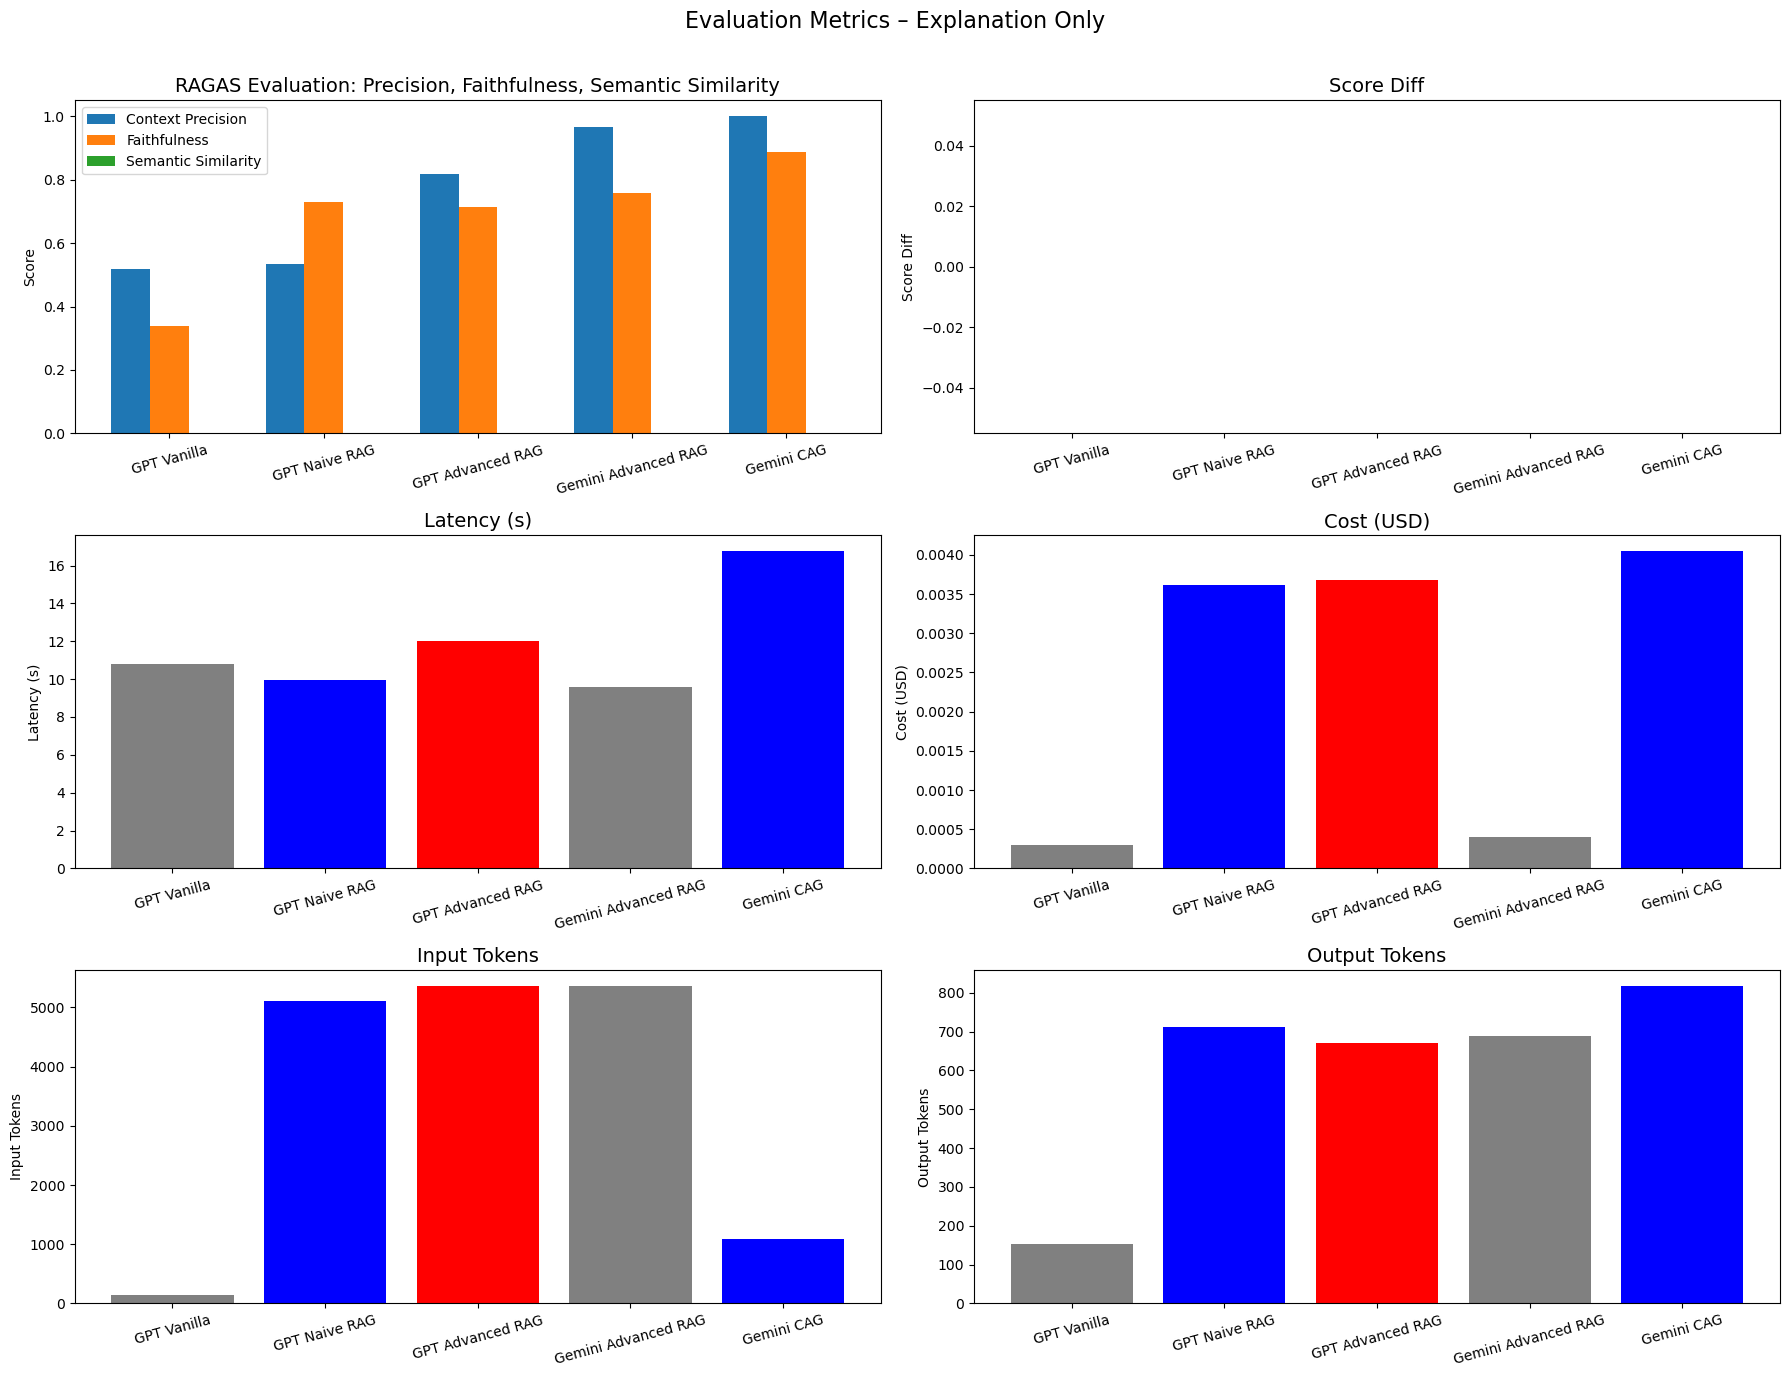

In [121]:
#Plot results for All - Explanation

# Filter only for "explanation"
eval_log_explanation = eval_log[eval_log["output_type"] == "feedback"]

# Model labels
model_labels = eval_log_explanation["model_variant"].tolist()

# Metrics for grouped bar chart
grouped_metrics = ["context_precision", "faithfulness", "semantic_similarity"]
grouped_titles = ["Context Precision", "Faithfulness", "Semantic Similarity"]

# Values for each metric
grouped_values = [eval_log_explanation[m].fillna(0).tolist() for m in grouped_metrics]

# Bar positions
x = np.arange(len(model_labels))  # e.g., 3 models
width = 0.25

# Create 3x2 grid
fig, axs = plt.subplots(3, 2, figsize=(18, 14))
axs = axs.flatten()

# Plot grouped bar chart in first position
ax0 = axs[0]
for i, values in enumerate(grouped_values):
    ax0.bar(x + i * width, values, width, label=grouped_titles[i])

ax0.set_title("RAGAS Evaluation: Precision, Faithfulness, Semantic Similarity", fontsize=14)
ax0.set_ylabel("Score")
ax0.set_xticks(x + width)
ax0.set_xticklabels(model_labels, rotation=15)
ax0.legend()

# Define other single metrics
other_metrics = [
    ("score_diff", "Score Diff"),
    ("latency", "Latency (s)"),
    ("cost_usd", "Cost (USD)"),
    ("input_tokens", "Input Tokens"),
    ("output_tokens", "Output Tokens"),
]

# Plot remaining metrics
for i, (metric, title) in enumerate(other_metrics, start=1):
    axs[i].bar(eval_log_explanation["model_variant"], eval_log_explanation[metric].fillna(0), color=["gray", "blue", "red"])
    axs[i].set_title(title, fontsize=14)
    axs[i].set_ylabel(title)
    axs[i].tick_params(axis='x', rotation=15)

# Global title and layout
plt.suptitle("Evaluation Metrics – Explanation Only", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()